In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gc
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV,cross_validate
from sklearn.preprocessing import MinMaxScaler,LabelEncoder,StandardScaler,RobustScaler
from sklearn.impute import KNNImputer
from sklearn.metrics import accuracy_score,recall_score,precision_score,f1_score,roc_auc_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from sklearn.ensemble import RandomForestClassifier,GradientBoostingClassifier,VotingClassifier,AdaBoostClassifier
from sklearn.metrics import classification_report
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/ieee-fraud-detection/sample_submission.csv
/kaggle/input/ieee-fraud-detection/test_identity.csv
/kaggle/input/ieee-fraud-detection/train_identity.csv
/kaggle/input/ieee-fraud-detection/test_transaction.csv
/kaggle/input/ieee-fraud-detection/train_transaction.csv


### Данный проект решает задачу бинарной классификации.
### Нужно предсказать, к какому типу относится транзакция - мошенническая она ли нет.

#### Данные в датасете **transaction**:
<span style="font-size: 18px;">
    
- TransactionDT - дельта времени от заданного эталонного значения времени (не актуального значения) 
- TransactionAMT - транзакционный платёж в USD
- ProductCD - продуктовый код, продукт каждой транзакции
- card1 - card6 - информация платёжной карты, такая как: тип карты, категория, банк выпуска, страна и т.д.
- addr - адрес
- dist - расстояние
- P_ and (R_) emaildomain: домены покупателя и получателя
- C1-C14 - подсчёт, например сколько адресов связано с платёжной картой и т.д. Фактический смысл скрыт
- D1-D15 - дельта времени, количество дней между предыдущей транзакцией, и т.д.
- M1 - M9 -совпадение, например имена на карте и адресе и т.д.
- Vxxx - Vesta разработала богатые функции, включая ранжирование, подсчёт и другие отношения между сущностями
</span>

<span style="font-size:18px;">
Категориальные признаки:

- ProductCD
- card1-card6
- addr1, addr2
- P_emaildomain
- R_email_domain
- M1 - M9
</span>

#### Данные в датасете **Identity**
<span style="font-size:18px;">
Переменные в этой таблице - идентификационные данные:
    
- информация о сетевом соединении (IP, ISP, прокси и т.д.)
- цифровая подпись (UA/браузер/ОС/версия и т.д.), связанные с транзакциями.
Их собирает система защиты от мошенничества Vesta и партнеры цифровой безопасности.
(Имена полей скрыты, и пояснения значений полей не будет в целях защиты конфиденциальности и их договорного соглашения)
</span>

<span style="font-size:18px;">
Категориальные признаки:
    
- DeviceType
- DeviceInfo
- id_12 - id_38
</span>

### Загрузим все наборы данных данного проекта

In [2]:
train_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_transaction.csv')
train_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/train_identity.csv')
test_transaction=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_transaction.csv')
test_identity=pd.read_csv('/kaggle/input/ieee-fraud-detection/test_identity.csv')
sample_submission=pd.read_csv('/kaggle/input/ieee-fraud-detection/sample_submission.csv')

Объединим таблицы ```*transaction``` и ```*identity``` по полю ```TransactionID```

In [3]:
train = train_transaction.merge(train_identity, how='left', on='TransactionID')
test = test_transaction.merge(test_identity, how='left', on='TransactionID')

Т.к. мы объединили датасеты ```*identity``` и ```*transaction```, удалим их для того, чтобы освободить память

In [4]:
del train_transaction
del train_identity
del test_transaction
del test_identity
gc.collect

<function gc.collect(generation=2)>

Создадим копии датасетов, с которыми будем работать, чтобы не менять исходники

In [5]:
train_df = train.copy()
test_df = test.copy()

Посмотрим какой объём оперативной памяти занимают датасеты:

In [6]:
train_df_GB = train_df.memory_usage(deep=True).sum()/1024**3
test_df_GB = test_df.memory_usage(deep=True).sum()/1024**3

print(f'train df: {train_df_GB:.2f} GB of memory')
print(f'test df : {test_df_GB:.2f} GB of memory')

train df: 2.51 GB of memory
test df : 2.16 GB of memory


Видим, что датафреймы занимают достаточно большой объём оперативной памяти, следовательно на обработку каждого датафрейма будет затрачено большое кол-во ресурсов и довольно длительное время.

Напишем функцию подсчёта объема занимаемой памяти:

In [7]:
def memory_usage(pandas_object):
    if isinstance(pandas_object, pd.DataFrame):
        usage_b = pandas_object.memory_usage(deep=True).sum()
    else:
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert to mb
    return usage_mb

Напишем функцию для уменьшения объёма занимаемой памяти датасетом.

1. Преобразуем все значения подтипов ```int``` в тип ```uint```, т.к. хранение только положительных значений позволит нам уменьшить объём занимаемой памяти.

2. Все значения подтипов ```float``` в тип ```float```
2. ```object``` в ```category```

In [8]:
def reduce_mem_usage_num(df, name):
    start_memory = memory_usage(df)
    
    # convert int
    df_int = df.select_dtypes(include=['int'])
    converted_int = df_int.apply(pd.to_numeric, downcast='unsigned')
    
    # convert float
    df_float = df.select_dtypes(include=['float'])
    converted_float = df_float.apply(pd.to_numeric, downcast='float')
    
    optimized_df = df.copy()
    optimized_df[converted_int.columns] = converted_int
    optimized_df[converted_float.columns] = converted_float
    
    finish_memory = memory_usage(optimized_df)
    diff_memory = start_memory - finish_memory
    diff_memory_prct = 100 - ((finish_memory * 100)/start_memory)
    print(f'start memory of {name} is {start_memory} Mb')
    print(f'memory after optimization of {name} is {finish_memory} Mb')
    print(f'memory usage of {name} decreased on {diff_memory} Mb ({diff_memory_prct} %)\n')
    return optimized_df

In [9]:
train_df = reduce_mem_usage_num(train_df, 'train_df')
test_df = reduce_mem_usage_num(test_df, 'test_df')

start memory of train_df is 2567.094612121582 Mb
memory after optimization of train_df is 1656.4279747009277 Mb
memory usage of train_df decreased on 910.6666374206543 Mb (35.47460358962117 %)

start memory of test_df is 2214.031036376953 Mb
memory after optimization of test_df is 1436.0497455596924 Mb
memory usage of test_df decreased on 777.9812908172607 Mb (35.13868044462248 %)



In [10]:
for col in train_df.columns:
    if train_df[col].dtype == 'object':
        train_df[col] = train_df[col].astype('category')

In [11]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(399), uint16(1), uint32(2), uint8(1)
memory usage: 924.3 MB


In [12]:
for col in test_df.columns:
    if test_df[col].dtype == 'object':
        test_df[col] = test_df[col].astype('category')

In [13]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 506691 entries, 0 to 506690
Columns: 433 entries, TransactionID to DeviceInfo
dtypes: category(31), float32(399), uint16(1), uint32(2)
memory usage: 792.6 MB


In [14]:
print(f'train_df decreased on {100 - (memory_usage(train_df) * 100)/2567.094} %')
print(f'test_df decreased on {100 - (memory_usage(test_df) * 100)/2214.031} %')

train_df decreased on 63.989099234193674 %
test_df decreased on 64.19355467369698 %


Видим, что объём памяти, занимаемый каждым датасетом после преобразования типов признаков уменьшился примерно на ```64``` %

#### Напишем функцию, которая будет представлять отчёт о пропусках в данных

In [15]:
def missing_values_table(df, df_name):
    mis_val = df.isnull().sum()
    len_df = len(df)
    mis_val_percent = 100 * mis_val / len_df
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0: 'Missing Values', 1: '% of Total Values'})
    
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False).round(1)
    
    print(f'{df_name} has ', str(df.shape[1]) + ' columns.\n',
         'There are ' + str(mis_val_table_ren_columns.shape[0]) +
          ' columns that have missing values.')
    return mis_val_table_ren_columns

In [16]:
missing_values_table(train_df, 'train_df')

train_df has  434 columns.
 There are 414 columns that have missing values.


Missing Values  % of Total Values
id_24          585793               99.2
id_25          585408               99.1
id_07          585385               99.1
id_08          585385               99.1
id_21          585381               99.1
...               ...                ...
V285               12                0.0
V284               12                0.0
V280               12                0.0
V279               12                0.0
V312               12                0.0

[414 rows x 2 columns]

In [17]:
missing_values_table(test_df, 'test_df')

test_df has  433 columns.
 There are 385 columns that have missing values.


Missing Values  % of Total Values
id-24          501951               99.1
id-25          501652               99.0
id-26          501644               99.0
id-08          501632               99.0
id-07          501632               99.0
...               ...                ...
V293                3                0.0
C14                 3                0.0
V319                3                0.0
V292                3                0.0
V303                3                0.0

[385 rows x 2 columns]

Заменим признаки с ```-``` в тестовом датасете на соответствующие названия из тренировочного датасета с ```_```

In [18]:
test_df = test_df.rename(columns=lambda x:'_'.join(x.split('-')))

In [19]:
test_df

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0             3663549       18403224       31.950001         W  10409  111.0   
1             3663550       18403263       49.000000         W   4272  111.0   
2             3663551       18403310      171.000000         W   4476  574.0   
3             3663552       18403310      284.950012         W  10989  360.0   
4             3663553       18403317       67.949997         W  18018  452.0   
...               ...            ...             ...       ...    ...    ...   
506686        4170235       34214279       94.679001         C  13832  375.0   
506687        4170236       34214287       12.173000         C   3154  408.0   
506688        4170237       34214326       49.000000         W  16661  490.0   
506689        4170238       34214337      202.000000         W  16621  516.0   
506690        4170239       34214345       24.346001         C   5713  168.0   

        card3       card4  card5   card6  ...                    id_31  id_32  \
0       150.0        visa  226.0   debit  ...                      NaN    NaN   
1       150.0        visa  226.0   debit  ...                      NaN    NaN   
2       150.0        visa  226.0   debit  ...                      NaN    NaN   
3       150.0        visa  166.0   debit  ...                      NaN    NaN   
4       150.0  mastercard  117.0   debit  ...                      NaN    NaN   
...       ...         ...    ...     ...  ...                      ...    ...   
506686  185.0  mastercard  224.0   debit  ...                      NaN    NaN   
506687  185.0  mastercard  224.0   debit  ...  chrome 43.0 for android    NaN   
506688  150.0        visa  226.0   debit  ...                      NaN    NaN   
506689  150.0  mastercard  224.0   debit  ...                      NaN    NaN   
506690  144.0        visa  147.0  credit  ...      samsung browser 8.2    NaN   

        id_33  id_34 id_35 id_36  id_37  id_38  DeviceType  \
0         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
1         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
2         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
3         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
4         NaN    NaN   NaN   NaN    NaN    NaN         NaN   
...       ...    ...   ...   ...    ...    ...         ...   
506686    NaN    NaN   NaN   NaN    NaN    NaN         NaN   
506687    NaN    NaN     F     F      T      F      mobile   
506688    NaN    NaN   NaN   NaN    NaN    NaN         NaN   
506689    NaN    NaN   NaN   NaN    NaN    NaN         NaN   
506690    NaN    NaN     F     F      T      F      mobile   

                         DeviceInfo  
0                               NaN  
1                               NaN  
2                               NaN  
3                               NaN  
4                               NaN  
...                             ...  
506686                          NaN  
506687  ALE-L23 Build/HuaweiALE-L23  
506688                          NaN  
506689                          NaN  
506690                      SAMSUNG  

[506691 rows x 433 columns]

Удаляем признаки, в которых более ```50 %``` пропусков:

In [20]:
missing_df = missing_values_table(train_df, 'train_df')
missing_columns = list(missing_df[missing_df['% of Total Values'] > 50.0].index)
print('We will remove %d columns.' % len(missing_columns))

train_df has  434 columns.
 There are 414 columns that have missing values.
We will remove 214 columns.


In [21]:
train_df = train_df.drop(columns = missing_columns)

In [22]:
train_df.shape

(590540, 220)

In [23]:
test_df = test_df.drop(columns = missing_columns)
test_df.shape

(506691, 219)

Посмотрим ещё раз на пропуски 

In [24]:
miss_val_train_df = missing_values_table(train_df, 'train_df')
miss_val_train_df

train_df has  220 columns.
 There are 200 columns that have missing values.


Missing Values  % of Total Values
M4            281444               47.7
D2            280797               47.5
V7            279287               47.3
V11           279287               47.3
V10           279287               47.3
...              ...                ...
V295              12                0.0
V297              12                0.0
V298              12                0.0
V299              12                0.0
V321              12                0.0

[200 rows x 2 columns]

In [25]:
missing_values_table(test_df, 'test_df')

test_df has  219 columns.
 There are 171 columns that have missing values.


Missing Values  % of Total Values
M4            237745               46.9
D2            234769               46.3
D3            203142               40.1
M3            176639               34.9
M2            176639               34.9
...              ...                ...
V287               3                0.0
V290               3                0.0
V292               3                0.0
V293               3                0.0
V321               3                0.0

[171 rows x 2 columns]

И посмотрим насколько ещё уменьшился занимаемый объём памяти каждого из датасетов

In [26]:
print(f'train_df memory usage: {memory_usage(train_df)} Mb')
print(f'test_df memory usage: {memory_usage(test_df)} Mb')

train_df memory usage: 477.58735275268555 Mb
test_df memory usage: 409.29405784606934 Mb


### Разделим обучающую выборку на обучение и тест

Отделим данные от целевой переменной

In [27]:
X = train_df.drop(columns='isFraud')
y = train_df['isFraud']

In [28]:
y

0         0
1         0
2         0
3         0
4         0
         ..
590535    0
590536    0
590537    0
590538    0
590539    0
Name: isFraud, Length: 590540, dtype: uint8

Разделим обучающую выборку в процентном соотношении:
- train - ```70%```
- test - ```30%```

In [29]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y, stratify=y, test_size=0.3)

In [30]:
X_train.shape

(413378, 219)

In [31]:
y_train.shape

(413378,)

In [32]:
X_valid.shape

(177162, 219)

In [33]:
y_valid.shape

(177162,)

### Посмотрим на распределения признаков до заполнения пропусков

#### Посмотрим на распределение целевой переменной ```isFraud```

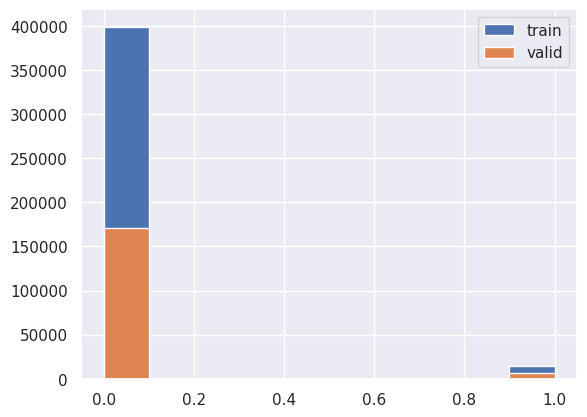

In [34]:
sns.set()
plt.hist(y_train, label='train')
plt.hist(y_valid, label='valid')
plt.legend()

In [35]:
isFraud_count = y_train.value_counts()
isFraud_prct = y_train.value_counts()/len(y_train)

pd.concat([isFraud_count, isFraud_prct], axis=1, keys=['Count', 'Percent'])

Count  Percent
isFraud                 
0        398914  0.96501
1         14464  0.03499

In [36]:
isFraud_count = y_valid.value_counts()
isFraud_prct = y_valid.value_counts()/len(y_valid)

pd.concat([isFraud_count, isFraud_prct], axis=1, keys=['Count', 'Percent'])

Count   Percent
isFraud                  
0        170963  0.965009
1          6199  0.034991

Видим, что данные не сбалансированы:

- ```96,5 %``` транзакций - валидны

- ```3,5 %``` транзакций - мошеннические

Подумаем о решении вопроса дисбаланса в данных. Исследуем другие признаки.

Напишем функцию для построения распределений признаков

In [37]:
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd',
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

def plot_value_counts(feature, title, df):
    ax = df[feature].value_counts().plot(kind='bar',
                                            figsize=(7,5),
                                            xlabel=title,
                                            ylabel='count',
                                            edgecolor='k',
                                            color=colors)
    ax.set_title(f'Percentage of {title}')
    counts = df[feature].value_counts()/len(df)
    
    rects = ax.patches
    labels_arr = ['{0:.2f}%'.format(count*100) for count in counts]
    
    if (len(labels_arr) > 2):
        plt.xticks(rotation=0, size=8)
        
    for rect, label in zip(rects, labels_arr):
        height = rect.get_height()
        ax.text(
            rect.get_x() + rect.get_width() / 2, height, label, ha='center', va='bottom'
        )
    
    plt.show()

#### Распределение ```Card 4``` (компания карты)

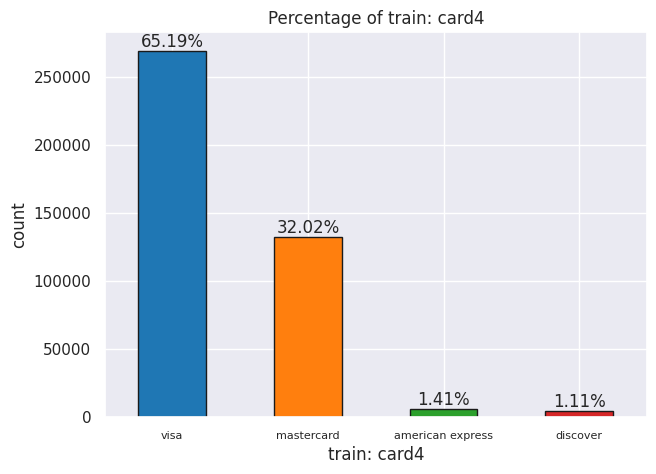

In [38]:
plot_value_counts('card4', 'train: card4', df=X_train)

Видим, что:

- ```65,34 %``` - карт компании 'visa'
- ```31,61 %``` - 'mastercard'
- ```1,68 %```  - 'american express'
- ```1,16 %```  - 'discover'

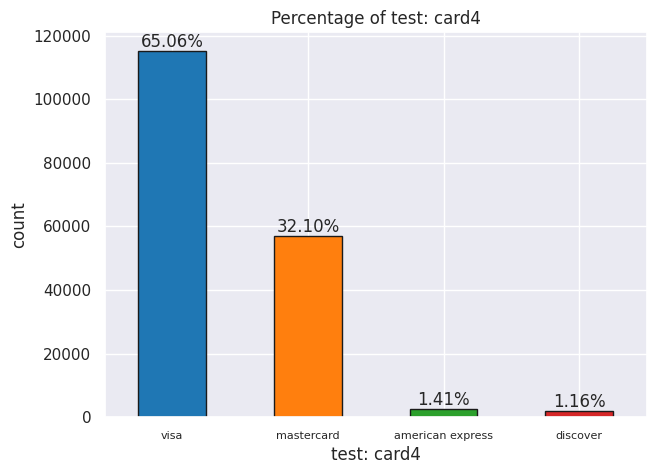

In [39]:
plot_value_counts('card4', 'test: card4', df=X_valid)

#### Распределение ```Card 6``` - тип карты

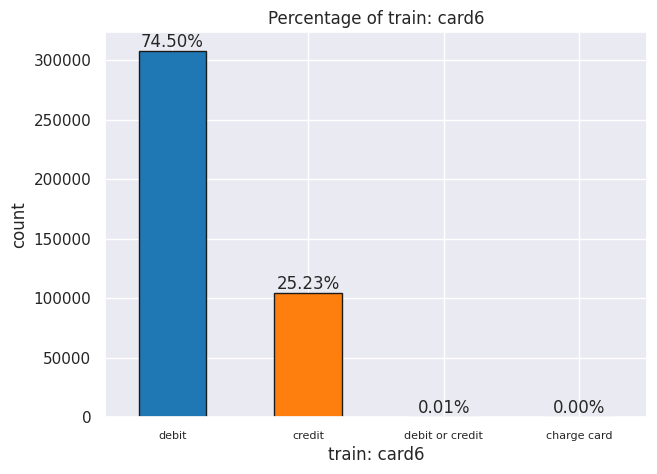

In [40]:
plot_value_counts('card6', 'train: card6', df=X_train)

Большая часть транзакций произведена дебетовыми картами - ```73,17 %```, ```26,61 %``` - кредитными картами. Транзакций с ```charge``` карт нет

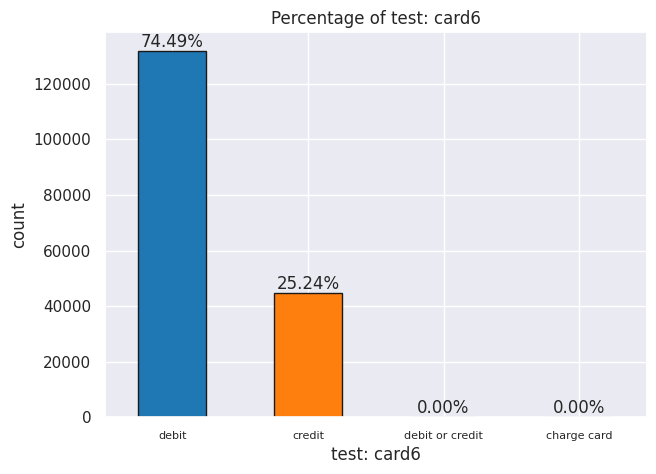

In [41]:
plot_value_counts('card6', 'test: card6', df=X_valid)

#### Посмотрим на распределение транзакций в разрезе компаний, выпустивших карты

Напишем функцию для визуализации распределения транзакций в разрезе какого-либо признака

In [42]:
def isFraud_by_feature(feature, df, title):
    sns.barplot(x=feature, y='isFraud', data=df)
    plt.xlabel(feature)
    plt.ylabel('isFraud')
    plt.title('Fraudulent Transactions by {}'.format(title))
    plt.show()

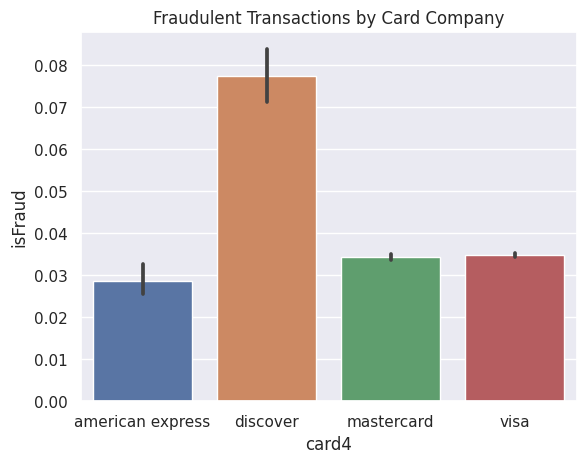

In [43]:
isFraud_by_feature('card4', df=train_df, title='Card Company')

Большинство операций произведено с карт ```discover```

#### Распределение транзакций в разрезе типа карты

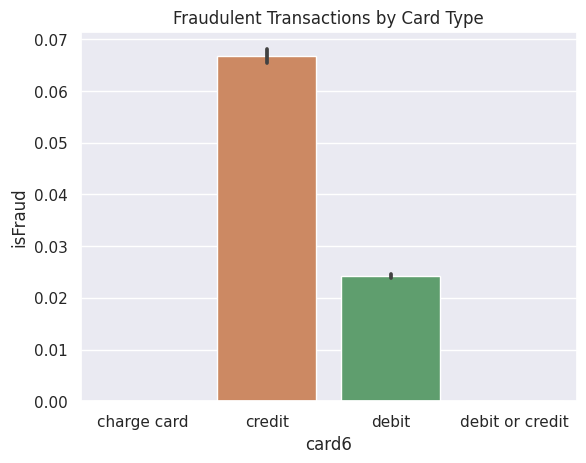

In [44]:
isFraud_by_feature('card6', df=train_df, title='Card Type')

Несмотря на то, что кредитные карты занимают ```25,23 %``` от всего объема данных, с них произведена большая часть транзакций

### Посмотрим, есть ли в данных дубликаты

In [45]:
X_train.duplicated().sum()

0

In [46]:
X_valid.duplicated().sum()

0

### Преобразуем категориальные признаки в числа

In [47]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413378 entries, 476450 to 249268
Columns: 219 entries, TransactionID to V321
dtypes: category(9), float32(207), uint16(1), uint32(2)
memory usage: 337.1 MB


In [48]:
for f in X_train.columns:
    if X_train.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(X_train.loc[:, f].values))
        X_train.loc[:, f] = le.transform(list(X_train.loc[:, f].values))

In [49]:
X_train

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
476450        3463450       12334619       57.950001          4  13249  111.0   
257888        3244888        6193795      107.949997          4  10045  114.0   
292700        3279700        7231162       12.247000          0  16136  204.0   
440564        3427564       11170518       39.000000          4  10049  555.0   
63257         3050257        1443611       35.000000          4  17188  321.0   
...               ...            ...             ...        ...    ...    ...   
472312        3459312       12189740      226.000000          4  13249  111.0   
558763        3545763       14783844      210.949997          4   9515  492.0   
407699        3394699       10288866       90.328003          0  17392  555.0   
17279         3004279         455563      159.949997          4   7664  490.0   
249268        3236268        5943058     1533.349976          4   5938  111.0   

        card3  card4  card5  card6  ...        V312   V313   V314   V315  \
476450  150.0      4  226.0      2  ...   67.949997    0.0    0.0    0.0   
257888  150.0      4  226.0      2  ...    0.000000    0.0    0.0    0.0   
292700  185.0      4  138.0      2  ...    0.000000    0.0    0.0    0.0   
440564  150.0      4  226.0      2  ...  174.000000  174.0  174.0  174.0   
63257   150.0      4  226.0      2  ...    0.000000    0.0    0.0    0.0   
...       ...    ...    ...    ...  ...         ...    ...    ...    ...   
472312  150.0      4  226.0      2  ...    0.000000    0.0    0.0    0.0   
558763  150.0      4  226.0      2  ...    0.000000    0.0    0.0    0.0   
407699  100.0      2  102.0      1  ...    0.000000    0.0    0.0    0.0   
17279   150.0      4  226.0      2  ...    0.000000    0.0    0.0    0.0   
249268  150.0      4  162.0      1  ...    0.000000    0.0    0.0    0.0   

        V316   V317   V318  V319  V320  V321  
476450   0.0    0.0    0.0   0.0   0.0   0.0  
257888   0.0    0.0    0.0   0.0   0.0   0.0  
292700   0.0    0.0    0.0   0.0   0.0   0.0  
440564   0.0  427.0  427.0   0.0   0.0   0.0  
63257    0.0    0.0    0.0   0.0   0.0   0.0  
...      ...    ...    ...   ...   ...   ...  
472312   0.0    0.0    0.0   0.0   0.0   0.0  
558763   0.0    0.0    0.0   0.0   0.0   0.0  
407699   0.0    0.0    0.0   0.0   0.0   0.0  
17279    0.0    0.0    0.0   0.0   0.0   0.0  
249268   0.0    0.0    0.0   0.0   0.0   0.0  

[413378 rows x 219 columns]

In [50]:
for f in X_valid.columns:
    if X_valid.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(X_valid.loc[:, f].values))
        X_valid.loc[:, f] = le.transform(list(X_valid.loc[:, f].values))

In [51]:
X_valid

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
249789        3236789        5951813      189.949997          4  13906  369.0   
296417        3283417        7326502       87.949997          4   8406  264.0   
589439        3576439       15788784      150.000000          1   1724  583.0   
422091        3409091       10692050       97.000000          4  17396  321.0   
32528         3019528         796841       59.000000          4  13307  428.0   
...               ...            ...             ...        ...    ...    ...   
559622        3546622       14830954      106.000000          3  15775  481.0   
85552         3072552        1809249       50.000000          1   3821  111.0   
122974        3109974        2413519       16.674000          0  15885  545.0   
414668        3401668       10456561       82.949997          4  11710  479.0   
440391        3427391       11156097      236.949997          4   6595  127.0   

        card3  card4  card5  card6  ...   V312   V313   V314   V315     V316  \
249789  150.0      2  117.0      2  ...    0.0    0.0    0.0    0.0      0.0   
296417  150.0      4  226.0      2  ...    0.0    0.0    0.0    0.0      0.0   
589439  150.0      4  226.0      1  ...    0.0    0.0    0.0    0.0      0.0   
422091  150.0      4  195.0      1  ...    0.0    0.0    0.0    0.0      0.0   
32528   150.0      4  166.0      2  ...    0.0    0.0    0.0    0.0      0.0   
...       ...    ...    ...    ...  ...    ...    ...    ...    ...      ...   
559622  150.0      2  102.0      1  ...  942.0  100.0  740.0  100.0  35015.0   
85552   150.0      2  219.0      1  ...    0.0    0.0    0.0    0.0      0.0   
122974  185.0      4  138.0      2  ...    0.0    0.0    0.0    0.0      0.0   
414668  150.0      4  226.0      1  ...    0.0    0.0    0.0    0.0      0.0   
440391  150.0      2  117.0      2  ...    0.0    0.0    0.0    0.0      0.0   

           V317     V318    V319    V320    V321  
249789      0.0      0.0     0.0     0.0     0.0  
296417      0.0      0.0     0.0     0.0     0.0  
589439      0.0      0.0     0.0     0.0     0.0  
422091      0.0      0.0     0.0     0.0     0.0  
32528       0.0      0.0     0.0     0.0     0.0  
...         ...      ...     ...     ...     ...  
559622  72824.0  57893.0  1165.0  7226.0  3987.0  
85552       0.0      0.0     0.0     0.0     0.0  
122974      0.0      0.0     0.0     0.0     0.0  
414668      0.0      0.0     0.0     0.0     0.0  
440391      0.0      0.0     0.0     0.0     0.0  

[177162 rows x 219 columns]

In [52]:
test_df

TransactionID  TransactionDT  TransactionAmt ProductCD  card1  card2  \
0             3663549       18403224       31.950001         W  10409  111.0   
1             3663550       18403263       49.000000         W   4272  111.0   
2             3663551       18403310      171.000000         W   4476  574.0   
3             3663552       18403310      284.950012         W  10989  360.0   
4             3663553       18403317       67.949997         W  18018  452.0   
...               ...            ...             ...       ...    ...    ...   
506686        4170235       34214279       94.679001         C  13832  375.0   
506687        4170236       34214287       12.173000         C   3154  408.0   
506688        4170237       34214326       49.000000         W  16661  490.0   
506689        4170238       34214337      202.000000         W  16621  516.0   
506690        4170239       34214345       24.346001         C   5713  168.0   

        card3       card4  card5   card6  ...       V312        V313  \
0       150.0        visa  226.0   debit  ...   0.000000    0.000000   
1       150.0        visa  226.0   debit  ...  77.000000    0.000000   
2       150.0        visa  226.0   debit  ...   0.000000    0.000000   
3       150.0        visa  166.0   debit  ...   0.000000  282.540009   
4       150.0  mastercard  117.0   debit  ...  67.949997   67.949997   
...       ...         ...    ...     ...  ...        ...         ...   
506686  185.0  mastercard  224.0   debit  ...   0.000000    0.000000   
506687  185.0  mastercard  224.0   debit  ...   0.000000   31.723700   
506688  150.0        visa  226.0   debit  ...   0.000000    0.000000   
506689  150.0  mastercard  224.0   debit  ...   0.000000    0.000000   
506690  144.0        visa  147.0  credit  ...   0.000000    0.000000   

              V314        V315  V316  V317  V318  V319   V320  V321  
0         0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
1         0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
2         0.000000    0.000000   0.0   0.0   0.0   0.0  263.0   0.0  
3       282.540009  282.540009   0.0   0.0   0.0   0.0    0.0   0.0  
4       183.850006   67.949997   0.0   0.0   0.0   0.0    0.0   0.0  
...            ...         ...   ...   ...   ...   ...    ...   ...  
506686    0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506687   31.723700   31.723700   0.0   0.0   0.0   0.0    0.0   0.0  
506688    0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506689    0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506690    0.000000    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  

[506691 rows x 219 columns]

In [53]:
for f in test_df.columns:
    if test_df.loc[:, f].dtype=='category':
        le = LabelEncoder()
        le.fit(list(test_df.loc[:, f].values))
        test_df.loc[:, f] = le.transform(list(test_df.loc[:, f].values))

In [54]:
test_df

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
0             3663549       18403224       31.950001          4  10409  111.0   
1             3663550       18403263       49.000000          4   4272  111.0   
2             3663551       18403310      171.000000          4   4476  574.0   
3             3663552       18403310      284.950012          4  10989  360.0   
4             3663553       18403317       67.949997          4  18018  452.0   
...               ...            ...             ...        ...    ...    ...   
506686        4170235       34214279       94.679001          0  13832  375.0   
506687        4170236       34214287       12.173000          0   3154  408.0   
506688        4170237       34214326       49.000000          4  16661  490.0   
506689        4170238       34214337      202.000000          4  16621  516.0   
506690        4170239       34214345       24.346001          0   5713  168.0   

        card3  card4  card5  card6  ...       V312        V313        V314  \
0       150.0      4  226.0      2  ...   0.000000    0.000000    0.000000   
1       150.0      4  226.0      2  ...  77.000000    0.000000    0.000000   
2       150.0      4  226.0      2  ...   0.000000    0.000000    0.000000   
3       150.0      4  166.0      2  ...   0.000000  282.540009  282.540009   
4       150.0      2  117.0      2  ...  67.949997   67.949997  183.850006   
...       ...    ...    ...    ...  ...        ...         ...         ...   
506686  185.0      2  224.0      2  ...   0.000000    0.000000    0.000000   
506687  185.0      2  224.0      2  ...   0.000000   31.723700   31.723700   
506688  150.0      4  226.0      2  ...   0.000000    0.000000    0.000000   
506689  150.0      2  224.0      2  ...   0.000000    0.000000    0.000000   
506690  144.0      4  147.0      1  ...   0.000000    0.000000    0.000000   

              V315  V316  V317  V318  V319   V320  V321  
0         0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
1         0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
2         0.000000   0.0   0.0   0.0   0.0  263.0   0.0  
3       282.540009   0.0   0.0   0.0   0.0    0.0   0.0  
4        67.949997   0.0   0.0   0.0   0.0    0.0   0.0  
...            ...   ...   ...   ...   ...    ...   ...  
506686    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506687   31.723700   0.0   0.0   0.0   0.0    0.0   0.0  
506688    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506689    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  
506690    0.000000   0.0   0.0   0.0   0.0    0.0   0.0  

[506691 rows x 219 columns]

### Корреляция признаков

Выведем корреляции признаков в виде списка и отсортируем значения по убыванию. Отберём признаки с высокой корреляцией (>0.7)

In [55]:
df_corr = X_train.corr()

corrs = []
for feat1 in df_corr:
    for i, feat2 in enumerate(df_corr):
        corrs.append((feat1, feat2, df_corr[feat1].values[i]))
sorted_corrs = sorted(corrs, key=lambda x: x[2], reverse=True)
max_sorted_corrs = [sort_tuple for sort_tuple in sorted_corrs \
                    if sort_tuple[0]!=('TransactionID' or 'TransactionDT') \
                    and sort_tuple[1]!=('TransactionID' or 'TransactionDT') \
                    and sort_tuple[-1] > 0.7 \
                    and sort_tuple[-1] < 1.0]
max_sorted_corrs[:30]

[('C7', 'C12', 0.9995066338816434),
 ('C1', 'C11', 0.9966233538857705),
 ('C1', 'C2', 0.9951414809648289),
 ('C2', 'C1', 0.9951414809648289),
 ('C2', 'C11', 0.9940032856540836),
 ('C6', 'C11', 0.9910681144681068),
 ('C7', 'C10', 0.9850053699701922),
 ('C6', 'C14', 0.9842951153315883),
 ('C7', 'C8', 0.9829589363012557),
 ('C1', 'C6', 0.9822875354480816),
 ('C6', 'C1', 0.9822875354480816),
 ('D1', 'D2', 0.9815434510722878),
 ('D2', 'D1', 0.9815434510722878),
 ('C2', 'C8', 0.9758793490843214),
 ('C2', 'C6', 0.974950882492698),
 ('C6', 'C2', 0.974950882492698),
 ('C2', 'C4', 0.9722606173166424),
 ('C2', 'C10', 0.9708436008760196),
 ('C1', 'C4', 0.9680195805221293),
 ('C1', 'C8', 0.9680116530351704),
 ('C6', 'C4', 0.9624463991828116),
 ('C1', 'C10', 0.9587334552832634),
 ('C1', 'C14', 0.9520029374108686),
 ('M2', 'M3', 0.9408437975855147),
 ('M3', 'M2', 0.9408437975855147),
 ('C2', 'C12', 0.9400018451428991),
 ('C2', 'C7', 0.9386627077759628),
 ('C7', 'C2', 0.9386627077759628),
 ('C2', 'C14

Удалим признаки с высокой корреляцией (> 0.7)

In [56]:
max_sorted_corrs_feats1 = [tup[0] for tup in max_sorted_corrs]
max_sorted_corrs_feats2 = [tup[1] for tup in max_sorted_corrs]
max_sorted_corrs_feats = max_sorted_corrs_feats1 + max_sorted_corrs_feats2
set_max_sort_corrs_feats = set(max_sorted_corrs_feats)
print(len(max_sorted_corrs_feats1))
print(len(max_sorted_corrs_feats2))
print(len(max_sorted_corrs_feats))
print(len(set_max_sort_corrs_feats))
set_max_sort_corrs_feats

2630
2630
5260
198


{'C1',
 'C10',
 'C11',
 'C12',
 'C13',
 'C14',
 'C2',
 'C4',
 'C5',
 'C6',
 'C7',
 'C8',
 'C9',
 'D1',
 'D10',
 'D11',
 'D15',
 'D2',
 'D4',
 'M1',
 'M2',
 'M3',
 'M4',
 'M6',
 'V10',
 'V100',
 'V101',
 'V102',
 'V103',
 'V104',
 'V105',
 'V106',
 'V108',
 'V109',
 'V11',
 'V110',
 'V111',
 'V112',
 'V113',
 'V114',
 'V115',
 'V116',
 'V117',
 'V118',
 'V119',
 'V12',
 'V120',
 'V122',
 'V123',
 'V124',
 'V125',
 'V126',
 'V127',
 'V128',
 'V129',
 'V13',
 'V130',
 'V131',
 'V132',
 'V133',
 'V134',
 'V135',
 'V136',
 'V137',
 'V14',
 'V15',
 'V16',
 'V17',
 'V18',
 'V19',
 'V2',
 'V20',
 'V21',
 'V22',
 'V23',
 'V24',
 'V25',
 'V26',
 'V27',
 'V279',
 'V28',
 'V280',
 'V282',
 'V283',
 'V284',
 'V285',
 'V287',
 'V288',
 'V289',
 'V29',
 'V290',
 'V291',
 'V292',
 'V293',
 'V294',
 'V295',
 'V296',
 'V297',
 'V298',
 'V299',
 'V3',
 'V30',
 'V300',
 'V301',
 'V302',
 'V303',
 'V304',
 'V306',
 'V307',
 'V308',
 'V309',
 'V31',
 'V310',
 'V311',
 'V312',
 'V313',
 'V314',
 'V315',
 'V3

In [57]:
X_train = X_train.drop(columns=list(set_max_sort_corrs_feats))
X_train

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
476450        3463450       12334619       57.950001          4  13249  111.0   
257888        3244888        6193795      107.949997          4  10045  114.0   
292700        3279700        7231162       12.247000          0  16136  204.0   
440564        3427564       11170518       39.000000          4  10049  555.0   
63257         3050257        1443611       35.000000          4  17188  321.0   
...               ...            ...             ...        ...    ...    ...   
472312        3459312       12189740      226.000000          4  13249  111.0   
558763        3545763       14783844      210.949997          4   9515  492.0   
407699        3394699       10288866       90.328003          0  17392  555.0   
17279         3004279         455563      159.949997          4   7664  490.0   
249268        3236268        5943058     1533.349976          4   5938  111.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3     D3   V1  V55  \
476450      4  226.0      2  264.0  ...             16  0.0    3.0  1.0  1.0   
257888      4  226.0      2  512.0  ...             16  0.0   73.0  1.0  1.0   
292700      4  138.0      2    NaN  ...             16  0.0   24.0  NaN  1.0   
440564      4  226.0      2  191.0  ...             32  0.0    5.0  NaN  1.0   
63257       4  226.0      2  299.0  ...             16  0.0    NaN  1.0  1.0   
...       ...    ...    ...    ...  ...            ...  ...    ...  ...  ...   
472312      4  226.0      2  264.0  ...              2  0.0    NaN  NaN  1.0   
558763      4  226.0      2  343.0  ...              1  0.0  191.0  1.0  1.0   
407699      2  102.0      1    NaN  ...             38  0.0    NaN  NaN  1.0   
17279       4  226.0      2  264.0  ...             54  0.0    NaN  NaN  1.0   
249268      4  162.0      1  272.0  ...              3  0.0    NaN  1.0  1.0   

        V107  V121  V281  V286  V305  
476450   1.0   1.0   0.0   0.0   1.0  
257888   1.0   1.0   0.0   0.0   1.0  
292700   1.0   1.0   0.0   0.0   1.0  
440564   1.0   1.0   2.0   0.0   1.0  
63257    1.0   1.0   0.0   0.0   1.0  
...      ...   ...   ...   ...   ...  
472312   1.0   1.0   0.0   0.0   1.0  
558763   1.0   1.0   0.0   0.0   1.0  
407699   1.0   1.0   0.0   0.0   1.0  
17279    1.0   1.0   0.0   0.0   1.0  
249268   1.0   1.0   0.0   0.0   1.0  

[413378 rows x 21 columns]

In [58]:
X_valid = X_valid.drop(columns=list(set_max_sort_corrs_feats))
X_valid

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
249789        3236789        5951813      189.949997          4  13906  369.0   
296417        3283417        7326502       87.949997          4   8406  264.0   
589439        3576439       15788784      150.000000          1   1724  583.0   
422091        3409091       10692050       97.000000          4  17396  321.0   
32528         3019528         796841       59.000000          4  13307  428.0   
...               ...            ...             ...        ...    ...    ...   
559622        3546622       14830954      106.000000          3  15775  481.0   
85552         3072552        1809249       50.000000          1   3821  111.0   
122974        3109974        2413519       16.674000          0  15885  545.0   
414668        3401668       10456561       82.949997          4  11710  479.0   
440391        3427391       11156097      236.949997          4   6595  127.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3    D3   V1  V55  \
249789      2  117.0      2  325.0  ...             25  0.0   NaN  1.0  1.0   
296417      4  226.0      2  337.0  ...             16  0.0  97.0  1.0  1.0   
589439      4  226.0      1  325.0  ...             28  0.0   NaN  NaN  NaN   
422091      4  195.0      1  299.0  ...              2  0.0  34.0  1.0  1.0   
32528       4  166.0      2  264.0  ...              2  0.0   NaN  NaN  1.0   
...       ...    ...    ...    ...  ...            ...  ...   ...  ...  ...   
559622      2  102.0      1  330.0  ...             32  0.0   0.0  NaN  1.0   
85552       2  219.0      1  330.0  ...             16  0.0   NaN  NaN  NaN   
122974      4  138.0      2    NaN  ...             19  0.0   NaN  NaN  1.0   
414668      4  226.0      1  143.0  ...             16  0.0  26.0  1.0  1.0   
440391      2  117.0      2  325.0  ...             54  0.0   NaN  NaN  1.0   

        V107  V121  V281  V286  V305  
249789   1.0   1.0   0.0   0.0   1.0  
296417   1.0   1.0   0.0   0.0   1.0  
589439   1.0   1.0   0.0   0.0   1.0  
422091   1.0   1.0   0.0   0.0   1.0  
32528    1.0   1.0   0.0   0.0   1.0  
...      ...   ...   ...   ...   ...  
559622   1.0   1.0   0.0   0.0   1.0  
85552    1.0   1.0   0.0   0.0   1.0  
122974   1.0   1.0   0.0   0.0   1.0  
414668   1.0   1.0   0.0   0.0   1.0  
440391   1.0   1.0   0.0   0.0   1.0  

[177162 rows x 21 columns]

In [59]:
test_df = test_df.drop(columns=list(set_max_sort_corrs_feats))
test_df

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
0             3663549       18403224       31.950001          4  10409  111.0   
1             3663550       18403263       49.000000          4   4272  111.0   
2             3663551       18403310      171.000000          4   4476  574.0   
3             3663552       18403310      284.950012          4  10989  360.0   
4             3663553       18403317       67.949997          4  18018  452.0   
...               ...            ...             ...        ...    ...    ...   
506686        4170235       34214279       94.679001          0  13832  375.0   
506687        4170236       34214287       12.173000          0   3154  408.0   
506688        4170237       34214326       49.000000          4  16661  490.0   
506689        4170238       34214337      202.000000          4  16621  516.0   
506690        4170239       34214345       24.346001          0   5713  168.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3    D3   V1  V55  \
0           4  226.0      2  170.0  ...             16  0.0  27.0  1.0  1.0   
1           4  226.0      2  299.0  ...              2  0.0   7.0  1.0  1.0   
2           4  226.0      2  472.0  ...             19  0.0  10.0  1.0  1.0   
3           4  166.0      2  205.0  ...             16  0.0  41.0  1.0  1.0   
4           2  117.0      2  264.0  ...             16  0.0   0.0  1.0  1.0   
...       ...    ...    ...    ...  ...            ...  ...   ...  ...  ...   
506686      2  224.0      2  284.0  ...             16  0.0   NaN  NaN  1.0   
506687      2  224.0      2    NaN  ...             19  0.0  16.0  NaN  2.0   
506688      4  226.0      2  327.0  ...             19  0.0   NaN  1.0  1.0   
506689      2  224.0      2  177.0  ...             19  0.0   NaN  1.0  1.0   
506690      4  147.0      1    NaN  ...             19  0.0   NaN  NaN  1.0   

        V107  V121  V281  V286  V305  
0        1.0   1.0   0.0   0.0   1.0  
1        1.0   1.0   0.0   0.0   1.0  
2        1.0   1.0   0.0   0.0   1.0  
3        1.0   1.0   0.0   0.0   1.0  
4        1.0   1.0   0.0   1.0   1.0  
...      ...   ...   ...   ...   ...  
506686   1.0   1.0   0.0   0.0   1.0  
506687   1.0   1.0   1.0   0.0   1.0  
506688   1.0   1.0   0.0   0.0   1.0  
506689   1.0   1.0   0.0   0.0   1.0  
506690   1.0   1.0   0.0   0.0   1.0  

[506691 rows x 21 columns]

Ещё раз проверим корреляцию признаков по карте корреляции

<Axes: >

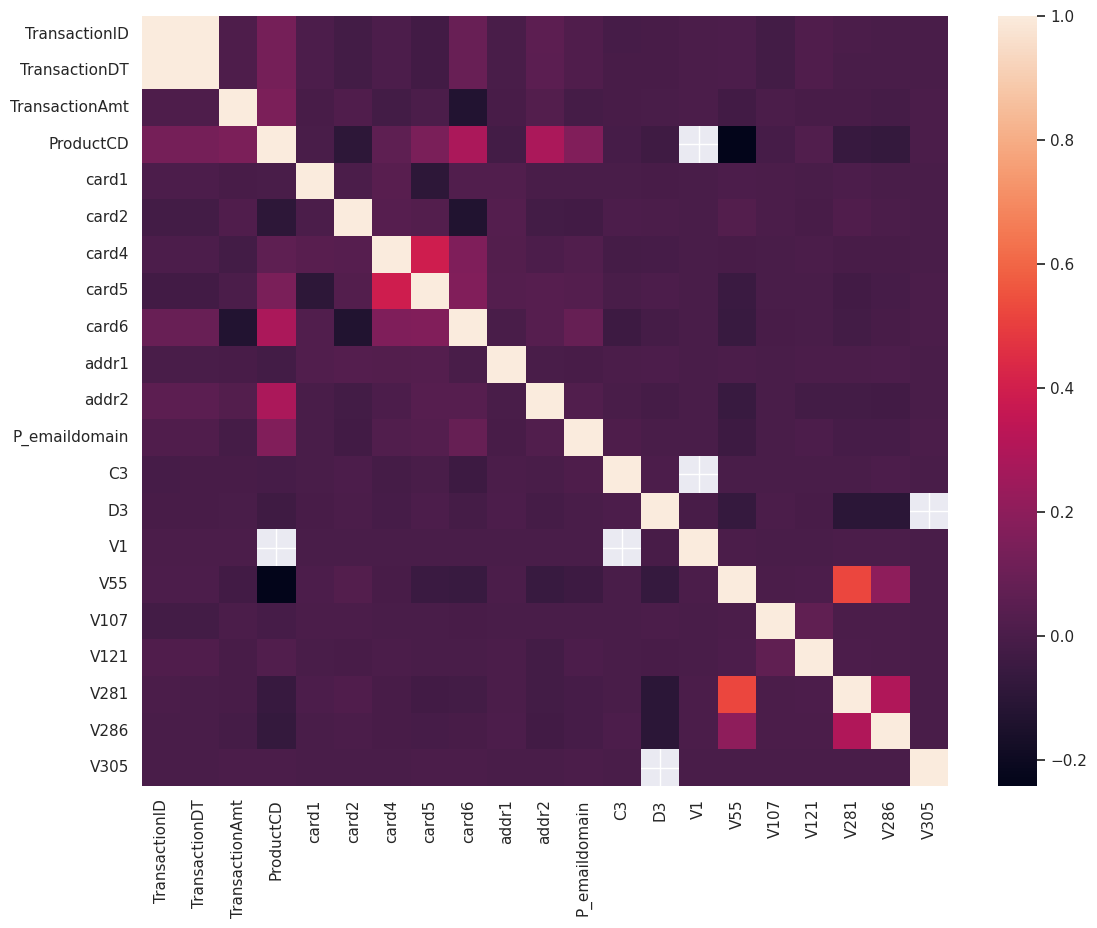

In [60]:
plt.figure(figsize=(13,10))
sns.heatmap(X_train.corr(), 
           xticklabels=X_train.columns, 
           yticklabels=X_train.columns)

Видим, что в датасете остались только слабо кореллированные признаки

### Посмотрим, есть ли в данных выбросы

Сперва отделим категориальные признаки от числовых

In [61]:
cat_feats = ['ProductCD', 'card1', 'card2', 'card4', 
             'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']
num_feats = [x for x in X_train.columns if x not in cat_feats]
print(f'cat_feats:\n {cat_feats}\n')
print(f'num_feats:\n {num_feats}')

cat_feats:
 ['ProductCD', 'card1', 'card2', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'P_emaildomain']

num_feats:
 ['TransactionID', 'TransactionDT', 'TransactionAmt', 'C3', 'D3', 'V1', 'V55', 'V107', 'V121', 'V281', 'V286', 'V305']


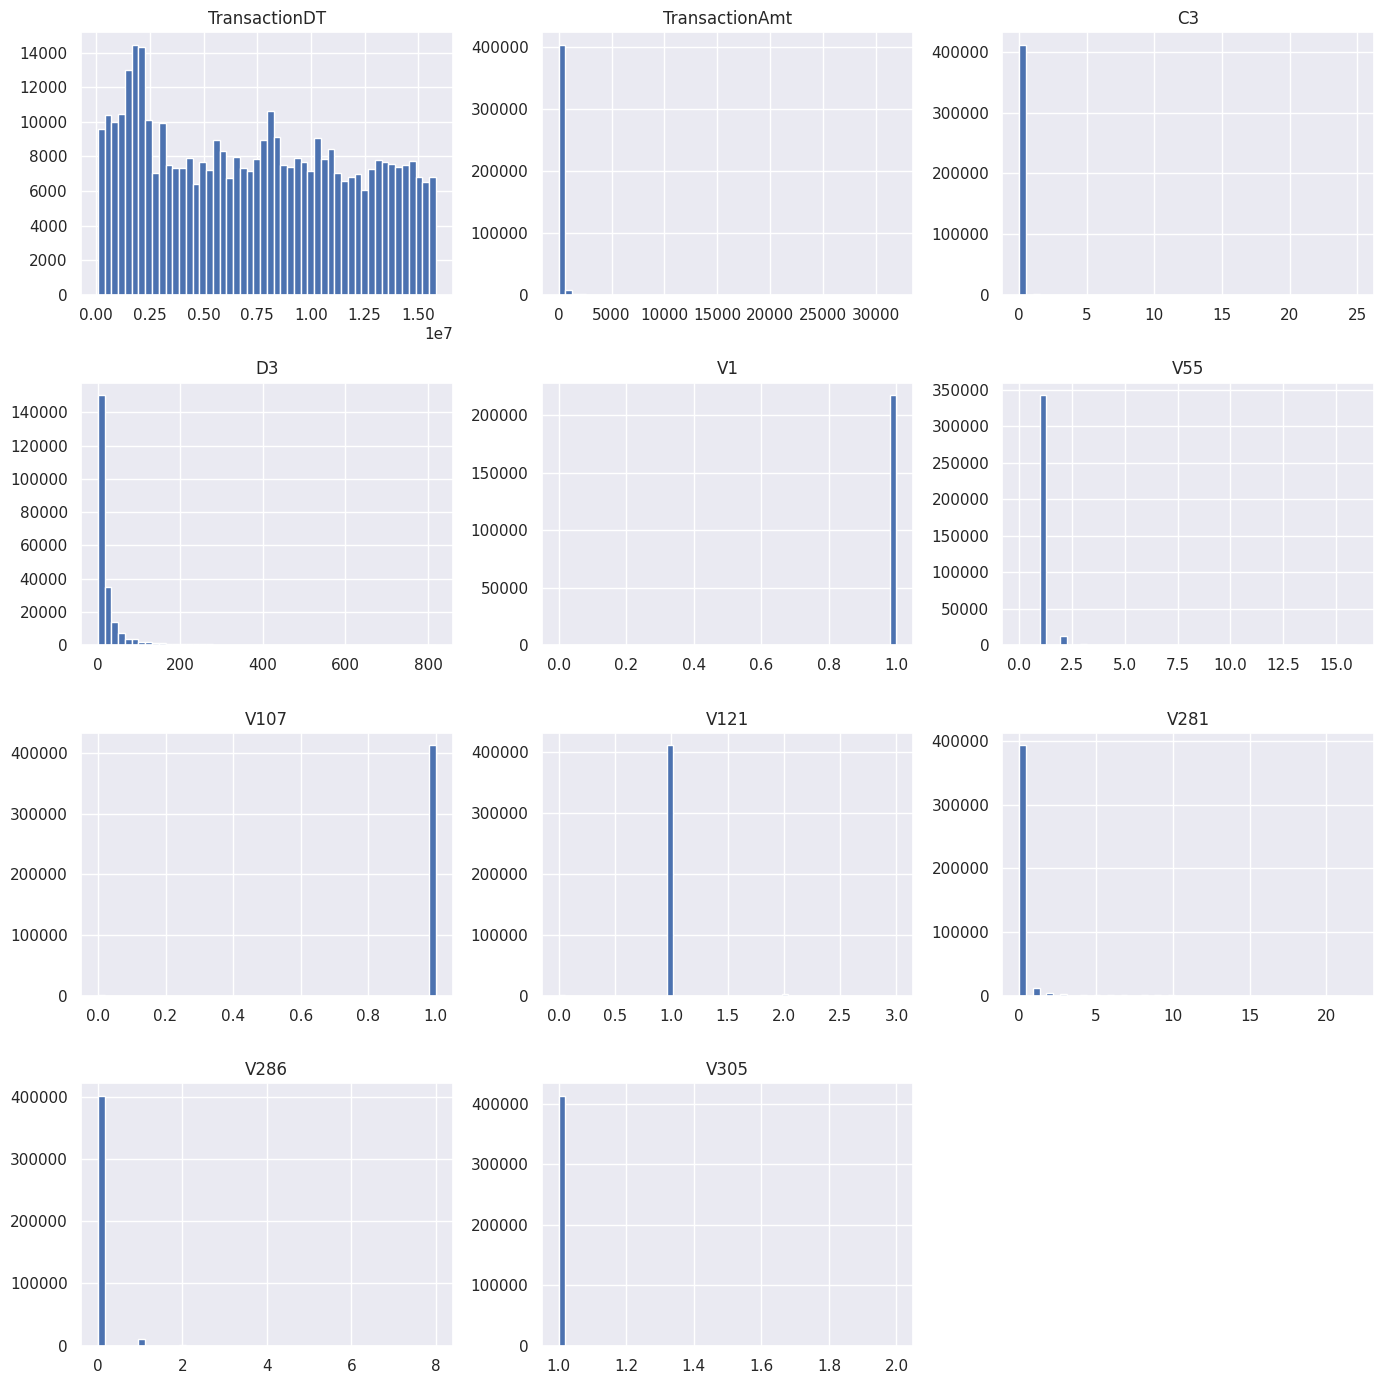

In [62]:
sns.set()
X_train[num_feats[1:]].hist(bins=50, figsize=(14,14))
plt.tight_layout()

Видим, что некоторые данные имеют выбросы. Посмотрим на графики ```boxplot```, чтобы явно убедиться в этом

In [63]:
def plt_boxplot(df, feature):
    sns.set()
    plt.figure(figsize=(10,3))
    sns.boxplot(x=df[feature])
    plt.title('Диаграмма размаха {}'.format(feature))
    plt.xlabel(feature)
    plt.show()

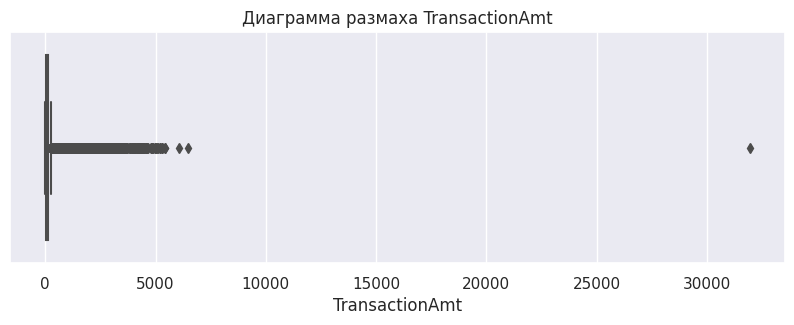

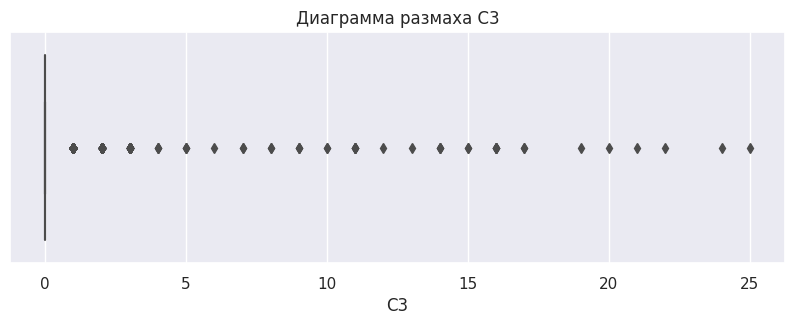

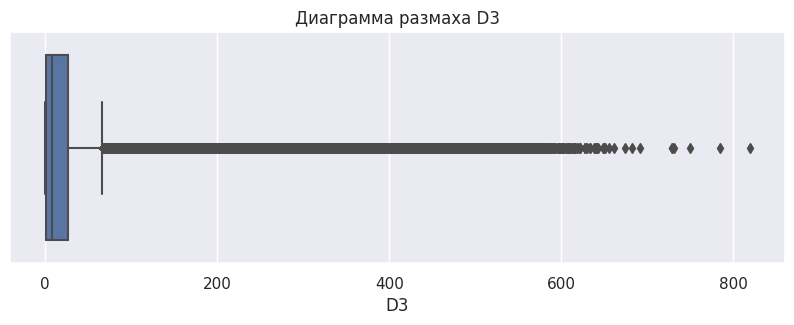

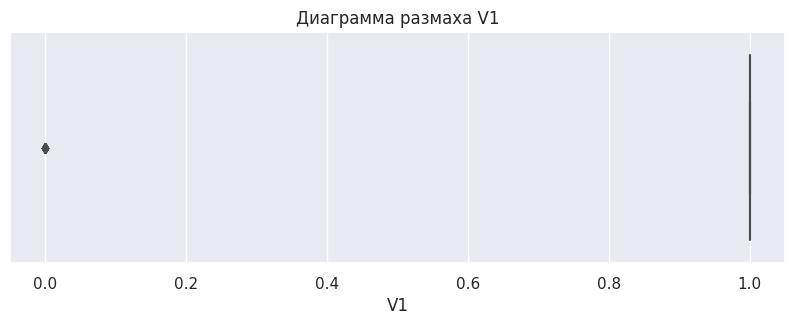

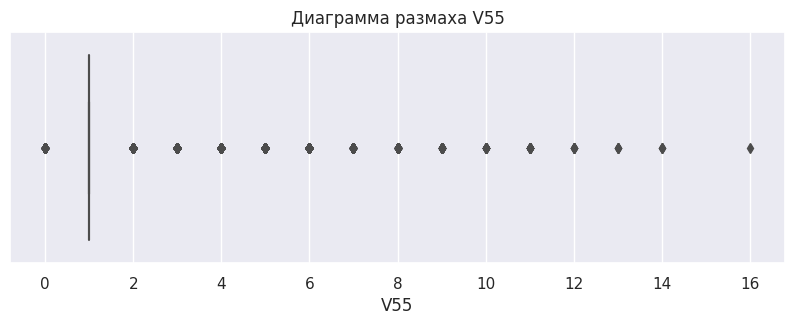

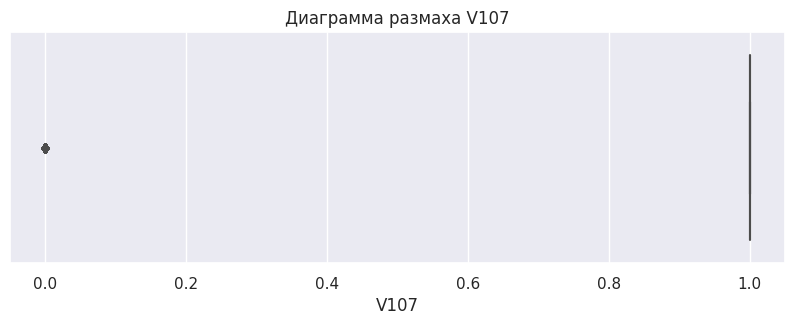

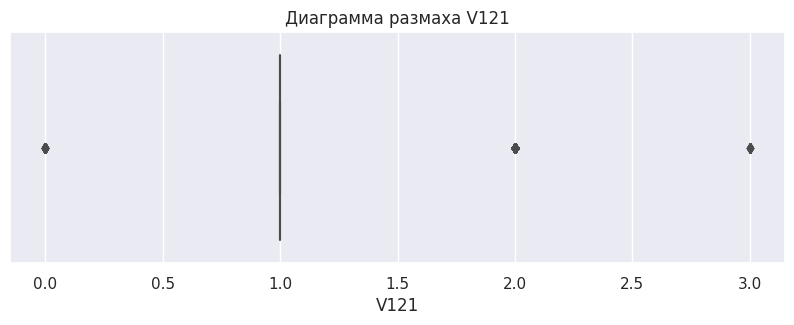

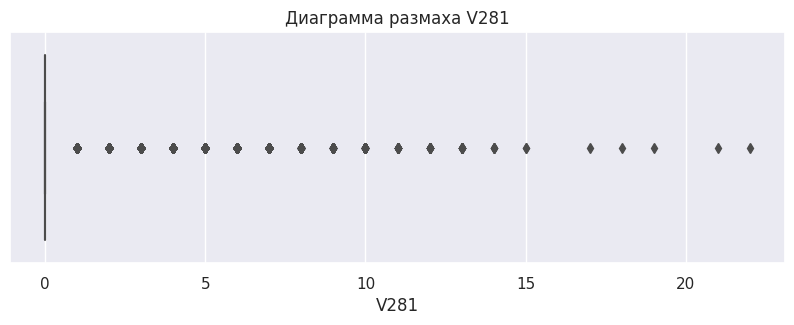

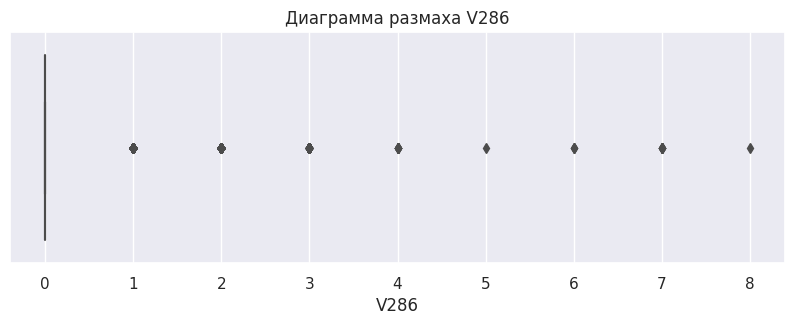

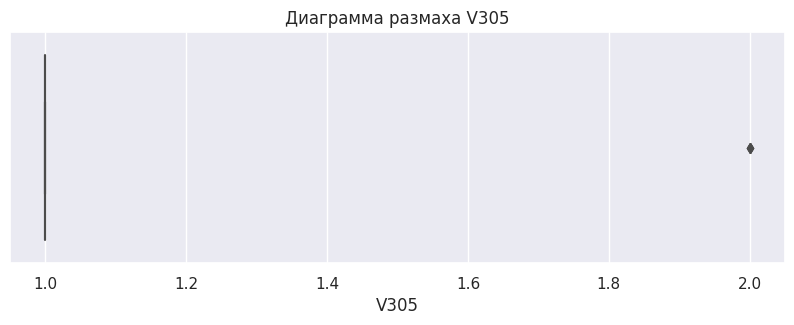

In [64]:
for feat in num_feats[2:]:
    plt_boxplot(X_train, feat)

Да, многие данные действительно имеют выбросы

### Посмотрим ещё раз на пропуски

In [65]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 413378 entries, 476450 to 249268
Data columns (total 21 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   TransactionID   413378 non-null  uint32 
 1   TransactionDT   413378 non-null  uint32 
 2   TransactionAmt  413378 non-null  float32
 3   ProductCD       413378 non-null  int64  
 4   card1           413378 non-null  uint16 
 5   card2           407132 non-null  float32
 6   card4           413378 non-null  int64  
 7   card5           410387 non-null  float32
 8   card6           413378 non-null  int64  
 9   addr1           367202 non-null  float32
 10  addr2           367202 non-null  float32
 11  P_emaildomain   413378 non-null  int64  
 12  C3              413378 non-null  float32
 13  D3              229380 non-null  float32
 14  V1              217730 non-null  float32
 15  V55             359563 non-null  float32
 16  V107            413156 non-null  float32
 17  V121      

In [66]:
X_train.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               6246
card4                  0
card5               2991
card6                  0
addr1              46176
addr2              46176
P_emaildomain          0
C3                     0
D3                183998
V1                195648
V55                53815
V107                 222
V121                 222
V281                 899
V286                   6
V305                   6
dtype: int64

Сперва заполним пропуски числовых признаков средним по колонке

Сделаем копии датасетов, чтобы ничего не поменять в исходниках

In [67]:
X_train_copy = X_train.copy()
X_valid_copy = X_valid.copy()
test_df_copy = test_df.copy()

In [68]:
num_feats

['TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'C3',
 'D3',
 'V1',
 'V55',
 'V107',
 'V121',
 'V281',
 'V286',
 'V305']

In [69]:
X_train_copy[num_feats] = X_train_copy[num_feats].fillna(
    X_train_copy[num_feats].mean())

In [70]:
X_valid_copy[num_feats] = X_valid_copy[num_feats].fillna(
    X_valid_copy[num_feats].mean())

In [71]:
test_df_copy[num_feats] = test_df_copy[num_feats].fillna(
    test_df_copy[num_feats].mean())

Пропуски в категориальных прихнаках заполним константой ```-1```

In [72]:
X_train_copy[cat_feats] = X_train_copy[cat_feats].fillna(-1)
X_valid_copy[cat_feats] = X_valid_copy[cat_feats].fillna(-1)
test_df_copy[cat_feats] = test_df_copy[cat_feats].fillna(-1)

Проверки, остались ли пропуски в данных после заполнения

In [73]:
X_train_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

In [74]:
X_valid_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

In [75]:
test_df_copy.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

#### Посмотрим на распределения признаков после заполнения пропусков

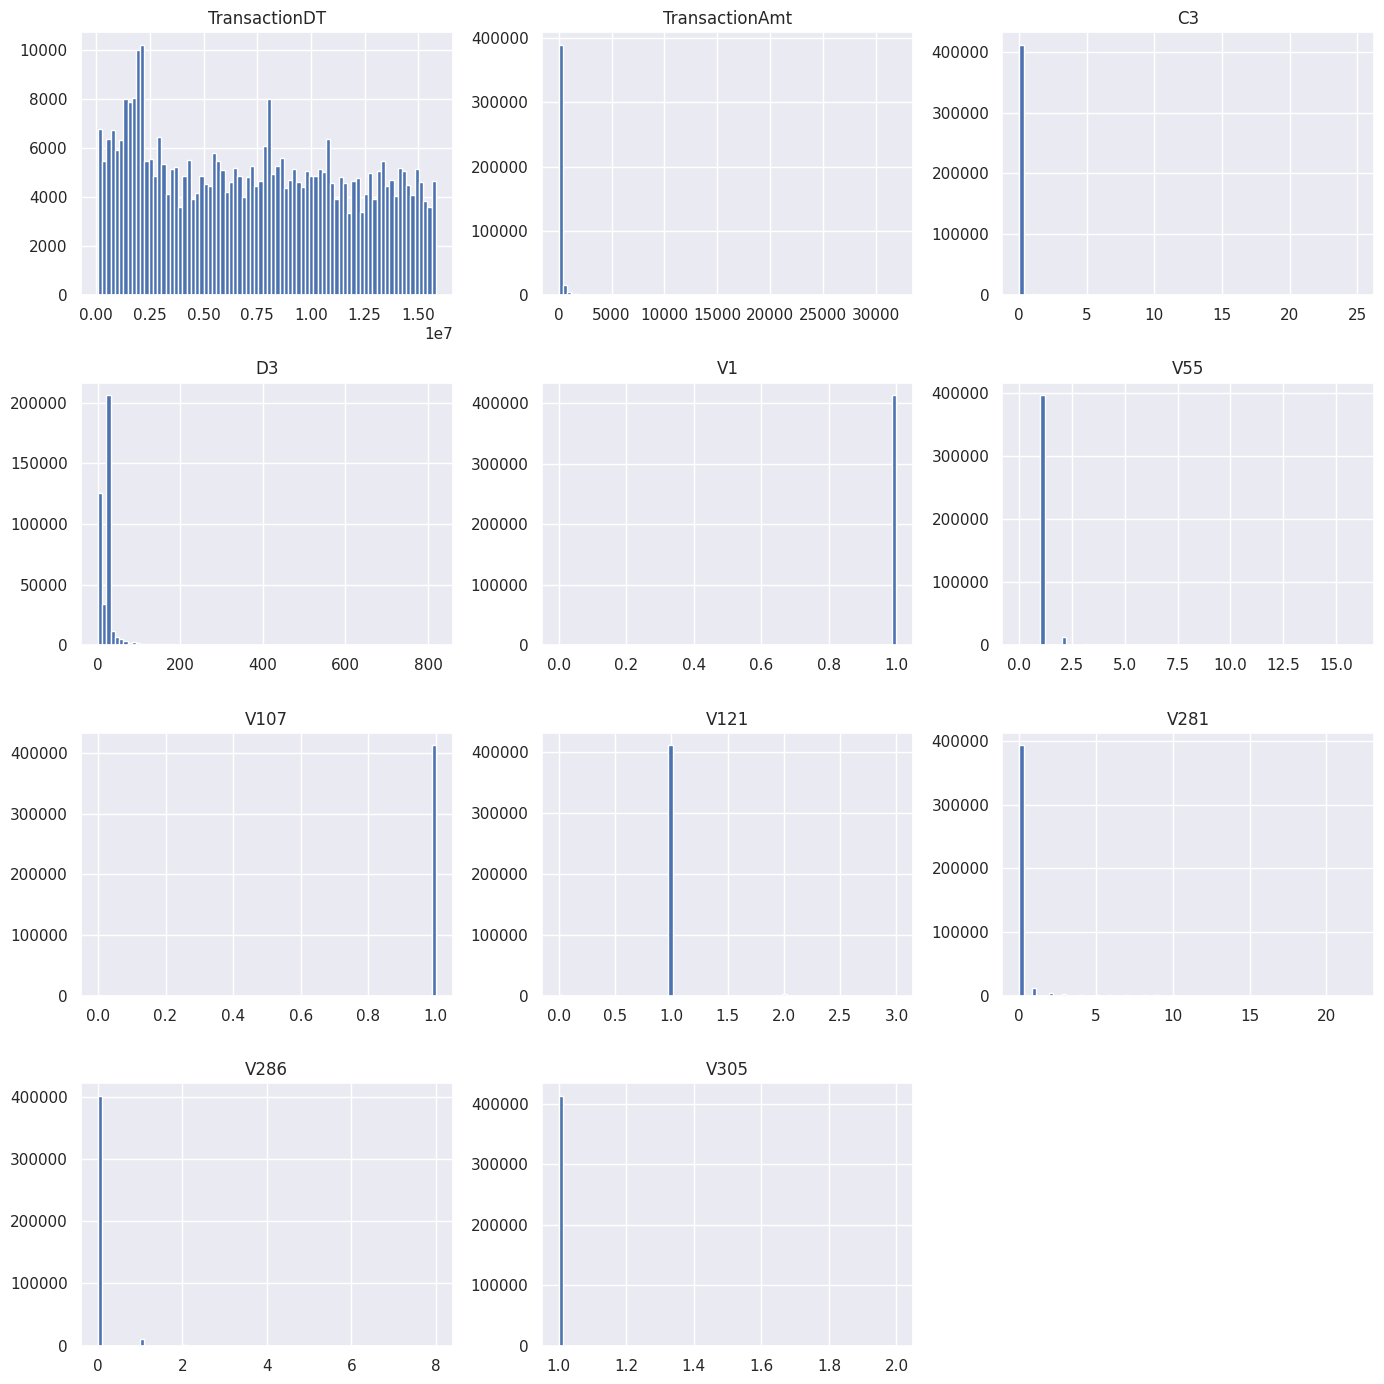

In [76]:
X_train_copy[num_feats[1:]].hist(bins=80, figsize=(14,14))
plt.tight_layout()

Видим, что распределения признаков после заполнения пропусков не изменились

#### Попробуем посмотреть на прогноз **логистической регрессии**

In [77]:
from sklearn.linear_model import LogisticRegression

In [78]:
model_LR = LogisticRegression()

model_LR.fit(X_train_copy, y_train)

LogisticRegression()

In [79]:
y_pred_valid_LR = model_LR.predict(X_valid_copy)

In [80]:
y_pred_valid_LR

array([0, 0, 0, ..., 0, 0, 0], dtype=uint8)

In [81]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR == y_valid).sum() / len(y_valid)}')

Доля верно угаданных объектов 0.9650094264006954


Отличный результат, но это на валидационной выборке, и плюс распределение ответов в нашей выборке не сбалансировано

#### Посмотрим на **матрицу ошибок**

In [82]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

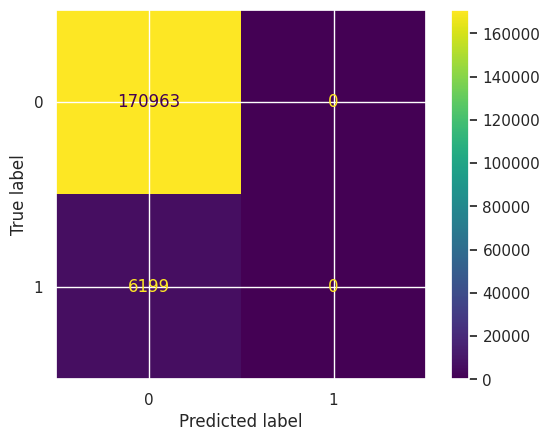

In [83]:
cm = confusion_matrix(y_valid, y_pred_valid_LR)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

#### Видим, что среди верных срабатываний не предсказано ни одного верного ответа

Посмотрим отчёт по метрикам классификации

In [84]:
print(classification_report(y_valid, y_pred_valid_LR))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    170963
           1       0.00      0.00      0.00      6199

    accuracy                           0.97    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.97      0.95    177162



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


#### Это потому что в данных большой дисбаланс классов

Так как размеры датасетов достаточно большие, уберём часть данных класса с большей долей (валидные) из нашей выборки

In [85]:
X_train_copy

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
476450        3463450       12334619       57.950001          4  13249  111.0   
257888        3244888        6193795      107.949997          4  10045  114.0   
292700        3279700        7231162       12.247000          0  16136  204.0   
440564        3427564       11170518       39.000000          4  10049  555.0   
63257         3050257        1443611       35.000000          4  17188  321.0   
...               ...            ...             ...        ...    ...    ...   
472312        3459312       12189740      226.000000          4  13249  111.0   
558763        3545763       14783844      210.949997          4   9515  492.0   
407699        3394699       10288866       90.328003          0  17392  555.0   
17279         3004279         455563      159.949997          4   7664  490.0   
249268        3236268        5943058     1533.349976          4   5938  111.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3          D3  \
476450      4  226.0      2  264.0  ...             16  0.0    3.000000   
257888      4  226.0      2  512.0  ...             16  0.0   73.000000   
292700      4  138.0      2   -1.0  ...             16  0.0   24.000000   
440564      4  226.0      2  191.0  ...             32  0.0    5.000000   
63257       4  226.0      2  299.0  ...             16  0.0   28.322317   
...       ...    ...    ...    ...  ...            ...  ...         ...   
472312      4  226.0      2  264.0  ...              2  0.0   28.322317   
558763      4  226.0      2  343.0  ...              1  0.0  191.000000   
407699      2  102.0      1   -1.0  ...             38  0.0   28.322317   
17279       4  226.0      2  264.0  ...             54  0.0   28.322317   
249268      4  162.0      1  272.0  ...              3  0.0   28.322317   

             V1  V55  V107  V121  V281  V286  V305  
476450  1.00000  1.0   1.0   1.0   0.0   0.0   1.0  
257888  1.00000  1.0   1.0   1.0   0.0   0.0   1.0  
292700  0.99994  1.0   1.0   1.0   0.0   0.0   1.0  
440564  0.99994  1.0   1.0   1.0   2.0   0.0   1.0  
63257   1.00000  1.0   1.0   1.0   0.0   0.0   1.0  
...         ...  ...   ...   ...   ...   ...   ...  
472312  0.99994  1.0   1.0   1.0   0.0   0.0   1.0  
558763  1.00000  1.0   1.0   1.0   0.0   0.0   1.0  
407699  0.99994  1.0   1.0   1.0   0.0   0.0   1.0  
17279   0.99994  1.0   1.0   1.0   0.0   0.0   1.0  
249268  1.00000  1.0   1.0   1.0   0.0   0.0   1.0  

[413378 rows x 21 columns]

Мы помним, что распределение целевых меток в наших данных:
- валидные транзакции - ```96,5``` %
- мошеннические транзакции - ```3,5``` %

Попробуем убрать число копий мошеннических транзакций так, чтобы соотношение классов стало равным ```70```% (валидные) к ```30``` % (мошеннические)

Посчитаем сколько записей транзакций от **общего размера обучающей выборки** составляют ```70``` %:

In [86]:
num_y_train_70_prct = len(y_train) * 0.7
int(num_y_train_70_prct)

289364

Посмотрим сколько записей **валидных транзакций** надо удалить из обучающего датасета, чтобы соотношение долей ответов стало 70 к 30:

- num_trxs       - 100 %
- num_valid_trxs - 70 %
- num_fraud_trxs - 30%

In [87]:
not_fraud_trxs_count = len(y_train[y_train==0])
fraud_trxs_count = len(y_train[y_train==1])
# посмотрим какое общее число транзакций должно быть, 
# чтобы мы смогли достичь нужного соотношения
balanced_trxs_count = int(fraud_trxs_count * 100 / 30)
print('not_fraud_trxs_count: ', not_fraud_trxs_count)
print('fraud_trxs_count: ', fraud_trxs_count)
print('balanced_trxs_count: ', balanced_trxs_count)

not_fraud_trxs_count:  398914
fraud_trxs_count:  14464
balanced_trxs_count:  48213


Видим, что **сбалансированое кол-во транзакций было бы - 48213**, но мы не можем сократить число транзакций до такого кол-ва, т.к. данных останется слишком мало, что плохо скажется на прогнозах по тестовым данным

Поэтому необходимо **добавить** необходимое число копий **мошеннических транзакций** в датасеты

In [88]:
trxs_count = len(y_train)
opt_fraud_trxs_count = int(trxs_count * 30 / 100)
print('optimal fraud trxs count: ', opt_fraud_trxs_count)

optimal fraud trxs count:  124013


Посчитаем насколько копий нужно увеличить кол-во мошеннических записей

In [89]:
diff_fraud_trxs_count = opt_fraud_trxs_count - fraud_trxs_count
diff_fraud_trxs_count

109549

Нужно добавить **109549** записей класса 1

In [90]:
int(opt_fraud_trxs_count / fraud_trxs_count)

8

#### т.е. увеличим число мошеннических транзакций примерно в 8 раз

In [91]:
y_train_fraud_increased = pd.concat([y_train[y_train==1] for i in range(7)])
y_train_fraud_increased

400745    1
365635    1
390638    1
310038    1
429713    1
         ..
283162    1
448422    1
196895    1
260960    1
385880    1
Name: isFraud, Length: 101248, dtype: uint8

In [92]:
y_train_increased = pd.concat([y_train, y_train_fraud_increased])
y_train_increased

476450    0
257888    0
292700    0
440564    0
63257     0
         ..
283162    1
448422    1
196895    1
260960    1
385880    1
Name: isFraud, Length: 514626, dtype: uint8

Посмотрим теперь на соотношение ответов

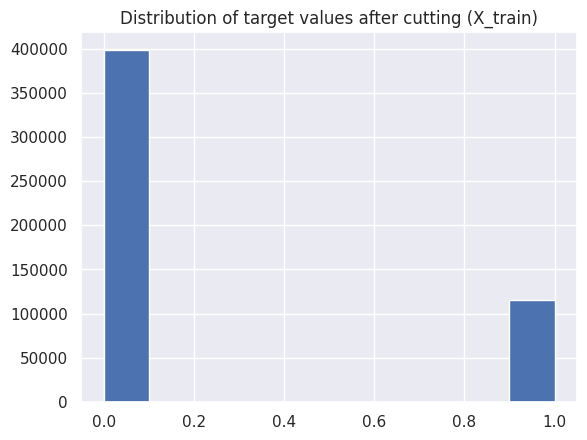

In [93]:
plt.hist(y_train_increased)
plt.title('Distribution of target values after cutting (X_train)')
plt.show()

Видим, как поменялось соотношение ответов

Увеличим кол-во соответствующих данных в датасете ```X_train```

In [94]:
before_inc = y_train[y_train==1].index
before_inc

Index([400745, 365635, 390638, 310038, 429713, 290866, 525824,  20031, 455069,
       394864,
       ...
       368965, 460546, 188520, 146122, 219473, 283162, 448422, 196895, 260960,
       385880],
      dtype='int64', length=14464)

In [95]:
y_train_indexes = list(y_train_increased[y_train_increased==1].index[len(before_inc):])
len(y_train_indexes)

101248

In [96]:
X_train_increased = pd.concat([X_train, X_train.loc[y_train_indexes]])
X_train_increased

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
476450        3463450       12334619       57.950001          4  13249  111.0   
257888        3244888        6193795      107.949997          4  10045  114.0   
292700        3279700        7231162       12.247000          0  16136  204.0   
440564        3427564       11170518       39.000000          4  10049  555.0   
63257         3050257        1443611       35.000000          4  17188  321.0   
...               ...            ...             ...        ...    ...    ...   
283162        3270162        6910394      100.000000          1   6019  583.0   
448422        3435422       11414327      150.000000          1   2788  143.0   
196895        3183895        4444451       70.135002          0  15063    NaN   
260960        3247960        6279792      150.000000          3   6019  583.0   
385880        3372880        9669889      311.950012          4  12253  170.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3    D3   V1  V55  \
476450      4  226.0      2  264.0  ...             16  0.0   3.0  1.0  1.0   
257888      4  226.0      2  512.0  ...             16  0.0  73.0  1.0  1.0   
292700      4  138.0      2    NaN  ...             16  0.0  24.0  NaN  1.0   
440564      4  226.0      2  191.0  ...             32  0.0   5.0  NaN  1.0   
63257       4  226.0      2  299.0  ...             16  0.0   NaN  1.0  1.0   
...       ...    ...    ...    ...  ...            ...  ...   ...  ...  ...   
283162      4  226.0      1  325.0  ...             16  0.0   NaN  NaN  NaN   
448422      4  226.0      2  264.0  ...              1  0.0   NaN  NaN  NaN   
196895      4  226.0      1    NaN  ...             16  0.0   NaN  NaN  1.0   
260960      4  226.0      1  330.0  ...             32  0.0   NaN  NaN  NaN   
385880      4  226.0      1  225.0  ...             16  0.0  47.0  1.0  2.0   

        V107  V121  V281  V286  V305  
476450   1.0   1.0   0.0   0.0   1.0  
257888   1.0   1.0   0.0   0.0   1.0  
292700   1.0   1.0   0.0   0.0   1.0  
440564   1.0   1.0   2.0   0.0   1.0  
63257    1.0   1.0   0.0   0.0   1.0  
...      ...   ...   ...   ...   ...  
283162   1.0   1.0   0.0   0.0   1.0  
448422   1.0   1.0   0.0   0.0   1.0  
196895   1.0   1.0   0.0   0.0   1.0  
260960   1.0   1.0   0.0   0.0   1.0  
385880   1.0   1.0   0.0   0.0   1.0  

[514626 rows x 21 columns]

In [97]:
y_train_increased.shape

(514626,)

In [98]:
X_train_increased.shape

(514626, 21)

In [99]:
X_train_increased.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8346
card4                  0
card5               4083
card6                  0
addr1              83724
addr2              83724
P_emaildomain          0
C3                     0
D3                237849
V1                266831
V55                75760
V107                 306
V121                 306
V281                1116
V286                  13
V305                  13
dtype: int64

Снова заполним пропуски в данных:
- числовые признаки средними значениями по столбцам
- категориальные - ```-1```

In [100]:
X_train_increased[num_feats] = X_train_increased[num_feats].fillna(
    X_train_increased[num_feats].mean())

In [101]:
X_train_increased[cat_feats] = X_train_increased[cat_feats].fillna(-1)

In [102]:
X_train_increased.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

### Проделаем вышеперечисленные действия с увеличением доли **мошеннических записей** для валидационного датасета

In [103]:
y_valid_fraud_increased = pd.concat([y_valid[y_valid==1] for i in range(7)])
y_valid_fraud_increased

174832    1
314530    1
5381      1
480747    1
298494    1
         ..
103261    1
358734    1
29078     1
576452    1
452684    1
Name: isFraud, Length: 43393, dtype: uint8

In [104]:
y_valid_increased = pd.concat([y_valid, y_valid_fraud_increased])
y_valid_increased

249789    0
296417    0
589439    0
422091    0
32528     0
         ..
103261    1
358734    1
29078     1
576452    1
452684    1
Name: isFraud, Length: 220555, dtype: uint8

Посмотрим на соотношение ответов валидационного датасета

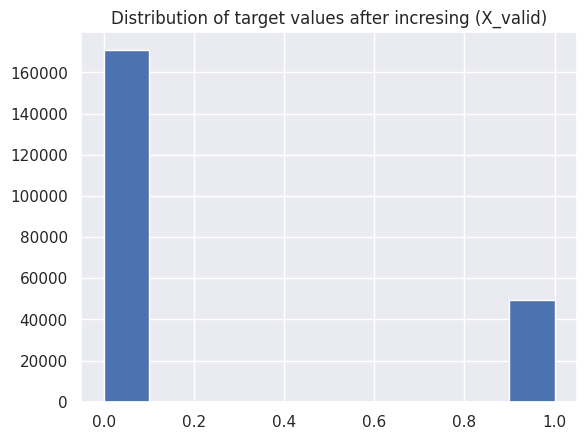

In [105]:
plt.hist(y_valid_increased)
plt.title('Distribution of target values after incresing (X_valid)')
plt.show()

In [106]:
before_inc = y_valid[y_valid==1].index
y_valid_indexes = list(y_valid_increased[y_valid_increased==1].index[len(before_inc):])
X_valid_increased = pd.concat([X_valid, X_valid.loc[y_valid_indexes]])
X_valid_increased

TransactionID  TransactionDT  TransactionAmt  ProductCD  card1  card2  \
249789        3236789        5951813      189.949997          4  13906  369.0   
296417        3283417        7326502       87.949997          4   8406  264.0   
589439        3576439       15788784      150.000000          1   1724  583.0   
422091        3409091       10692050       97.000000          4  17396  321.0   
32528         3019528         796841       59.000000          4  13307  428.0   
...               ...            ...             ...        ...    ...    ...   
103261        3090261        2062630      206.000000          4  17188  321.0   
358734        3345734        8889464       16.857000          0  15257  375.0   
29078         3016078         745883       77.000000          4  15066  170.0   
576452        3563452       15336414       35.000000          3   9500  321.0   
452684        3439684       11561406       44.000000          4  17111  555.0   

        card4  card5  card6  addr1  ...  P_emaildomain   C3    D3   V1  V55  \
249789      2  117.0      2  325.0  ...             25  0.0   NaN  1.0  1.0   
296417      4  226.0      2  337.0  ...             16  0.0  97.0  1.0  1.0   
589439      4  226.0      1  325.0  ...             28  0.0   NaN  NaN  NaN   
422091      4  195.0      1  299.0  ...              2  0.0  34.0  1.0  1.0   
32528       4  166.0      2  264.0  ...              2  0.0   NaN  NaN  1.0   
...       ...    ...    ...    ...  ...            ...  ...   ...  ...  ...   
103261      4  226.0      2  299.0  ...             16  0.0   0.0  1.0  1.0   
358734      2  224.0      2    NaN  ...             16  0.0   NaN  NaN  1.0   
29078       2  102.0      1  472.0  ...             32  0.0   NaN  NaN  1.0   
576452      4  226.0      2  485.0  ...             32  0.0   NaN  NaN  NaN   
452684      4  226.0      2  181.0  ...             54  0.0  35.0  NaN  1.0   

        V107  V121  V281  V286  V305  
249789   1.0   1.0   0.0   0.0   1.0  
296417   1.0   1.0   0.0   0.0   1.0  
589439   1.0   1.0   0.0   0.0   1.0  
422091   1.0   1.0   0.0   0.0   1.0  
32528    1.0   1.0   0.0   0.0   1.0  
...      ...   ...   ...   ...   ...  
103261   1.0   1.0   0.0   0.0   1.0  
358734   1.0   1.0   0.0   0.0   1.0  
29078    1.0   1.0   0.0   0.0   1.0  
576452   1.0   1.0   0.0   0.0   1.0  
452684   1.0   1.0   0.0   0.0   1.0  

[220555 rows x 21 columns]

In [107]:
y_valid_increased.shape

(220555,)

In [108]:
X_valid_increased.shape

(220555, 21)

Заполним пропуски в валидационном датасете

In [109]:
X_valid_increased.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               3548
card4                  0
card5               1646
card6                  0
addr1              36169
addr2              36169
P_emaildomain          0
C3                     0
D3                102337
V1                114355
V55                32899
V107                 127
V121                 127
V281                 475
V286                  13
V305                  13
dtype: int64

In [110]:
X_valid_increased[num_feats] = X_valid_increased[num_feats].fillna(
    X_valid_increased[num_feats].mean())

In [111]:
X_valid_increased[cat_feats] = X_valid_increased[cat_feats].fillna(-1)

In [112]:
X_valid_increased.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

Заполним пропуски в тестовом датасете

In [113]:
test_df.isna().sum()

TransactionID          0
TransactionDT          0
TransactionAmt         0
ProductCD              0
card1                  0
card2               8654
card4                  0
card5               4547
card6                  0
addr1              65609
addr2              65609
P_emaildomain          0
C3                     3
D3                203142
V1                176518
V55                12899
V107                   0
V121                   0
V281                6031
V286                   3
V305                   3
dtype: int64

In [114]:
num_feats

['TransactionID',
 'TransactionDT',
 'TransactionAmt',
 'C3',
 'D3',
 'V1',
 'V55',
 'V107',
 'V121',
 'V281',
 'V286',
 'V305']

In [115]:
test_df[num_feats[1:]] = test_df[num_feats[1:]].fillna(test_df[num_feats[1:]].mean())
test_df[cat_feats] = test_df[cat_feats].fillna(-1)
test_df.isna().sum()

TransactionID     0
TransactionDT     0
TransactionAmt    0
ProductCD         0
card1             0
card2             0
card4             0
card5             0
card6             0
addr1             0
addr2             0
P_emaildomain     0
C3                0
D3                0
V1                0
V55               0
V107              0
V121              0
V281              0
V286              0
V305              0
dtype: int64

#### После добавления данных в датасеты посмотрим снова на прогноз модели логистической регрессии:

In [116]:
model_LR2 = LogisticRegression()
model_LR2.fit(X_train_increased, y_train_increased)

LogisticRegression()

In [117]:
y_pred_valid_LR2 = model_LR2.predict(X_valid_increased)

In [118]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR2 == y_valid_increased).sum()/len(y_valid_increased)}')

Доля верно угаданных объектов 0.7751490557910725


Видим, что качество прогнозов ухудшилось. Посмотрим на матрицу ошибок и отчёт классификации

Напишем функцию для построения матрицы ошибок:

In [119]:
def conf_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

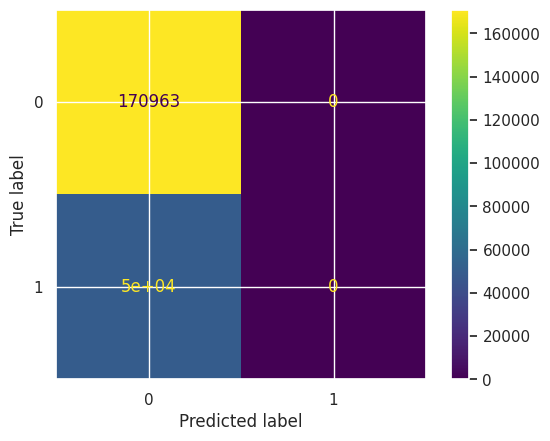

In [120]:
conf_matrix(y_valid_increased, y_pred_valid_LR2)

In [121]:
print(classification_report(y_valid_increased, y_pred_valid_LR2))

              precision    recall  f1-score   support

           0       0.78      1.00      0.87    170963
           1       0.00      0.00      0.00     49592

    accuracy                           0.78    220555
   macro avg       0.39      0.50      0.44    220555
weighted avg       0.60      0.78      0.68    220555



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Попробуем сделать прогноз на исходной выборке ```X_valid_copy``` с дисбалансом в данных

In [122]:
y_pred_valid_LR2 = model_LR2.predict(X_valid_copy)

In [123]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR2 == y_valid).sum()/len(y_valid)}')

Доля верно угаданных объектов 0.9650094264006954


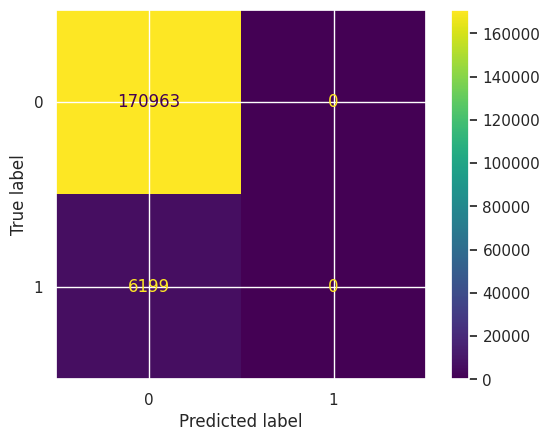

In [124]:
conf_matrix(y_valid, y_pred_valid_LR2)

In [125]:
print(classification_report(y_valid, y_pred_valid_LR2))

              precision    recall  f1-score   support

           0       0.97      1.00      0.98    170963
           1       0.00      0.00      0.00      6199

    accuracy                           0.97    177162
   macro avg       0.48      0.50      0.49    177162
weighted avg       0.93      0.97      0.95    177162



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Видим, что среди верных срабатываний доля верно предсказанных значений мошеннических транзакций увеличилась, но число ошибок также очень большое

#### Но попробуем сбалансировать значения двух выборок 50 на 50. Уменьшим кол-во записей в датасете с классом 0

In [126]:
opt_fraud_trxs_count

124013

In [127]:
not_fraud_trxs_count

398914

In [128]:
balanced_y_train_0 = y_train[y_train==0][:opt_fraud_trxs_count]
balanced_y_train_0

476450    0
257888    0
292700    0
440564    0
63257     0
         ..
60780     0
405486    0
64470     0
311024    0
396123    0
Name: isFraud, Length: 124013, dtype: uint8

In [129]:
y_train_fraud_increased = pd.concat([y_train[y_train==1] for i in range(8)])
y_train_fraud_increased

400745    1
365635    1
390638    1
310038    1
429713    1
         ..
283162    1
448422    1
196895    1
260960    1
385880    1
Name: isFraud, Length: 115712, dtype: uint8

In [130]:
y_train_balanced = pd.concat([balanced_y_train_0, y_train_fraud_increased])
y_train_balanced

476450    0
257888    0
292700    0
440564    0
63257     0
         ..
283162    1
448422    1
196895    1
260960    1
385880    1
Name: isFraud, Length: 239725, dtype: uint8

Посмотрим теперь на соотношение ответов

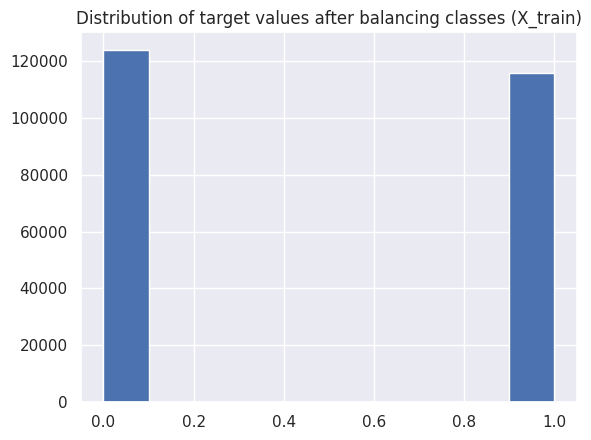

In [131]:
plt.hist(y_train_balanced)
plt.title('Distribution of target values after balancing classes (X_train)')
plt.show()

In [132]:
y_train_balanced.shape

(239725,)

In [133]:
X_train_balanced = X_train_copy.loc[y_train_balanced.index]

In [134]:
X_train_balanced.shape

(239725, 21)

In [135]:
test_df.shape

(506691, 21)

In [136]:
model_LR4 = LogisticRegression()
model_LR4.fit(X_train_balanced, y_train_balanced)

LogisticRegression()

In [137]:
y_pred_valid_LR4 = model_LR4.predict(X_valid_copy)

In [138]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR4 == y_valid).sum() / len(y_valid)}')

Доля верно угаданных объектов 0.7545523306352379


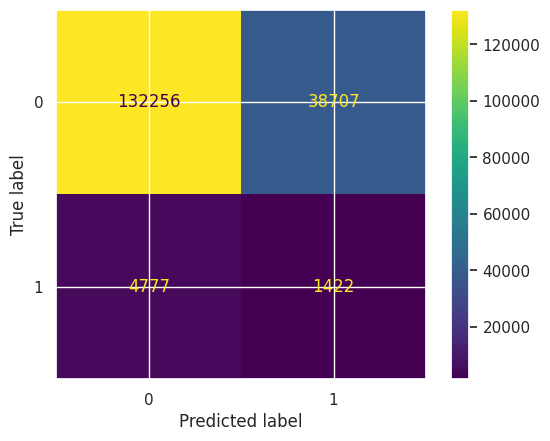

In [139]:
conf_matrix(y_valid, y_pred_valid_LR4)

In [140]:
print(classification_report(y_valid, y_pred_valid_LR4))

              precision    recall  f1-score   support

           0       0.97      0.77      0.86    170963
           1       0.04      0.23      0.06      6199

    accuracy                           0.75    177162
   macro avg       0.50      0.50      0.46    177162
weighted avg       0.93      0.75      0.83    177162



Видим, что качество после уравнивания долей ответов обоих классов по прежнему остаётся не очень хорошим, хоть и полнота для класса 1 выросла

#### Так как линейные модели чувствительны к порядкам признаков, необходимо произвести **масштабирование признаков**

In [141]:
from sklearn.preprocessing import StandardScaler

Уберём из датасетов признак ```TransactionID```. Но сохраним этот признак в отдельную переменную для тестовой выборки - это нужно для отправки данных на соревнование

In [142]:
X_train_balanced2 = X_train_balanced.drop(columns=['TransactionID'])
X_train_balanced2

TransactionDT  TransactionAmt  ProductCD  card1  card2  card4  card5  \
476450       12334619       57.950001          4  13249  111.0      4  226.0   
257888        6193795      107.949997          4  10045  114.0      4  226.0   
292700        7231162       12.247000          0  16136  204.0      4  138.0   
440564       11170518       39.000000          4  10049  555.0      4  226.0   
63257         1443611       35.000000          4  17188  321.0      4  226.0   
...               ...             ...        ...    ...    ...    ...    ...   
283162        6910394      100.000000          1   6019  583.0      4  226.0   
448422       11414327      150.000000          1   2788  143.0      4  226.0   
196895        4444451       70.135002          0  15063   -1.0      4  226.0   
260960        6279792      150.000000          3   6019  583.0      4  226.0   
385880        9669889      311.950012          4  12253  170.0      4  226.0   

        card6  addr1  addr2  P_emaildomain   C3         D3       V1       V55  \
476450      2  264.0   87.0             16  0.0   3.000000  1.00000  1.000000   
257888      2  512.0   87.0             16  0.0  73.000000  1.00000  1.000000   
292700      2   -1.0   -1.0             16  0.0  24.000000  0.99994  1.000000   
440564      2  191.0   87.0             32  0.0   5.000000  0.99994  1.000000   
63257       2  299.0   87.0             16  0.0  28.322317  1.00000  1.000000   
...       ...    ...    ...            ...  ...        ...      ...       ...   
283162      1  325.0   87.0             16  0.0  28.322317  0.99994  1.067182   
448422      2  264.0   87.0              1  0.0  28.322317  0.99994  1.067182   
196895      1   -1.0   -1.0             16  0.0  28.322317  0.99994  1.000000   
260960      1  330.0   87.0             32  0.0  28.322317  0.99994  1.067182   
385880      1  225.0   87.0             16  0.0  47.000000  1.00000  2.000000   

        V107  V121  V281  V286  V305  
476450   1.0   1.0   0.0   0.0   1.0  
257888   1.0   1.0   0.0   0.0   1.0  
292700   1.0   1.0   0.0   0.0   1.0  
440564   1.0   1.0   2.0   0.0   1.0  
63257    1.0   1.0   0.0   0.0   1.0  
...      ...   ...   ...   ...   ...  
283162   1.0   1.0   0.0   0.0   1.0  
448422   1.0   1.0   0.0   0.0   1.0  
196895   1.0   1.0   0.0   0.0   1.0  
260960   1.0   1.0   0.0   0.0   1.0  
385880   1.0   1.0   0.0   0.0   1.0  

[239725 rows x 20 columns]

In [143]:
X_valid_copy2 = X_valid_copy.drop(columns=['TransactionID'])
X_valid_copy2

TransactionDT  TransactionAmt  ProductCD  card1  card2  card4  card5  \
249789        5951813      189.949997          4  13906  369.0      2  117.0   
296417        7326502       87.949997          4   8406  264.0      4  226.0   
589439       15788784      150.000000          1   1724  583.0      4  226.0   
422091       10692050       97.000000          4  17396  321.0      4  195.0   
32528          796841       59.000000          4  13307  428.0      4  166.0   
...               ...             ...        ...    ...    ...    ...    ...   
559622       14830954      106.000000          3  15775  481.0      2  102.0   
85552         1809249       50.000000          1   3821  111.0      2  219.0   
122974        2413519       16.674000          0  15885  545.0      4  138.0   
414668       10456561       82.949997          4  11710  479.0      4  226.0   
440391       11156097      236.949997          4   6595  127.0      2  117.0   

        card6  addr1  addr2  P_emaildomain   C3         D3        V1  \
249789      2  325.0   87.0             25  0.0  28.392431  1.000000   
296417      2  337.0   87.0             16  0.0  97.000000  1.000000   
589439      1  325.0   87.0             28  0.0  28.392431  0.999957   
422091      1  299.0   87.0              2  0.0  34.000000  1.000000   
32528       2  264.0   87.0              2  0.0  28.392431  0.999957   
...       ...    ...    ...            ...  ...        ...       ...   
559622      1  330.0   87.0             32  0.0   0.000000  0.999957   
85552       1  330.0   87.0             16  0.0  28.392431  0.999957   
122974      2   -1.0   -1.0             19  0.0  28.392431  0.999957   
414668      1  143.0   87.0             16  0.0  26.000000  1.000000   
440391      2  325.0   87.0             54  0.0  28.392431  0.999957   

             V55  V107  V121  V281  V286  V305  
249789  1.000000   1.0   1.0   0.0   0.0   1.0  
296417  1.000000   1.0   1.0   0.0   0.0   1.0  
589439  1.068813   1.0   1.0   0.0   0.0   1.0  
422091  1.000000   1.0   1.0   0.0   0.0   1.0  
32528   1.000000   1.0   1.0   0.0   0.0   1.0  
...          ...   ...   ...   ...   ...   ...  
559622  1.000000   1.0   1.0   0.0   0.0   1.0  
85552   1.068813   1.0   1.0   0.0   0.0   1.0  
122974  1.000000   1.0   1.0   0.0   0.0   1.0  
414668  1.000000   1.0   1.0   0.0   0.0   1.0  
440391  1.000000   1.0   1.0   0.0   0.0   1.0  

[177162 rows x 20 columns]

In [144]:
transactionIDs_test = test_df['TransactionID']
test_df = test_df.drop(columns=['TransactionID'])
test_df

TransactionDT  TransactionAmt  ProductCD  card1  card2  card4  card5  \
0            18403224       31.950001          4  10409  111.0      4  226.0   
1            18403263       49.000000          4   4272  111.0      4  226.0   
2            18403310      171.000000          4   4476  574.0      4  226.0   
3            18403310      284.950012          4  10989  360.0      4  166.0   
4            18403317       67.949997          4  18018  452.0      2  117.0   
...               ...             ...        ...    ...    ...    ...    ...   
506686       34214279       94.679001          0  13832  375.0      2  224.0   
506687       34214287       12.173000          0   3154  408.0      2  224.0   
506688       34214326       49.000000          4  16661  490.0      4  226.0   
506689       34214337      202.000000          4  16621  516.0      2  224.0   
506690       34214345       24.346001          0   5713  168.0      4  147.0   

        card6  addr1  addr2  P_emaildomain   C3         D3        V1  V55  \
0           2  170.0   87.0             16  0.0  27.000000  1.000000  1.0   
1           2  299.0   87.0              2  0.0   7.000000  1.000000  1.0   
2           2  472.0   87.0             19  0.0  10.000000  1.000000  1.0   
3           2  205.0   87.0             16  0.0  41.000000  1.000000  1.0   
4           2  264.0   87.0             16  0.0   0.000000  1.000000  1.0   
...       ...    ...    ...            ...  ...        ...       ...  ...   
506686      2  284.0   60.0             16  0.0  33.394726  0.999997  1.0   
506687      2   -1.0   -1.0             19  0.0  16.000000  0.999997  2.0   
506688      2  327.0   87.0             19  0.0  33.394726  1.000000  1.0   
506689      2  177.0   87.0             19  0.0  33.394726  1.000000  1.0   
506690      1   -1.0   -1.0             19  0.0  33.394726  0.999997  1.0   

        V107  V121  V281  V286  V305  
0        1.0   1.0   0.0   0.0   1.0  
1        1.0   1.0   0.0   0.0   1.0  
2        1.0   1.0   0.0   0.0   1.0  
3        1.0   1.0   0.0   0.0   1.0  
4        1.0   1.0   0.0   1.0   1.0  
...      ...   ...   ...   ...   ...  
506686   1.0   1.0   0.0   0.0   1.0  
506687   1.0   1.0   1.0   0.0   1.0  
506688   1.0   1.0   0.0   0.0   1.0  
506689   1.0   1.0   0.0   0.0   1.0  
506690   1.0   1.0   0.0   0.0   1.0  

[506691 rows x 20 columns]

In [145]:
scaler = StandardScaler()
scaler.fit(X_train_balanced2, y_train_balanced)
X_train_sc = pd.DataFrame(scaler.transform(X_train_balanced2), 
                          index=X_train_balanced2.index,
                          columns=X_train_balanced2.columns)
X_valid_sc = pd.DataFrame(scaler.transform(X_valid_copy2), 
                         index=X_valid_copy2.index,
                         columns=X_valid_copy2.columns)

In [146]:
test_df_sc = pd.DataFrame(scaler.transform(test_df),
                         index=test_df.index,
                         columns=test_df.columns)

In [147]:
test_df_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0            2.408104       -0.457343   0.760141  0.142624 -1.503640   
1            2.408112       -0.386372   0.760141 -1.125570 -1.503640   
2            2.408123        0.121457   0.760141 -1.083414  1.314798   
3            2.408123        0.595777   0.760141  0.262480  0.012108   
4            2.408124       -0.307492   0.760141  1.715003  0.572143   
...               ...             ...        ...       ...       ...   
506686       5.905919       -0.196232  -1.551777  0.849978  0.103418   
506687       5.905921       -0.539665  -1.551777 -1.356602  0.304300   
506688       5.905929       -0.386372   0.760141  1.434583  0.803462   
506689       5.905932        0.250495   0.760141  1.426317  0.961733   
506690       5.905934       -0.488995  -1.551777 -0.827791 -1.156662   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0       0.709928  0.673100  0.714849 -0.355711  0.557230      -0.498556   
1       0.709928  0.673100  0.714849  0.487692  0.557230      -1.407349   
2       0.709928  0.673100  0.714849  1.618768  0.557230      -0.303814   
3       0.709928 -0.602131  0.714849 -0.126881  0.557230      -0.498556   
4      -1.210328 -1.643569  0.714849  0.258862  0.557230      -0.498556   
...          ...       ...       ...       ...       ...            ...   
506686 -1.210328  0.630592  0.714849  0.389622 -0.170588      -0.498556   
506687 -1.210328  0.630592  0.714849 -1.473712 -1.814915      -0.303814   
506688  0.709928  0.673100  0.714849  0.670757  0.557230      -0.303814   
506689 -1.210328  0.630592  0.714849 -0.309945  0.557230      -0.303814   
506690  0.709928 -1.005954 -1.312902 -1.473712 -1.814915      -0.303814   

              C3        D3        V1       V55      V107      V121      V281  \
0      -0.032738  0.057414  0.014869 -0.239581  0.013875 -0.076736 -0.226747   
1      -0.032738 -0.445182  0.014869 -0.239581  0.013875 -0.076736 -0.226747   
2      -0.032738 -0.369793  0.014869 -0.239581  0.013875 -0.076736 -0.226747   
3      -0.032738  0.409231  0.014869 -0.239581  0.013875 -0.076736 -0.226747   
4      -0.032738 -0.621091  0.014869 -0.239581  0.013875 -0.076736 -0.226747   
...          ...       ...       ...       ...       ...       ...       ...   
506686 -0.032738  0.218112  0.013816 -0.239581  0.013875 -0.076736 -0.226747   
506687 -0.032738 -0.219014  0.013816  2.001641  0.013875 -0.076736  1.056319   
506688 -0.032738  0.218112  0.014869 -0.239581  0.013875 -0.076736 -0.226747   
506689 -0.032738  0.218112  0.014869 -0.239581  0.013875 -0.076736 -0.226747   
506690 -0.032738  0.218112  0.013816 -0.239581  0.013875 -0.076736 -0.226747   

            V286      V305  
0      -0.170294 -0.006774  
1      -0.170294 -0.006774  
2      -0.170294 -0.006774  
3      -0.170294 -0.006774  
4       4.938851 -0.006774  
...          ...       ...  
506686 -0.170294 -0.006774  
506687 -0.170294 -0.006774  
506688 -0.170294 -0.006774  
506689 -0.170294 -0.006774  
506690 -0.170294 -0.006774  

[506691 rows x 20 columns]

Построим лог. регрессию на новых данных

In [148]:
model_LR_sc = LogisticRegression()
model_LR_sc.fit(X_train_sc, y_train_balanced)
y_pred_valid_LR_sc = model_LR_sc.predict(X_valid_sc)
print(f'Доля верно угаданных объектов {(y_pred_valid_LR_sc == y_valid).sum()/len(y_valid)}')

Доля верно угаданных объектов 0.7662421964078076


Видим, что доля верно угаданных ответов немного выросла

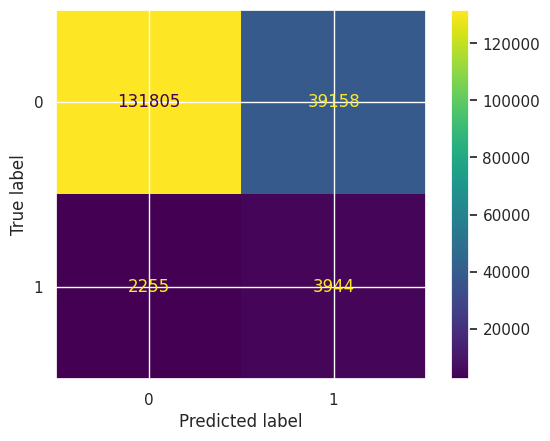

In [149]:
conf_matrix(y_valid, y_pred_valid_LR_sc)

In [150]:
print(classification_report(y_valid, y_pred_valid_LR_sc))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86    170963
           1       0.09      0.64      0.16      6199

    accuracy                           0.77    177162
   macro avg       0.54      0.70      0.51    177162
weighted avg       0.95      0.77      0.84    177162



#### По матрице ошибок и отчёту классификации видно, что полнота предсказаных значений класса ```1``` **значительно выросла**

#### Теперь попробуем убрать шум в данных при помощи **метода главных компонент**

In [151]:
X_train_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
476450       1.065571       -0.349117   0.760141  0.729502 -1.503640   
257888      -0.292938       -0.140991   0.760141  0.067405 -1.485378   
292700      -0.063446       -0.539357  -1.551777  1.326093 -0.937517   
440564       0.808042       -0.427997   0.760141  0.068231  1.199139   
63257       -1.343802       -0.444647   0.760141  1.543486 -0.225299   
...               ...             ...        ...       ...       ...   
283162      -0.134408       -0.174083  -0.973798 -0.764557  1.369584   
448422       0.861979        0.034044  -0.973798 -1.432235 -1.308845   
196895      -0.679939       -0.298397  -1.551777  1.104361 -2.185422   
260960      -0.273914        0.034044   0.182162 -0.764557  1.369584   
385880       0.476064        0.708166   0.760141  0.523682 -1.144487   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
476450  0.709928  0.673100  0.714849  0.258862  0.557230      -0.498556   
257888  0.709928  0.673100  0.714849  1.880289  0.557230      -0.498556   
292700  0.709928 -1.197238  0.714849 -1.473712 -1.814915      -0.498556   
440564  0.709928  0.673100  0.714849 -0.218413  0.557230       0.540066   
63257   0.709928  0.673100  0.714849  0.487692  0.557230      -0.498556   
...          ...       ...       ...       ...       ...            ...   
283162  0.709928  0.673100 -1.312902  0.657680  0.557230      -0.498556   
448422  0.709928  0.673100  0.714849  0.258862  0.557230      -1.472263   
196895  0.709928  0.673100 -1.312902 -1.473712 -1.814915      -0.498556   
260960  0.709928  0.673100 -1.312902  0.690371  0.557230       0.540066   
385880  0.709928  0.673100 -1.312902  0.003879  0.557230      -0.498556   

              C3        D3        V1       V55      V107      V121      V281  \
476450 -0.032738 -0.545701  0.014869 -0.239581  0.013875 -0.076736 -0.226747   
257888 -0.032738  1.213385  0.014869 -0.239581  0.013875 -0.076736 -0.226747   
292700 -0.032738 -0.017975 -0.005808 -0.239581  0.013875 -0.076736 -0.226747   
440564 -0.032738 -0.495442 -0.005808 -0.239581  0.013875 -0.076736  2.339385   
63257  -0.032738  0.090643  0.014869 -0.239581  0.013875 -0.076736 -0.226747   
...          ...       ...       ...       ...       ...       ...       ...   
283162 -0.032738  0.090643 -0.005808 -0.089012  0.013875 -0.076736 -0.226747   
448422 -0.032738  0.090643 -0.005808 -0.089012  0.013875 -0.076736 -0.226747   
196895 -0.032738  0.090643 -0.005808 -0.239581  0.013875 -0.076736 -0.226747   
260960 -0.032738  0.090643 -0.005808 -0.089012  0.013875 -0.076736 -0.226747   
385880 -0.032738  0.560010  0.014869  2.001641  0.013875 -0.076736 -0.226747   

            V286      V305  
476450 -0.170294 -0.006774  
257888 -0.170294 -0.006774  
292700 -0.170294 -0.006774  
440564 -0.170294 -0.006774  
63257  -0.170294 -0.006774  
...          ...       ...  
283162 -0.170294 -0.006774  
448422 -0.170294 -0.006774  
196895 -0.170294 -0.006774  
260960 -0.170294 -0.006774  
385880 -0.170294 -0.006774  

[239725 rows x 20 columns]

In [152]:
from sklearn import decomposition

In [153]:
pca = decomposition.PCA()
pca.fit(X_train_sc)
X_train_norm = pca.transform(X_train_sc)
X_valid_norm = pca.transform(X_valid_sc)

Посмотрим, как выглядит вклад каждой из компонент в разброс исходных данных

In [154]:
pca.explained_variance_ratio_

array([0.14628392, 0.0812558 , 0.06720005, 0.05893598, 0.05259626,
       0.05158652, 0.05082917, 0.0501058 , 0.05000338, 0.04940487,
       0.04863863, 0.04773543, 0.04652178, 0.04476078, 0.04352481,
       0.03510337, 0.03142881, 0.02428373, 0.01479381, 0.00500712])

Видим, что большая часть компонент вносит примерно равный вклад в разброс исходных данных, поэтому будем обучать модель с использованием всех компонент

In [155]:
model_LR_norm = LogisticRegression()
model_LR_norm.fit(X_train_norm, y_train_balanced)

LogisticRegression()

In [156]:
y_pred_valid_LR_norm = model_LR_norm.predict(X_valid_norm)

In [157]:
print(f'Доля верно угаданных объектов {(y_pred_valid_LR_norm == y_valid).sum() / len(y_valid)}')

Доля верно угаданных объектов 0.7662421964078076


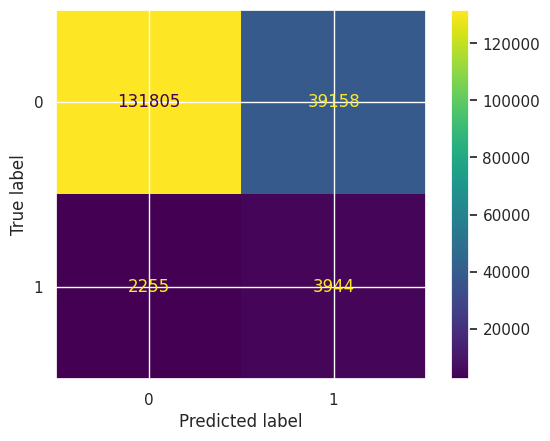

In [158]:
conf_matrix(y_valid, y_pred_valid_LR_norm)

In [159]:
print(classification_report(y_valid, y_pred_valid_LR_norm))

              precision    recall  f1-score   support

           0       0.98      0.77      0.86    170963
           1       0.09      0.64      0.16      6199

    accuracy                           0.77    177162
   macro avg       0.54      0.70      0.51    177162
weighted avg       0.95      0.77      0.84    177162



### Попробуем сделать прогнозы с использованием других, более сложных моделей

Напишем функцию, которая будет обучать модели, делать прогнозы и предоставлять отчёт по качеству прогнозов

In [160]:
def fit_pred_score(model, model_name, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_valid)
    y_pred_proba = model.predict_proba(X_valid)[:,1]
    print('------------------------------')
    print(model_name)
    print(f'Доля верно угаданных объектов {(y_pred == y_valid).sum() / len(y_valid)}')
    conf_matrix(y_valid, y_pred)
    print(classification_report(y_valid, y_pred))
    roc_auc = roc_auc_score(y_valid, y_pred_proba)
    print('roc auc score: ', roc_auc_score(y_valid, y_pred_proba))
    return model, roc_auc

------------------------------
DecisionTree
Доля верно угаданных объектов 0.9294769758751876


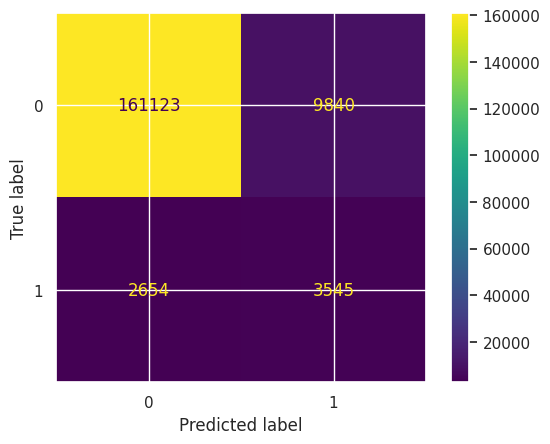

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    170963
           1       0.26      0.57      0.36      6199

    accuracy                           0.93    177162
   macro avg       0.62      0.76      0.66    177162
weighted avg       0.96      0.93      0.94    177162

roc auc score:  0.7571550583575072


In [161]:
DTmodel, DT_roc_auc_score = fit_pred_score(DecisionTreeClassifier(), 'DecisionTree', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
RandomForest
Доля верно угаданных объектов 0.9660706020478432


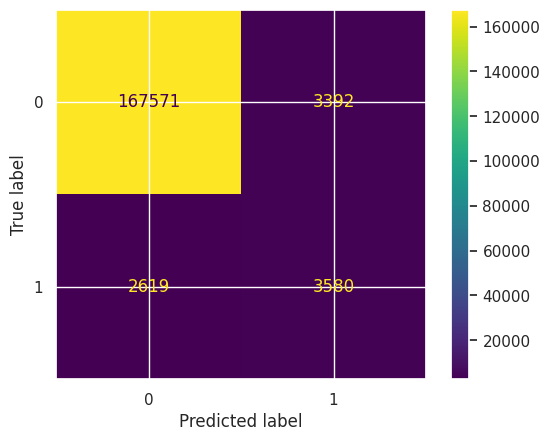

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    170963
           1       0.51      0.58      0.54      6199

    accuracy                           0.97    177162
   macro avg       0.75      0.78      0.76    177162
weighted avg       0.97      0.97      0.97    177162

roc auc score:  0.9141191959098586


In [162]:
RFmodel, RF_roc_auc_score = fit_pred_score(RandomForestClassifier(), 'RandomForest', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
AdaBoost
Доля верно угаданных объектов 0.7587631659159414


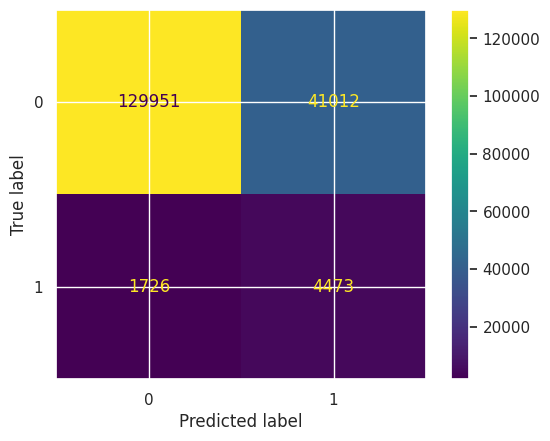

              precision    recall  f1-score   support

           0       0.99      0.76      0.86    170963
           1       0.10      0.72      0.17      6199

    accuracy                           0.76    177162
   macro avg       0.54      0.74      0.52    177162
weighted avg       0.96      0.76      0.83    177162

roc auc score:  0.8119193949110589


In [163]:
AdaBoost_model, AdaBoost_roc_auc_score = fit_pred_score(AdaBoostClassifier(), 'AdaBoost', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
GradientBoosting
Доля верно угаданных объектов 0.7730382361906052


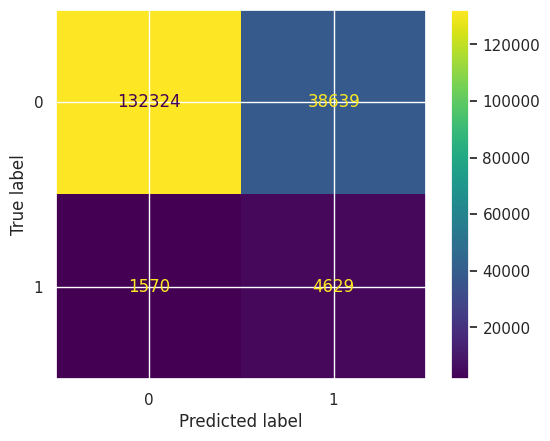

              precision    recall  f1-score   support

           0       0.99      0.77      0.87    170963
           1       0.11      0.75      0.19      6199

    accuracy                           0.77    177162
   macro avg       0.55      0.76      0.53    177162
weighted avg       0.96      0.77      0.84    177162

roc auc score:  0.83920083565758


In [164]:
GBM_model, GBM_roc_auc_score = fit_pred_score(GradientBoostingClassifier(), 'GradientBoosting', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
XGB
Доля верно угаданных объектов 0.8579661552703176


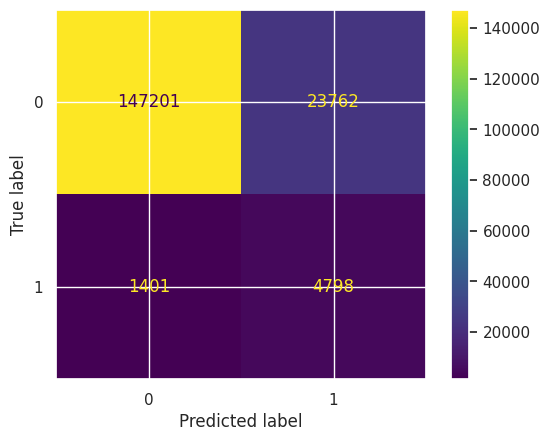

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    170963
           1       0.17      0.77      0.28      6199

    accuracy                           0.86    177162
   macro avg       0.58      0.82      0.60    177162
weighted avg       0.96      0.86      0.90    177162

roc auc score:  0.8957391358306344


In [165]:
XGB_model, XGB_roc_auc_score = fit_pred_score(XGBClassifier(), 'XGB', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
LGBM
Доля верно угаданных объектов 0.8356984003341574


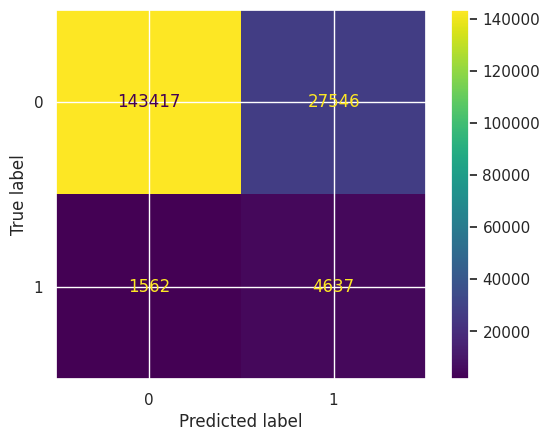

              precision    recall  f1-score   support

           0       0.99      0.84      0.91    170963
           1       0.14      0.75      0.24      6199

    accuracy                           0.84    177162
   macro avg       0.57      0.79      0.57    177162
weighted avg       0.96      0.84      0.88    177162

roc auc score:  0.8748728633504901


In [166]:
LGBM_model, LGBM_roc_auc_score = fit_pred_score(LGBMClassifier(), 'LGBM', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

Сделаем общую таблицу по основной метрике качества этого задания ```roc auc score```, чтобы наглядно увидеть лучшую модель:

In [167]:
roc_auc_df = pd.DataFrame(data=[DT_roc_auc_score, 
                                RF_roc_auc_score,
                                AdaBoost_roc_auc_score,
                                GBM_roc_auc_score,
                                XGB_roc_auc_score,
                                LGBM_roc_auc_score],
                          index=['DT', 'RF', 'AdaBoost', 'GBM', 'XGB', 'LGBM'],
                         columns=['roc auc score'])
roc_auc_df

roc auc score
DT             0.757155
RF             0.914119
AdaBoost       0.811919
GBM            0.839201
XGB            0.895739
LGBM           0.874873

### Видим, что классфикатор ```Random Forest``` показал наилучшую точность

#### Посмотрим на важность признаков:

In [168]:
print('DecesionTree important features:')
sorted(zip(X_train_sc.columns, DTmodel.feature_importances_), key=lambda x: -x[1])

DecesionTree important features:


[('TransactionDT', 0.19343430719078142),
 ('TransactionAmt', 0.14656623657950857),
 ('addr2', 0.10969687252492417),
 ('card1', 0.10566072277251641),
 ('addr1', 0.07872599106647364),
 ('D3', 0.07639069249937579),
 ('card2', 0.07437806172098121),
 ('P_emaildomain', 0.06412663506188016),
 ('V55', 0.05514483231606164),
 ('card5', 0.028284277865828208),
 ('V281', 0.01620641942500194),
 ('card6', 0.01510860860980388),
 ('ProductCD', 0.012064207774096893),
 ('card4', 0.009425359115415671),
 ('V1', 0.006258747279938133),
 ('V286', 0.005020180628599892),
 ('C3', 0.002330957236568891),
 ('V121', 0.0011312650138179444),
 ('V107', 4.562531842548884e-05),
 ('V305', 0.0)]

In [169]:
print('RandomForest important features:')
sorted(zip(X_train_sc.columns, RFmodel.feature_importances_), key=lambda x: -x[1])

RandomForest important features:


[('TransactionDT', 0.16842894887632226),
 ('TransactionAmt', 0.14973669385336305),
 ('addr1', 0.10963769793061988),
 ('card1', 0.10135916489178352),
 ('D3', 0.08760171824665765),
 ('card2', 0.07853564796797236),
 ('P_emaildomain', 0.06875147121666476),
 ('ProductCD', 0.046782369727575594),
 ('addr2', 0.03940834541005005),
 ('card5', 0.03384302338910711),
 ('V55', 0.025522579977720422),
 ('V281', 0.02505176628509295),
 ('card6', 0.023635438686425394),
 ('V1', 0.01837499640702542),
 ('card4', 0.013593009535094736),
 ('V286', 0.005571394285172541),
 ('V121', 0.0020385920653260645),
 ('C3', 0.0018806116720517841),
 ('V107', 0.00024009247981975518),
 ('V305', 6.437096154812449e-06)]

In [170]:
print('AdaBoost important features:')
sorted(zip(X_train_sc.columns, AdaBoost_model.feature_importances_), key=lambda x: -x[1])

AdaBoost important features:


[('P_emaildomain', 0.16),
 ('TransactionAmt', 0.14),
 ('V55', 0.12),
 ('card2', 0.1),
 ('TransactionDT', 0.08),
 ('card1', 0.08),
 ('card4', 0.04),
 ('card6', 0.04),
 ('addr1', 0.04),
 ('D3', 0.04),
 ('V281', 0.04),
 ('ProductCD', 0.02),
 ('addr2', 0.02),
 ('C3', 0.02),
 ('V1', 0.02),
 ('V121', 0.02),
 ('V286', 0.02),
 ('card5', 0.0),
 ('V107', 0.0),
 ('V305', 0.0)]

In [171]:
print('GradientBoosting important features:')
sorted(zip(X_train_sc.columns, GBM_model.feature_importances_), key=lambda x: -x[1])

GradientBoosting important features:


[('ProductCD', 0.19552381825445247),
 ('D3', 0.16661930725032134),
 ('addr2', 0.14660681575901235),
 ('TransactionAmt', 0.09749523404034552),
 ('TransactionDT', 0.07337671808550604),
 ('V55', 0.0687503715278633),
 ('card6', 0.0683432434371319),
 ('P_emaildomain', 0.04845250252095573),
 ('V281', 0.035421488425252605),
 ('card2', 0.027962797551248784),
 ('addr1', 0.026016773721648283),
 ('card1', 0.021521599112117425),
 ('V286', 0.00730771336024508),
 ('card5', 0.005248918944005859),
 ('C3', 0.004276107403144311),
 ('card4', 0.004195271023875096),
 ('V1', 0.0015139142598264385),
 ('V121', 0.0013674053230473705),
 ('V107', 0.0),
 ('V305', 0.0)]

In [172]:
print('XGB important features:')
sorted(zip(X_train_sc.columns, XGB_model.feature_importances_), key=lambda x: -x[1])

XGB important features:


[('addr2', 0.48977062),
 ('ProductCD', 0.10147734),
 ('V55', 0.07430056),
 ('D3', 0.04503803),
 ('V281', 0.040992636),
 ('card6', 0.040516112),
 ('V286', 0.026495885),
 ('C3', 0.023661163),
 ('P_emaildomain', 0.020835975),
 ('TransactionAmt', 0.019547654),
 ('card2', 0.017129531),
 ('V121', 0.015962308),
 ('TransactionDT', 0.015320865),
 ('card5', 0.015123901),
 ('card1', 0.015079891),
 ('addr1', 0.013798748),
 ('card4', 0.0121130645),
 ('V1', 0.010390592),
 ('V107', 0.002445101),
 ('V305', 0.0)]

In [173]:
print('LGB important features:')
sorted(zip(X_train_sc.columns, LGBM_model.feature_importances_), key=lambda x: -x[1])

LGB important features:


[('TransactionAmt', 441),
 ('card1', 428),
 ('card2', 365),
 ('TransactionDT', 319),
 ('P_emaildomain', 303),
 ('addr1', 298),
 ('D3', 180),
 ('card5', 138),
 ('ProductCD', 102),
 ('V55', 86),
 ('card6', 82),
 ('V281', 69),
 ('card4', 54),
 ('addr2', 44),
 ('C3', 29),
 ('V286', 26),
 ('V1', 20),
 ('V121', 16),
 ('V107', 0),
 ('V305', 0)]

По большей части в моделях наименее важными считаются признаки:
```'V286'``` , ```'V121'```, ```'C3'```, ```'V107'```, ```'V305'```.
Удалим их из данных

In [174]:
not_important_feats = ['V286', 'V121', 'C3', 'V107', 'V305']
X_train_sc = X_train_sc.drop(columns=not_important_feats)
X_valid_sc = X_valid_sc.drop(columns=not_important_feats)

In [175]:
test_df_sc = test_df_sc.drop(columns=not_important_feats)

In [176]:
X_train_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
476450       1.065571       -0.349117   0.760141  0.729502 -1.503640   
257888      -0.292938       -0.140991   0.760141  0.067405 -1.485378   
292700      -0.063446       -0.539357  -1.551777  1.326093 -0.937517   
440564       0.808042       -0.427997   0.760141  0.068231  1.199139   
63257       -1.343802       -0.444647   0.760141  1.543486 -0.225299   
...               ...             ...        ...       ...       ...   
283162      -0.134408       -0.174083  -0.973798 -0.764557  1.369584   
448422       0.861979        0.034044  -0.973798 -1.432235 -1.308845   
196895      -0.679939       -0.298397  -1.551777  1.104361 -2.185422   
260960      -0.273914        0.034044   0.182162 -0.764557  1.369584   
385880       0.476064        0.708166   0.760141  0.523682 -1.144487   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
476450  0.709928  0.673100  0.714849  0.258862  0.557230      -0.498556   
257888  0.709928  0.673100  0.714849  1.880289  0.557230      -0.498556   
292700  0.709928 -1.197238  0.714849 -1.473712 -1.814915      -0.498556   
440564  0.709928  0.673100  0.714849 -0.218413  0.557230       0.540066   
63257   0.709928  0.673100  0.714849  0.487692  0.557230      -0.498556   
...          ...       ...       ...       ...       ...            ...   
283162  0.709928  0.673100 -1.312902  0.657680  0.557230      -0.498556   
448422  0.709928  0.673100  0.714849  0.258862  0.557230      -1.472263   
196895  0.709928  0.673100 -1.312902 -1.473712 -1.814915      -0.498556   
260960  0.709928  0.673100 -1.312902  0.690371  0.557230       0.540066   
385880  0.709928  0.673100 -1.312902  0.003879  0.557230      -0.498556   

              D3        V1       V55      V281  
476450 -0.545701  0.014869 -0.239581 -0.226747  
257888  1.213385  0.014869 -0.239581 -0.226747  
292700 -0.017975 -0.005808 -0.239581 -0.226747  
440564 -0.495442 -0.005808 -0.239581  2.339385  
63257   0.090643  0.014869 -0.239581 -0.226747  
...          ...       ...       ...       ...  
283162  0.090643 -0.005808 -0.089012 -0.226747  
448422  0.090643 -0.005808 -0.089012 -0.226747  
196895  0.090643 -0.005808 -0.239581 -0.226747  
260960  0.090643 -0.005808 -0.089012 -0.226747  
385880  0.560010  0.014869  2.001641 -0.226747  

[239725 rows x 15 columns]

In [177]:
X_valid_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
249789      -0.346471        0.200337   0.760141  0.865270  0.066894   
296417      -0.042354       -0.224241   0.760141 -0.271290 -0.572277   
589439       1.829722        0.034044  -0.973798 -1.652107  1.369584   
422091       0.702192       -0.186570   0.760141  1.586469 -0.225299   
32528       -1.486884       -0.344747   0.760141  0.741488  0.426047   
...               ...             ...        ...       ...       ...   
559622       1.617825       -0.149108   0.182162  1.251493  0.748676   
85552       -1.262913       -0.382209  -0.973798 -1.218768 -1.503640   
122974      -1.129233       -0.520930  -1.551777  1.274225  1.138265   
414668       0.650096       -0.245054   0.760141  0.411472  0.736501   
440391       0.804852        0.395976   0.760141 -0.645528 -1.406243   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
249789 -1.210328 -1.643569  0.714849  0.657680  0.557230       0.085669   
296417  0.709928  0.673100  0.714849  0.736137  0.557230      -0.498556   
589439  0.709928  0.673100 -1.312902  0.657680  0.557230       0.280410   
422091  0.709928  0.014231 -1.312902  0.487692  0.557230      -1.407349   
32528   0.709928 -0.602131  0.714849  0.258862  0.557230      -1.407349   
...          ...       ...       ...       ...       ...            ...   
559622 -1.210328 -1.962377 -1.312902  0.690371  0.557230       0.540066   
85552  -1.210328  0.524323 -1.312902  0.690371  0.557230      -0.498556   
122974  0.709928 -1.197238  0.714849 -1.473712 -1.814915      -0.303814   
414668  0.709928  0.673100 -1.312902 -0.532238  0.557230      -0.498556   
440391 -1.210328 -1.643569  0.714849  0.657680  0.557230       1.968170   

              D3        V1       V55      V281  
249789  0.092405  0.014869 -0.239581 -0.226747  
296417  1.816500  0.014869 -0.239581 -0.226747  
589439  0.092405  0.000052 -0.085356 -0.226747  
422091  0.233323  0.014869 -0.239581 -0.226747  
32528   0.092405  0.000052 -0.239581 -0.226747  
...          ...       ...       ...       ...  
559622 -0.621091  0.000052 -0.239581 -0.226747  
85552   0.092405  0.000052 -0.085356 -0.226747  
122974  0.092405  0.000052 -0.239581 -0.226747  
414668  0.032284  0.014869 -0.239581 -0.226747  
440391  0.092405  0.000052 -0.239581 -0.226747  

[177162 rows x 15 columns]

In [178]:
test_df_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0            2.408104       -0.457343   0.760141  0.142624 -1.503640   
1            2.408112       -0.386372   0.760141 -1.125570 -1.503640   
2            2.408123        0.121457   0.760141 -1.083414  1.314798   
3            2.408123        0.595777   0.760141  0.262480  0.012108   
4            2.408124       -0.307492   0.760141  1.715003  0.572143   
...               ...             ...        ...       ...       ...   
506686       5.905919       -0.196232  -1.551777  0.849978  0.103418   
506687       5.905921       -0.539665  -1.551777 -1.356602  0.304300   
506688       5.905929       -0.386372   0.760141  1.434583  0.803462   
506689       5.905932        0.250495   0.760141  1.426317  0.961733   
506690       5.905934       -0.488995  -1.551777 -0.827791 -1.156662   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0       0.709928  0.673100  0.714849 -0.355711  0.557230      -0.498556   
1       0.709928  0.673100  0.714849  0.487692  0.557230      -1.407349   
2       0.709928  0.673100  0.714849  1.618768  0.557230      -0.303814   
3       0.709928 -0.602131  0.714849 -0.126881  0.557230      -0.498556   
4      -1.210328 -1.643569  0.714849  0.258862  0.557230      -0.498556   
...          ...       ...       ...       ...       ...            ...   
506686 -1.210328  0.630592  0.714849  0.389622 -0.170588      -0.498556   
506687 -1.210328  0.630592  0.714849 -1.473712 -1.814915      -0.303814   
506688  0.709928  0.673100  0.714849  0.670757  0.557230      -0.303814   
506689 -1.210328  0.630592  0.714849 -0.309945  0.557230      -0.303814   
506690  0.709928 -1.005954 -1.312902 -1.473712 -1.814915      -0.303814   

              D3        V1       V55      V281  
0       0.057414  0.014869 -0.239581 -0.226747  
1      -0.445182  0.014869 -0.239581 -0.226747  
2      -0.369793  0.014869 -0.239581 -0.226747  
3       0.409231  0.014869 -0.239581 -0.226747  
4      -0.621091  0.014869 -0.239581 -0.226747  
...          ...       ...       ...       ...  
506686  0.218112  0.013816 -0.239581 -0.226747  
506687 -0.219014  0.013816  2.001641  1.056319  
506688  0.218112  0.014869 -0.239581 -0.226747  
506689  0.218112  0.014869 -0.239581 -0.226747  
506690  0.218112  0.013816 -0.239581 -0.226747  

[506691 rows x 15 columns]

Теперь снова попробуем обучить наши модели:

------------------------------
DecisionTree
Доля верно угаданных объектов 0.9297309806843455


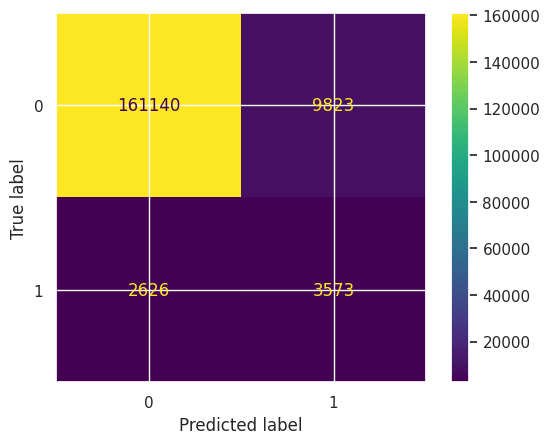

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    170963
           1       0.27      0.58      0.36      6199

    accuracy                           0.93    177162
   macro avg       0.63      0.76      0.66    177162
weighted avg       0.96      0.93      0.94    177162

roc auc score:  0.7594632054964556


In [179]:
DT, DT_roc_auc = fit_pred_score(DecisionTreeClassifier(), 'DecisionTree', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
RF
Доля верно угаданных объектов 0.9660085119833824


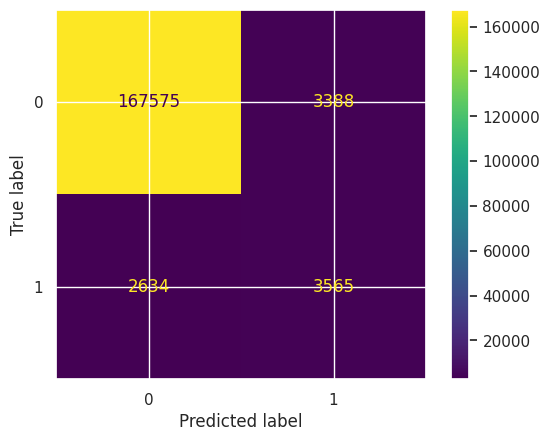

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    170963
           1       0.51      0.58      0.54      6199

    accuracy                           0.97    177162
   macro avg       0.75      0.78      0.76    177162
weighted avg       0.97      0.97      0.97    177162

roc auc score:  0.9135523302693865


In [180]:
RF, RF_roc_auc = fit_pred_score(RandomForestClassifier(), 'RF', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
AdaBoost
Доля верно угаданных объектов 0.7615120624061593


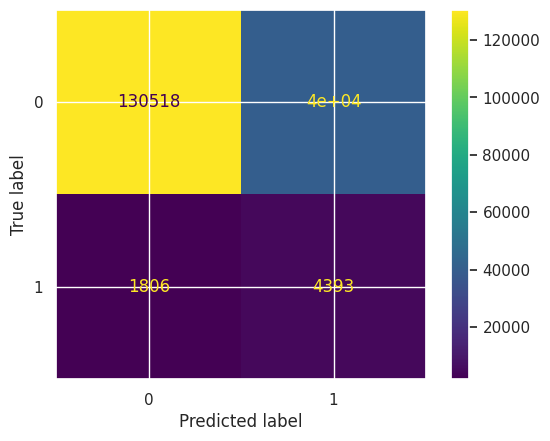

              precision    recall  f1-score   support

           0       0.99      0.76      0.86    170963
           1       0.10      0.71      0.17      6199

    accuracy                           0.76    177162
   macro avg       0.54      0.74      0.52    177162
weighted avg       0.96      0.76      0.84    177162

roc auc score:  0.8099381369197431


In [181]:
AdaBoost, AdaBoost_roc_auc = fit_pred_score(AdaBoostClassifier(), 'AdaBoost', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
GradBoost
Доля верно угаданных объектов 0.7750138291507208


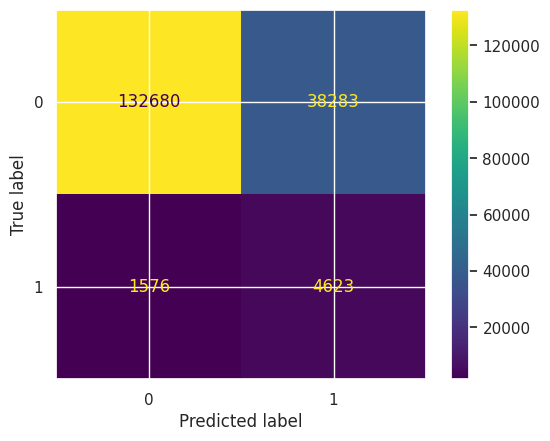

              precision    recall  f1-score   support

           0       0.99      0.78      0.87    170963
           1       0.11      0.75      0.19      6199

    accuracy                           0.78    177162
   macro avg       0.55      0.76      0.53    177162
weighted avg       0.96      0.78      0.85    177162

roc auc score:  0.8380970784386106


In [182]:
GradBoost, GradBoost_roc_auc = fit_pred_score(GradientBoostingClassifier(), 'GradBoost', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
XGB
Доля верно угаданных объектов 0.8550817895485487


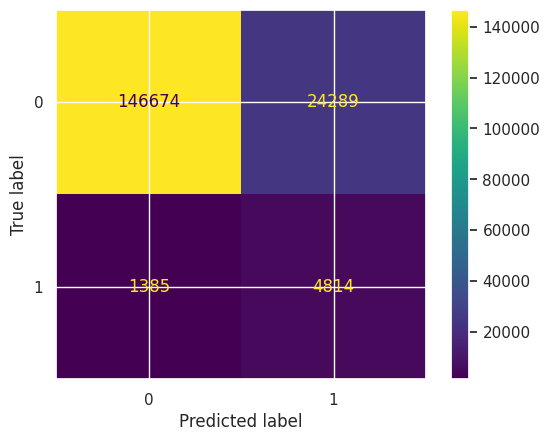

              precision    recall  f1-score   support

           0       0.99      0.86      0.92    170963
           1       0.17      0.78      0.27      6199

    accuracy                           0.86    177162
   macro avg       0.58      0.82      0.60    177162
weighted avg       0.96      0.86      0.90    177162

roc auc score:  0.894833511817857


In [183]:
XGB, XGB_roc_auc = fit_pred_score(XGBClassifier(), 'XGB', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

------------------------------
LGBM
Доля верно угаданных объектов 0.8312674275521839


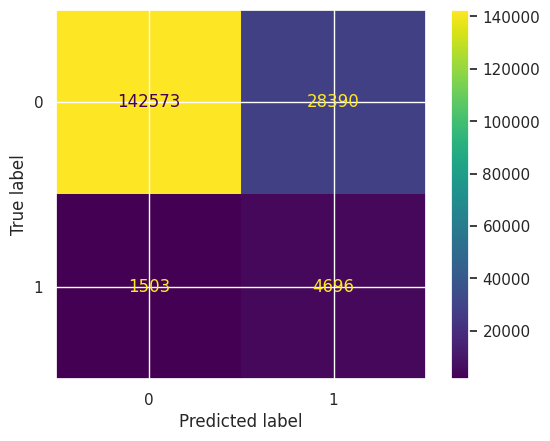

              precision    recall  f1-score   support

           0       0.99      0.83      0.91    170963
           1       0.14      0.76      0.24      6199

    accuracy                           0.83    177162
   macro avg       0.57      0.80      0.57    177162
weighted avg       0.96      0.83      0.88    177162

roc auc score:  0.874991649482892


In [184]:
LGBM, LGBM_roc_auc = fit_pred_score(LGBMClassifier(), 'LGBM', X_train_sc, y_train_balanced, X_valid_sc, y_valid)

Посмотрим и сравним оценки ```roc_auc``` до и после удаления не важных признаков

In [185]:
roc_auc_df2 = pd.DataFrame(data=[DT_roc_auc, 
                                 RF_roc_auc, 
                                 AdaBoost_roc_auc,
                                 GradBoost_roc_auc,
                                 XGB_roc_auc,
                                 LGBM_roc_auc],
                           index=['DT', 'RF', 'AdaBoost', 'GBM', 'XGB', 'LGBM'],
                          columns=['roc auc score2'])
roc_auc_general = pd.concat([roc_auc_df, roc_auc_df2], axis=1)
roc_auc_general

roc auc score  roc auc score2
DT             0.757155        0.759463
RF             0.914119        0.913552
AdaBoost       0.811919        0.809938
GBM            0.839201        0.838097
XGB            0.895739        0.894834
LGBM           0.874873        0.874992

Теперь уберём выбросы из данных и затем снова приступим к обучению моделей

Снова посмотрим на распределения оставшихся признаков

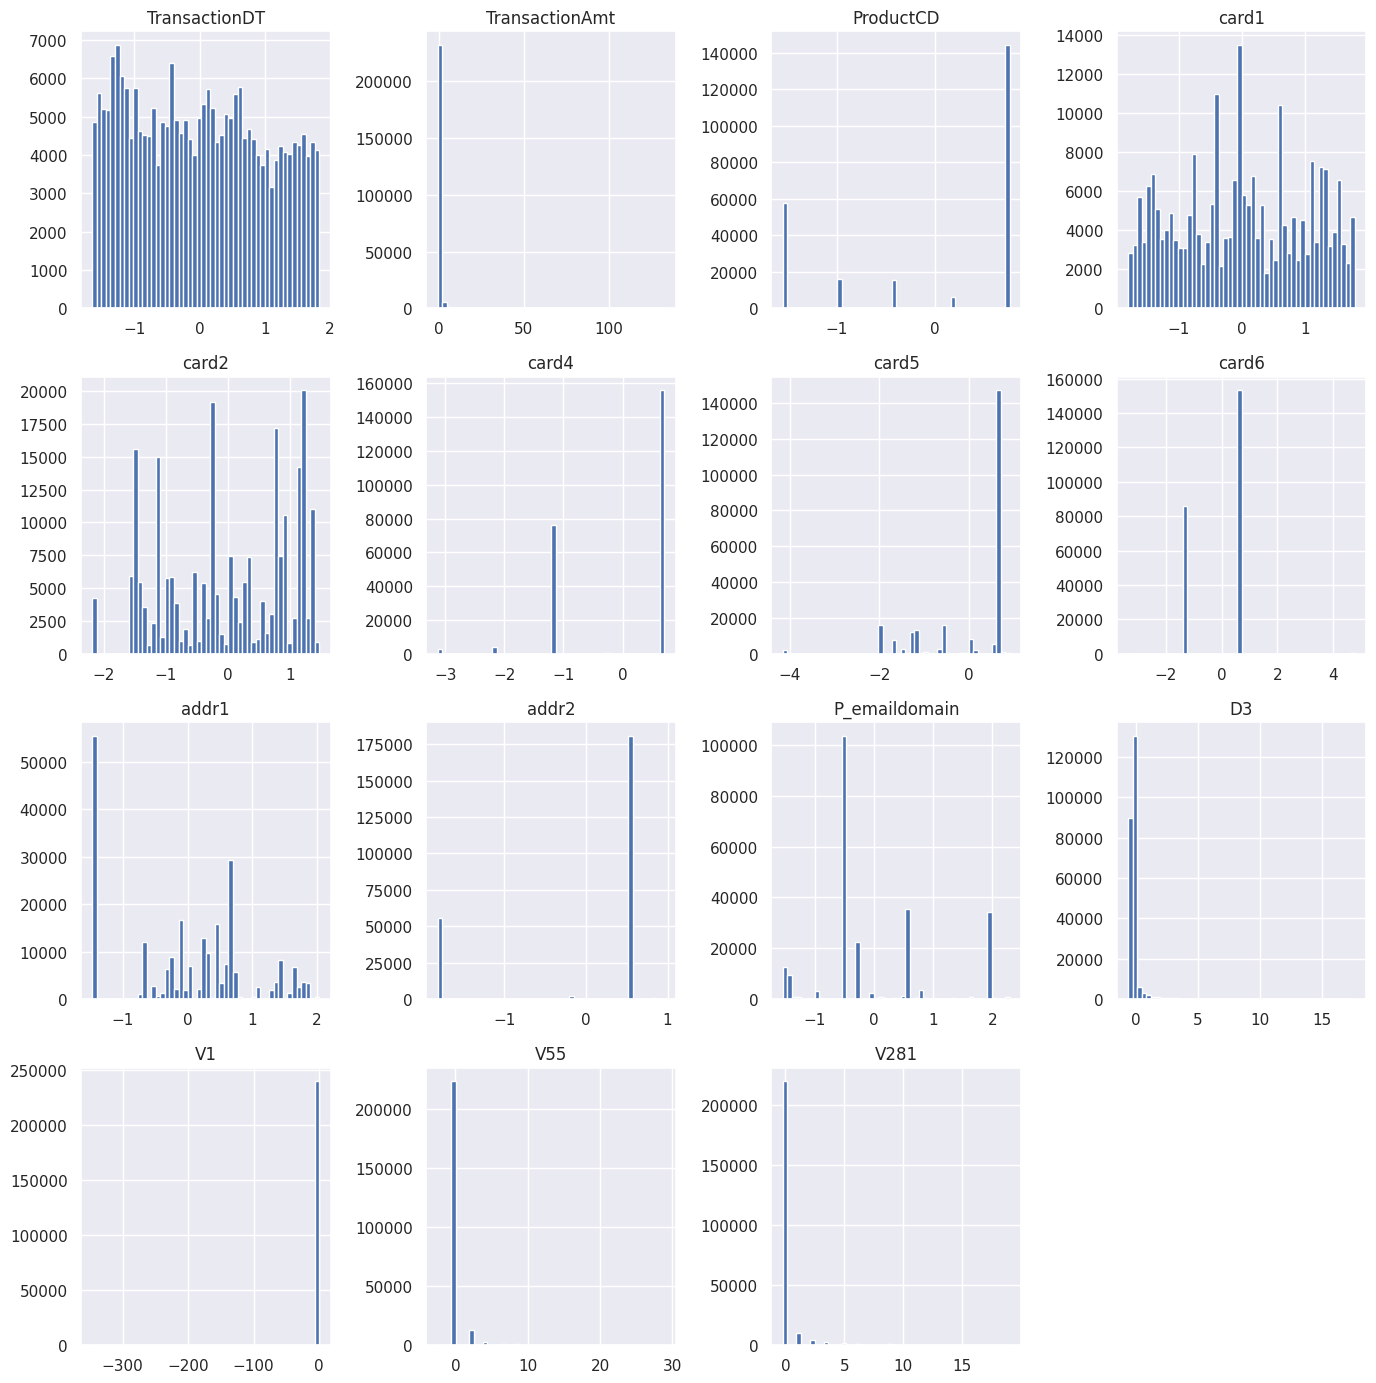

In [186]:
X_train_sc[X_train_sc.columns].hist(bins=50, figsize=(14,14))
plt.tight_layout()

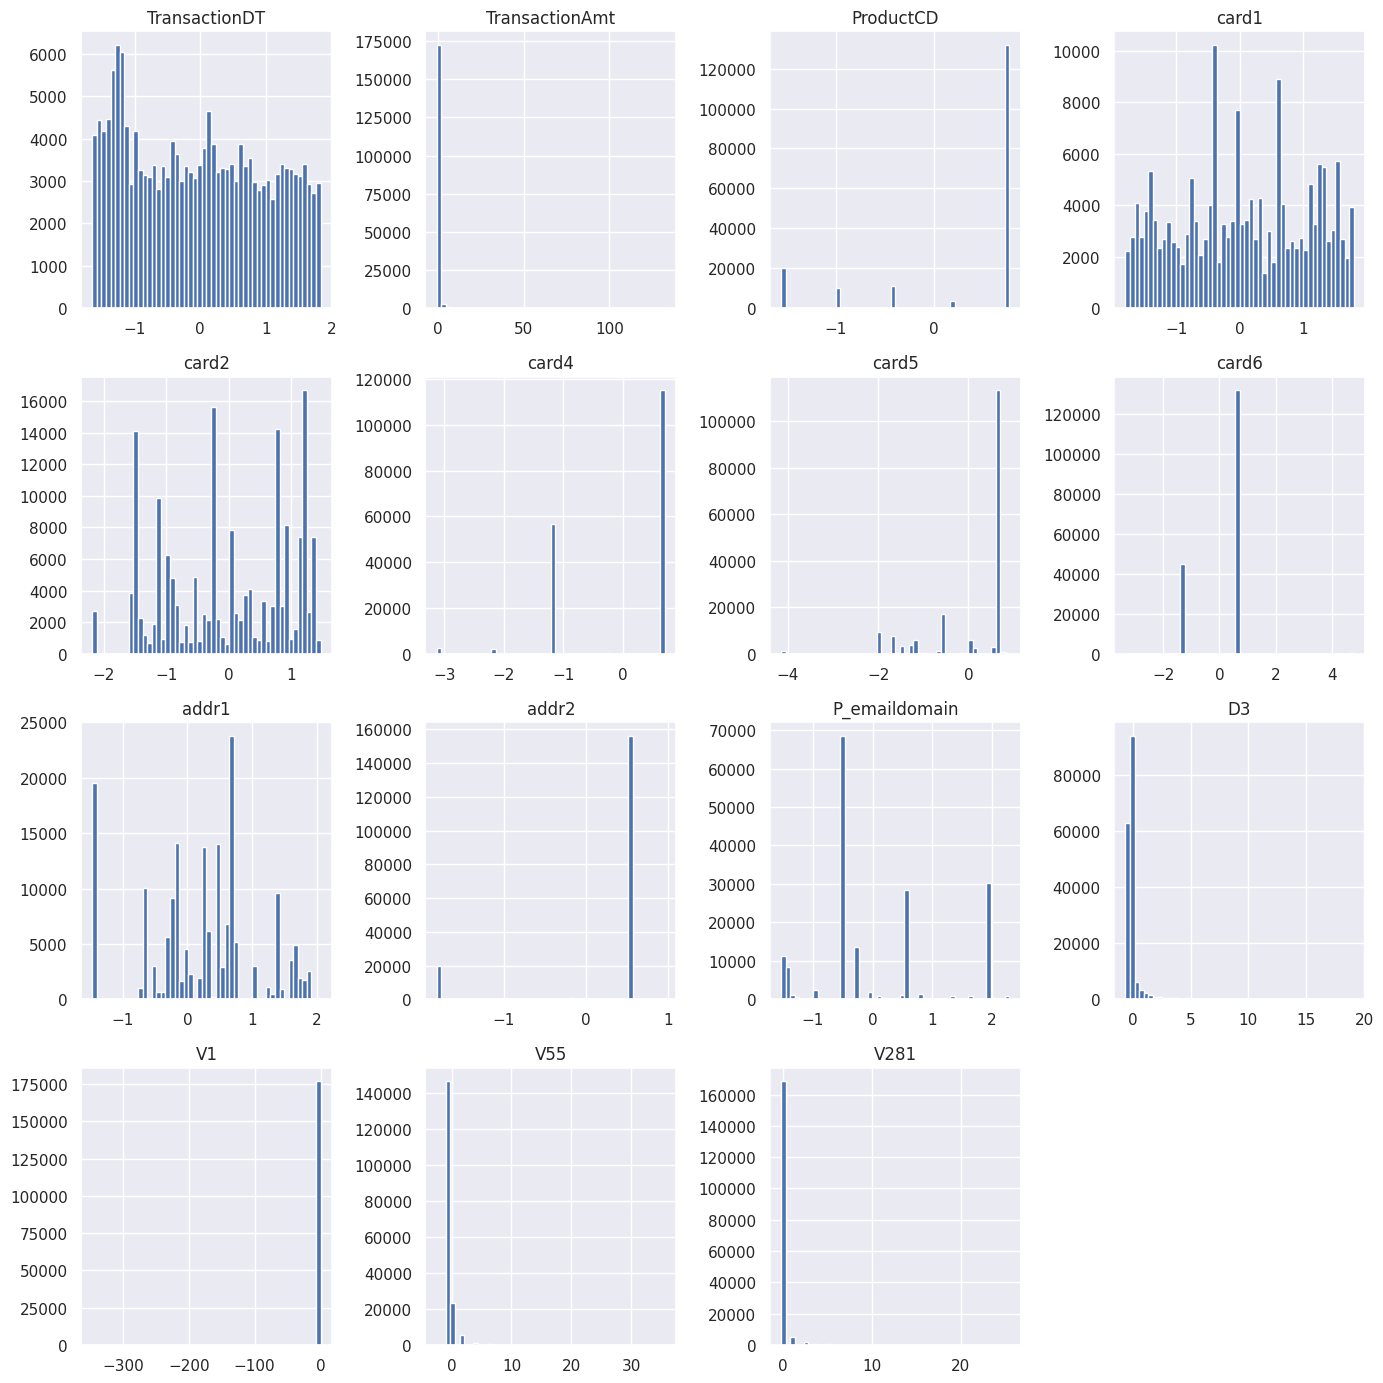

In [187]:
X_valid_sc[X_valid_sc.columns].hist(bins=50, figsize=(14,14))
plt.tight_layout()

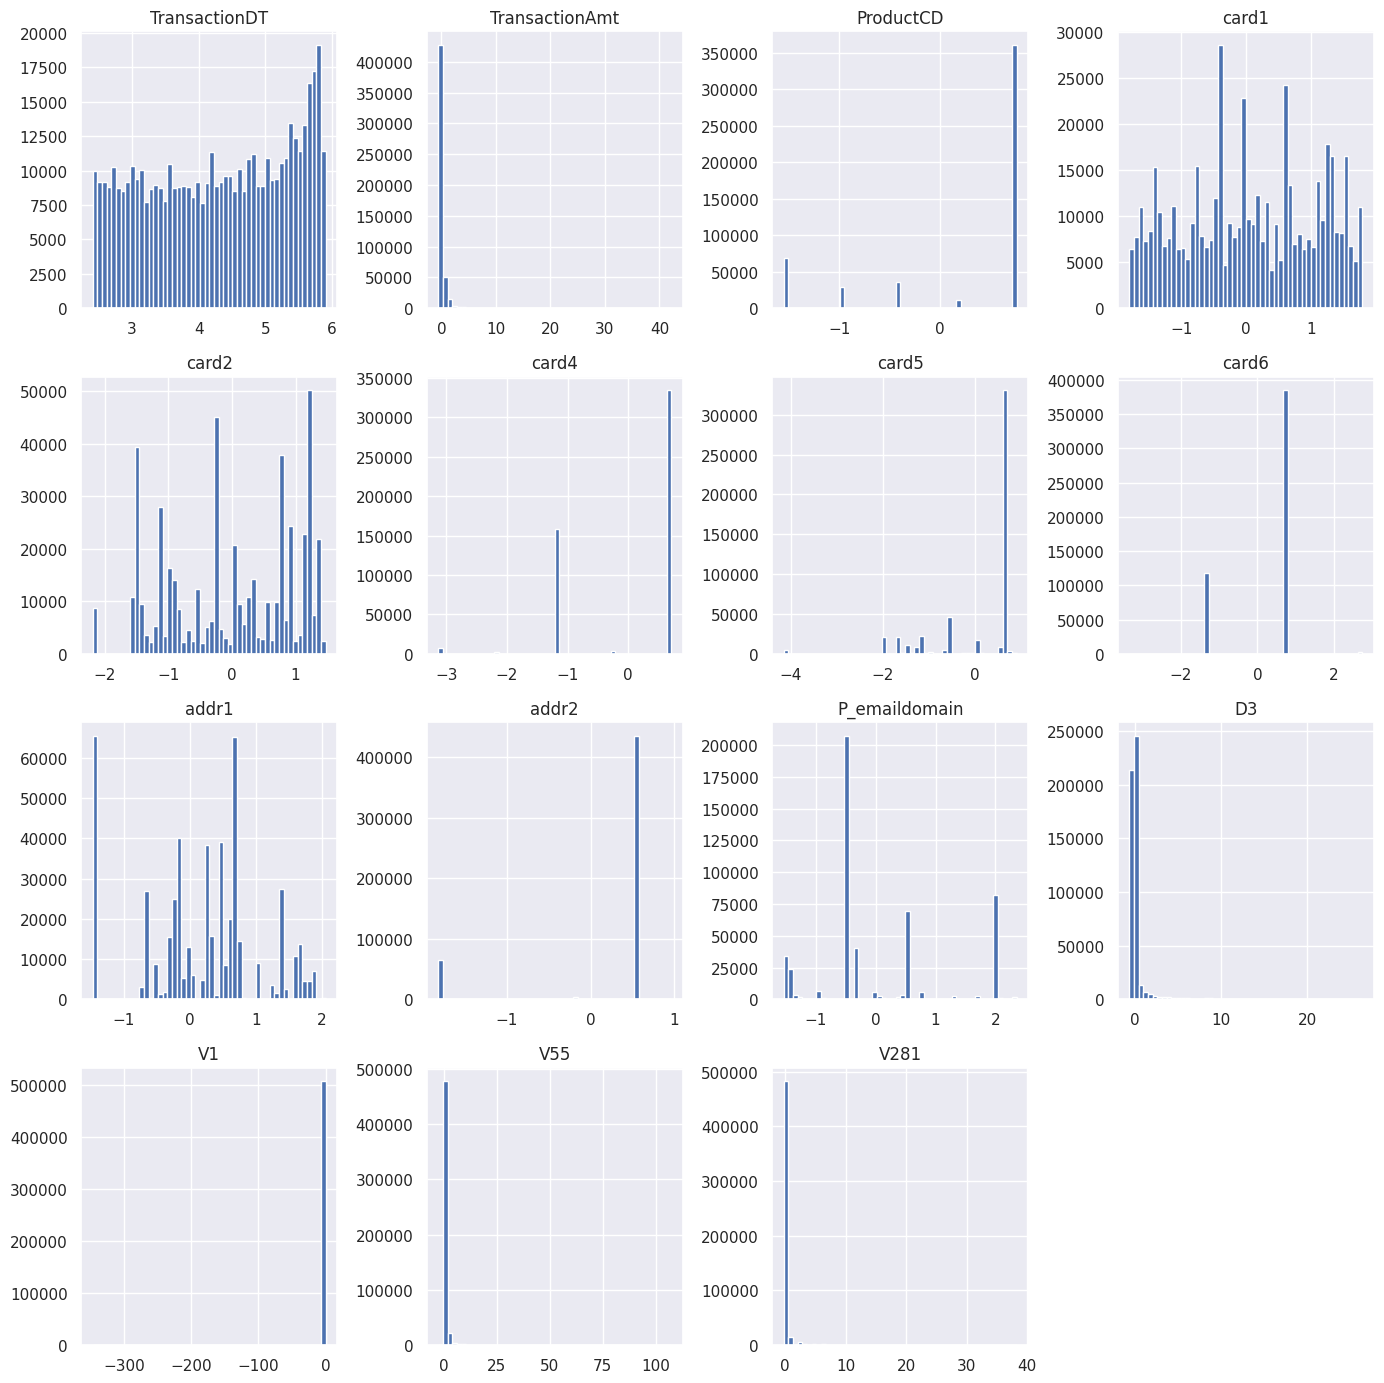

In [188]:
test_df_sc[test_df_sc.columns].hist(bins=50, figsize=(14,14))
plt.tight_layout()

А также на boxplotы

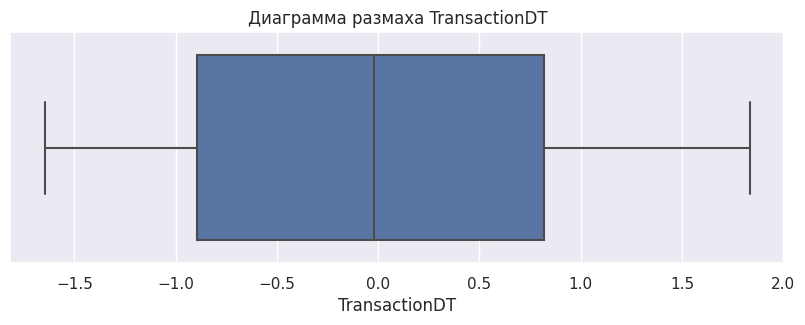

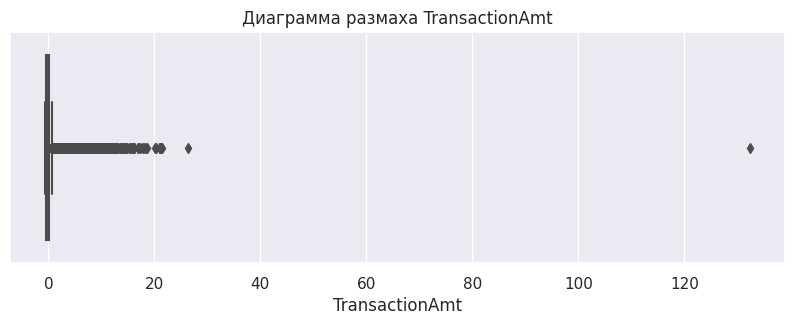

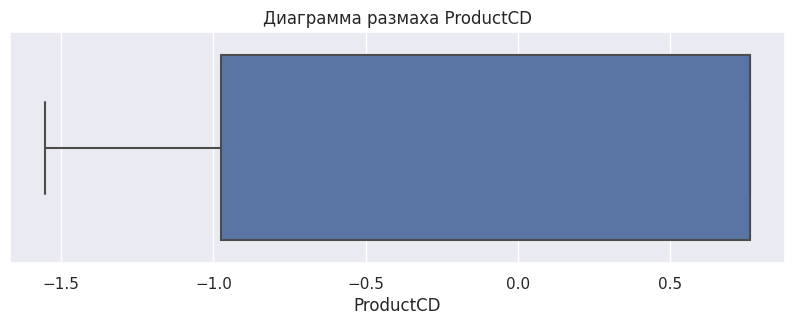

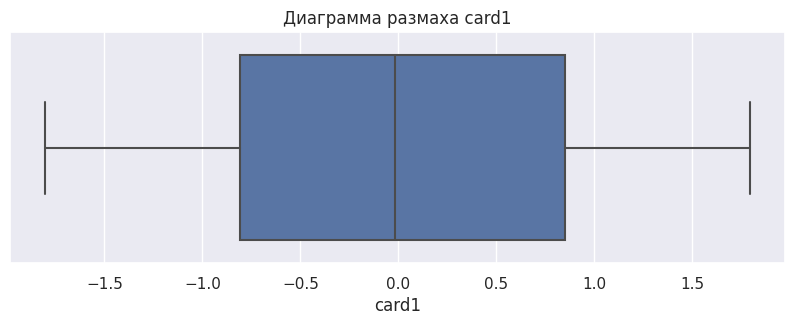

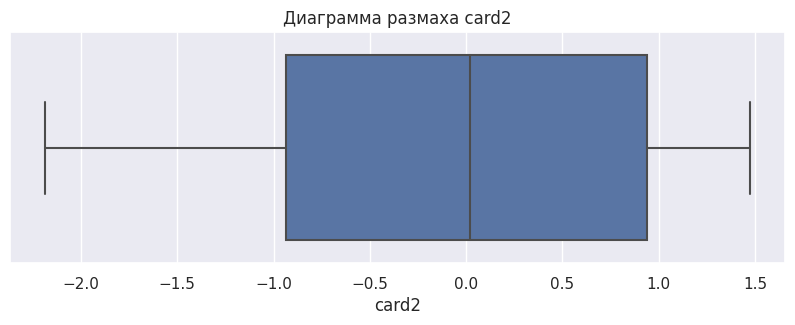

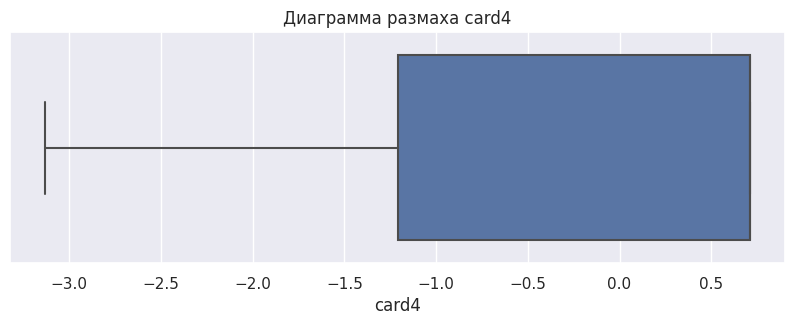

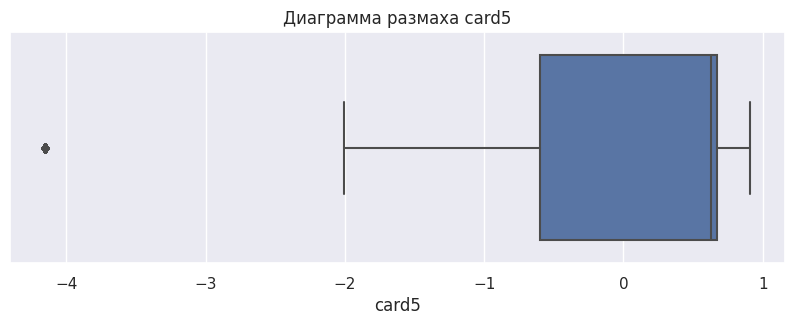

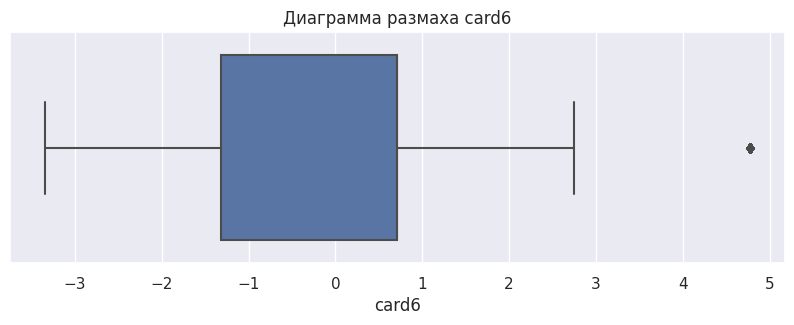

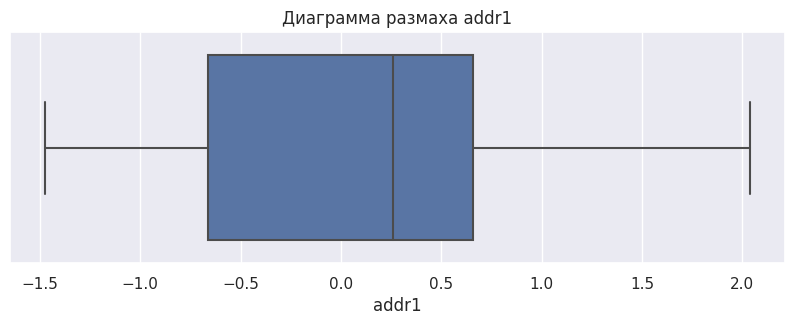

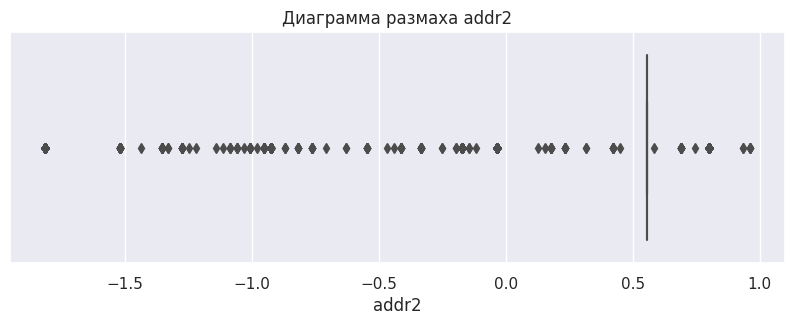

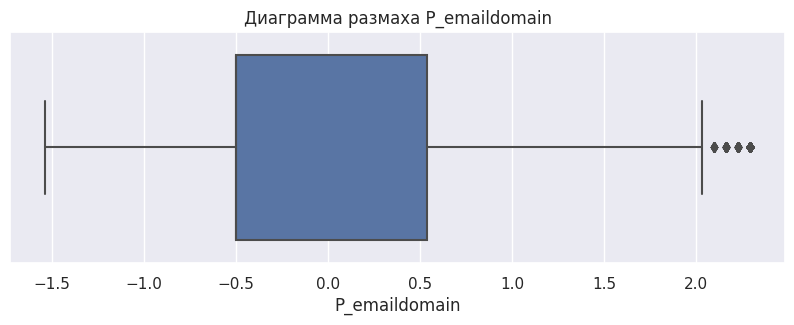

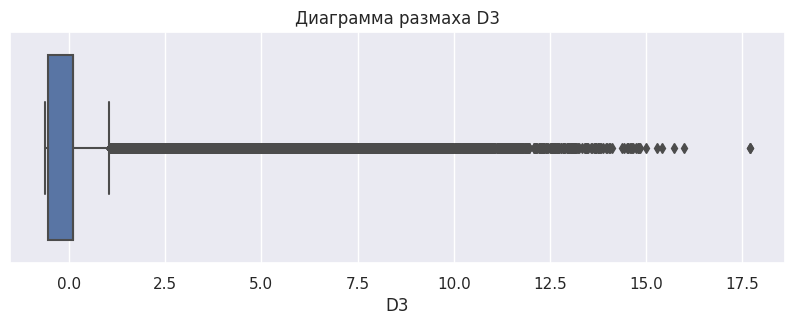

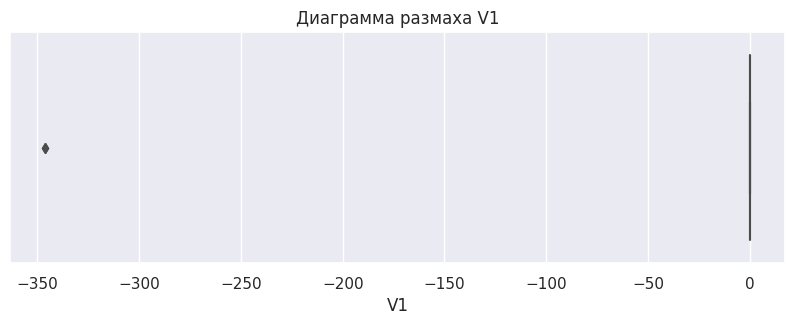

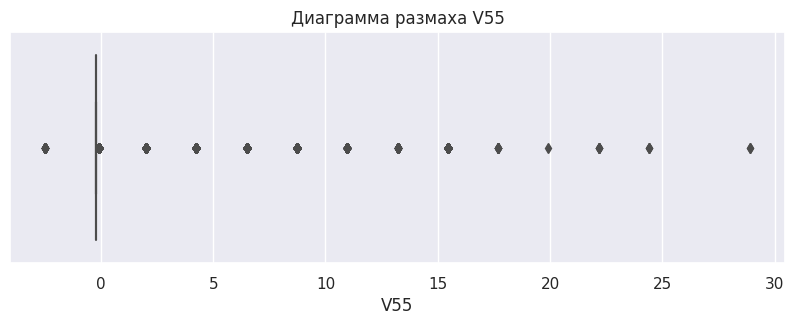

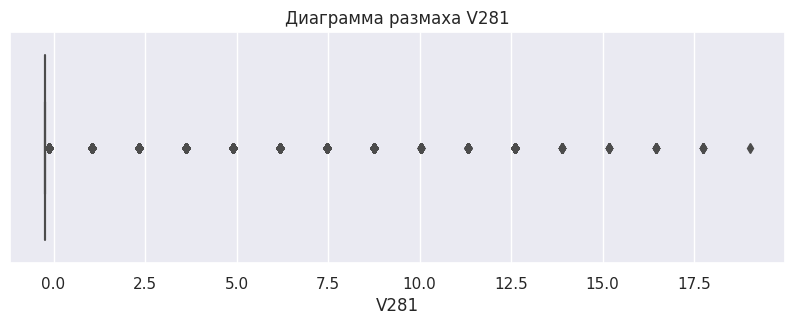

In [189]:
for feat in X_train_sc.columns:
    plt_boxplot(X_train_sc, feat)

Для валидационного датасета:

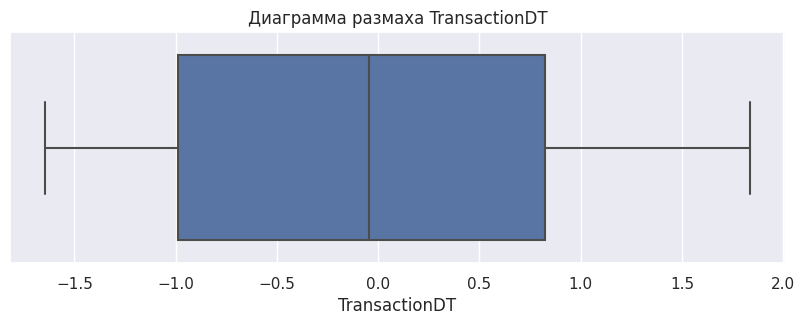

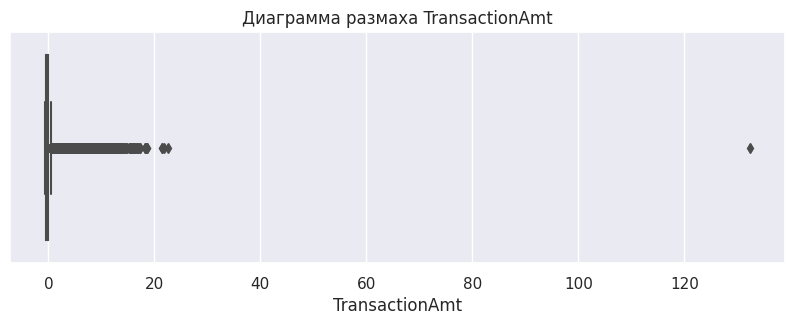

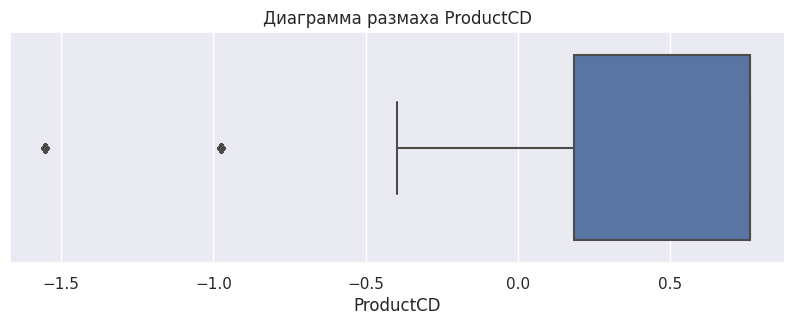

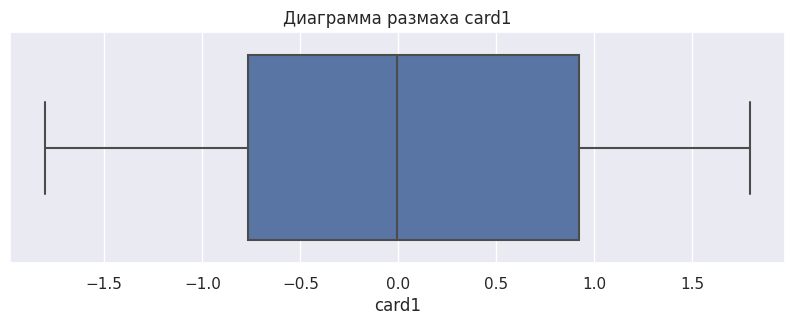

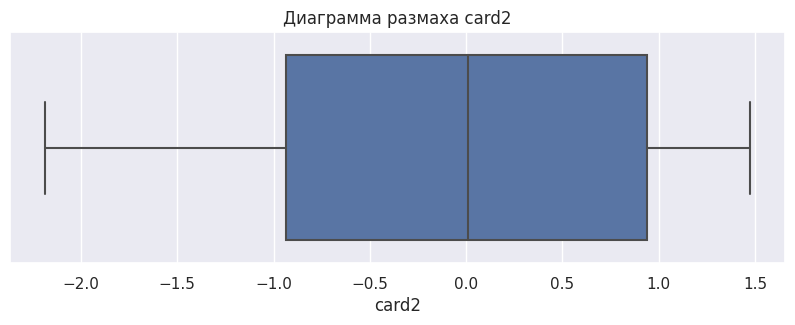

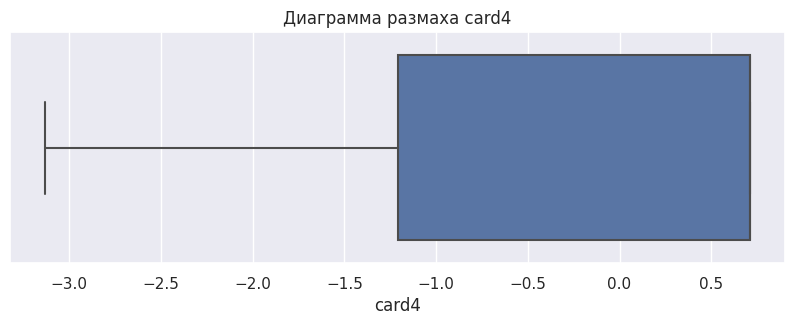

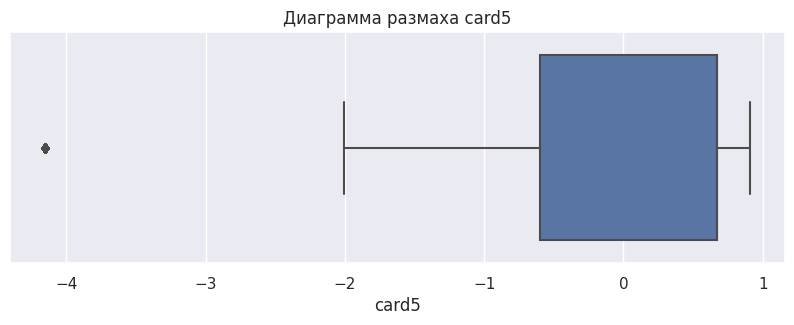

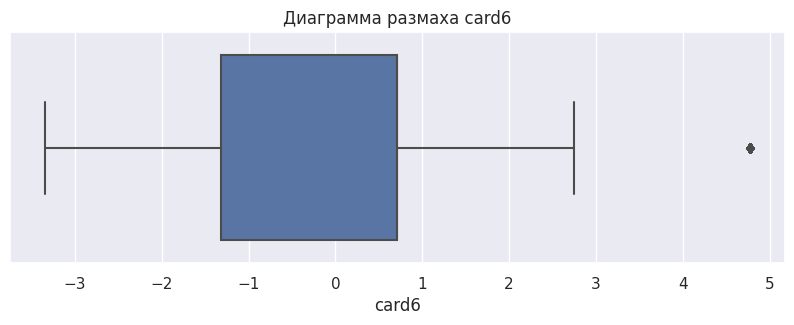

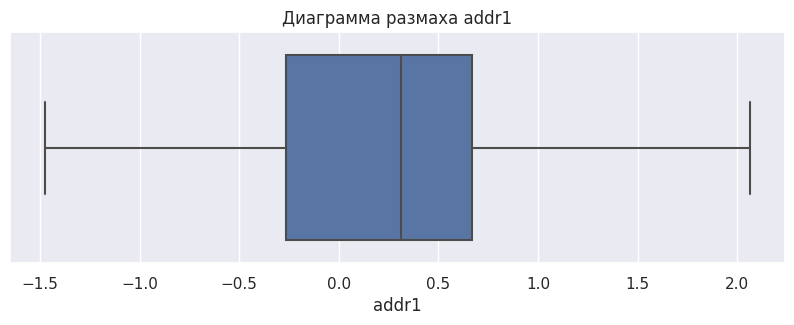

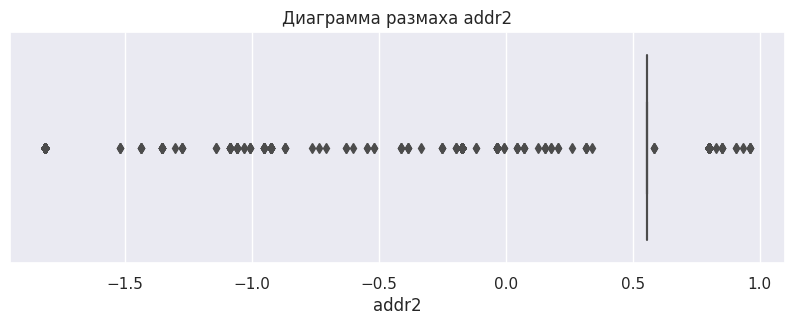

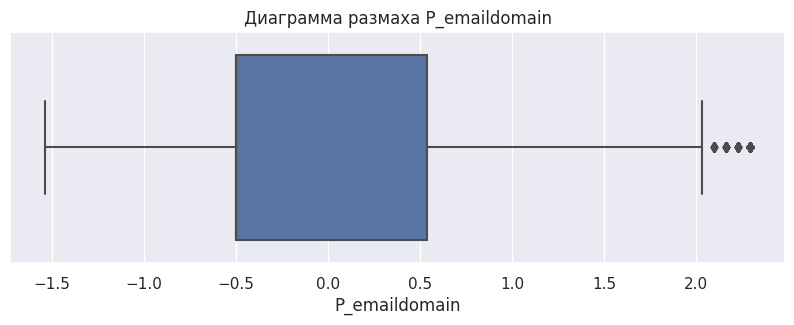

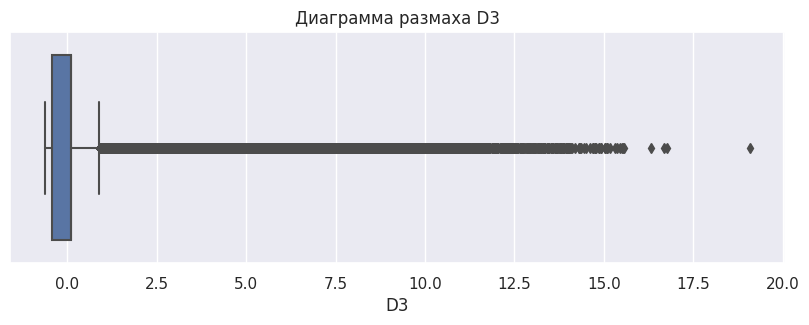

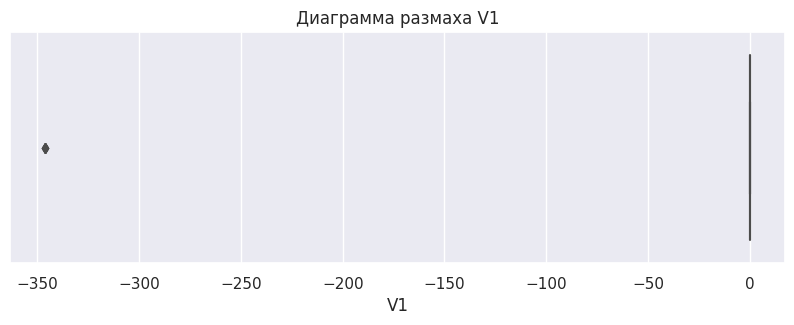

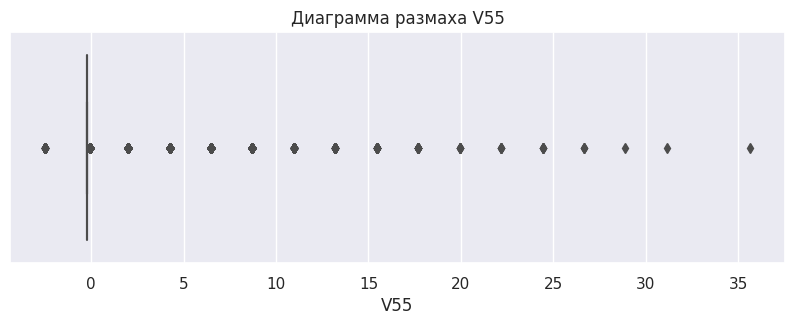

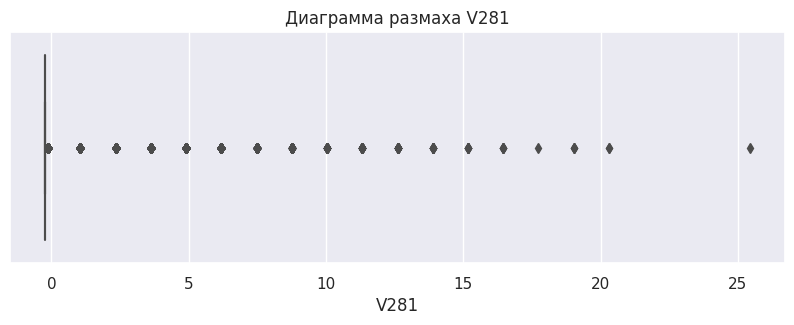

In [190]:
for feat in X_valid_sc.columns:
    plt_boxplot(X_valid_sc, feat)

Для тестового датасета

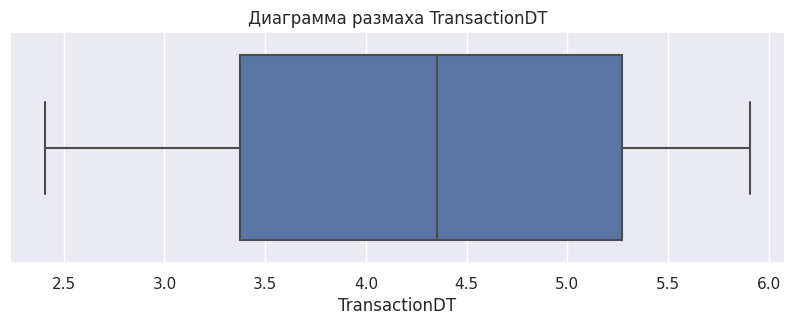

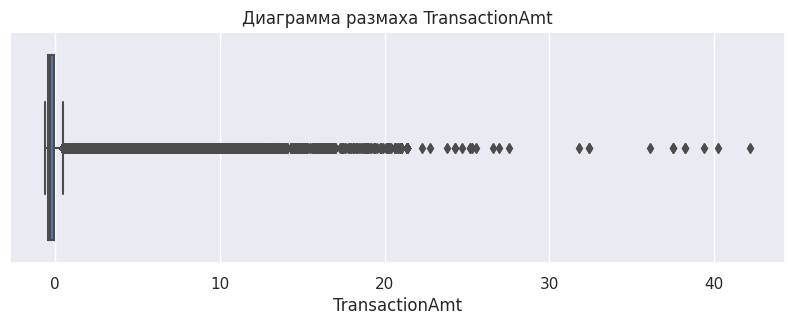

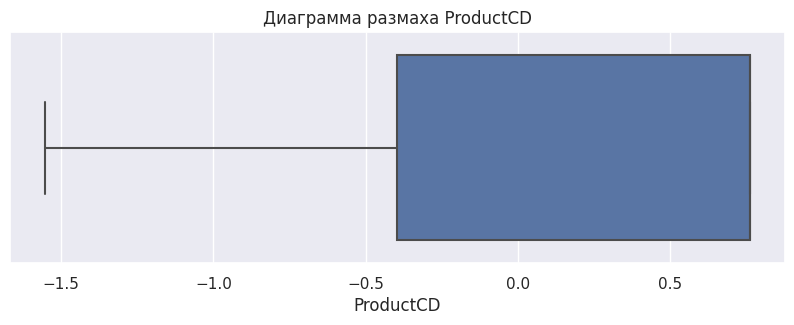

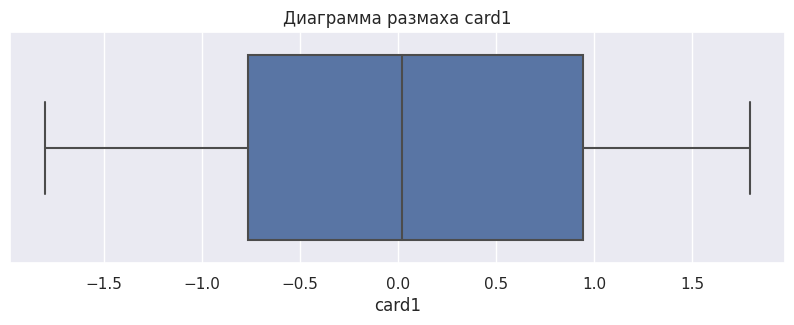

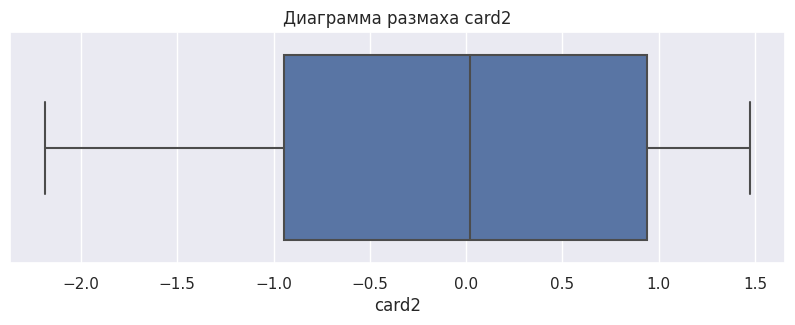

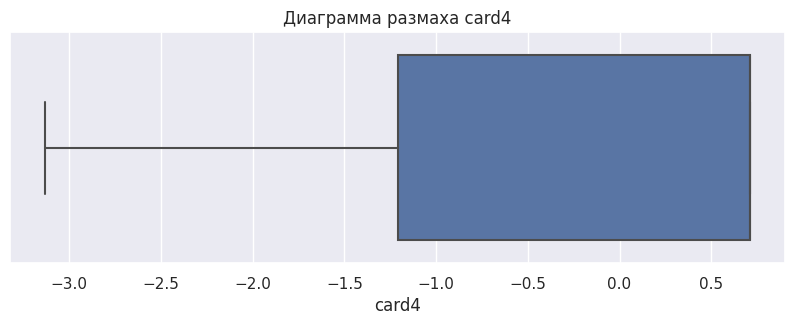

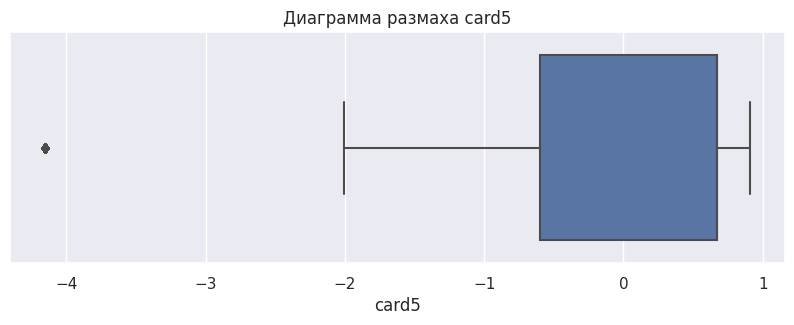

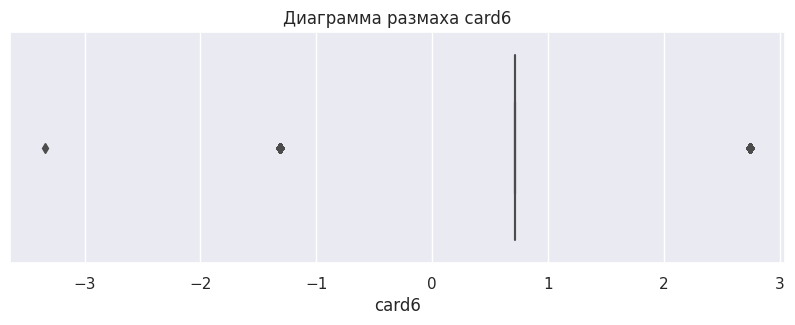

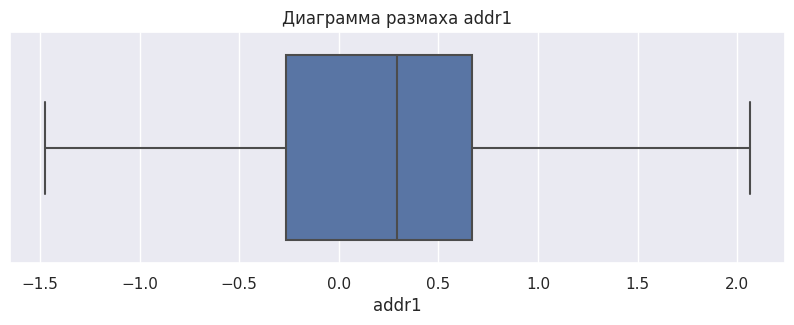

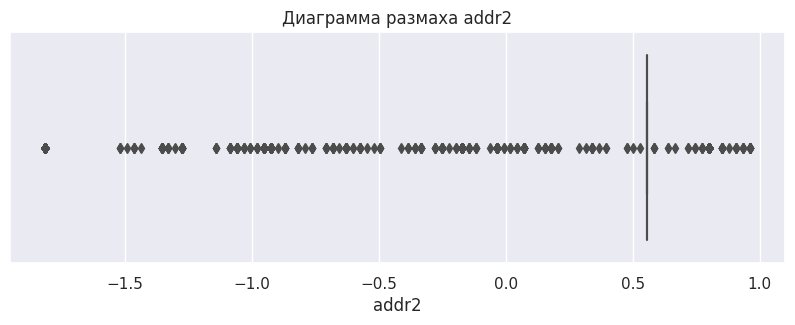

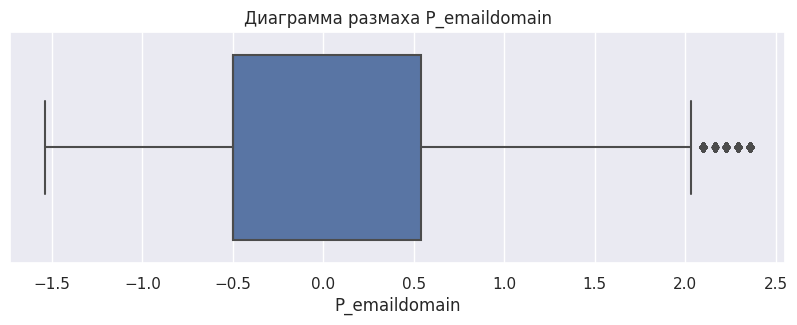

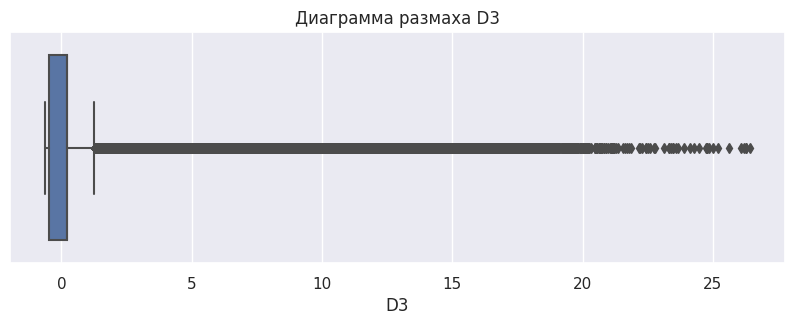

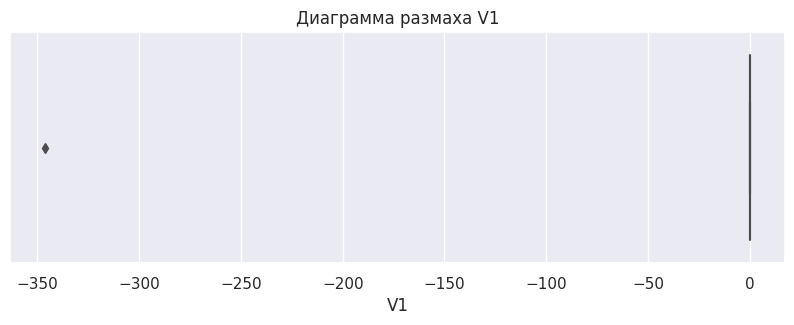

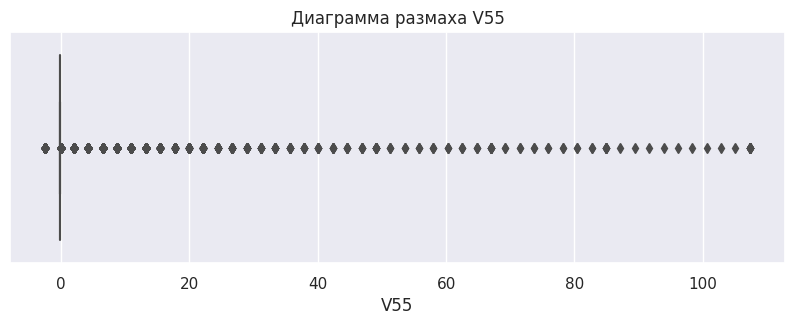

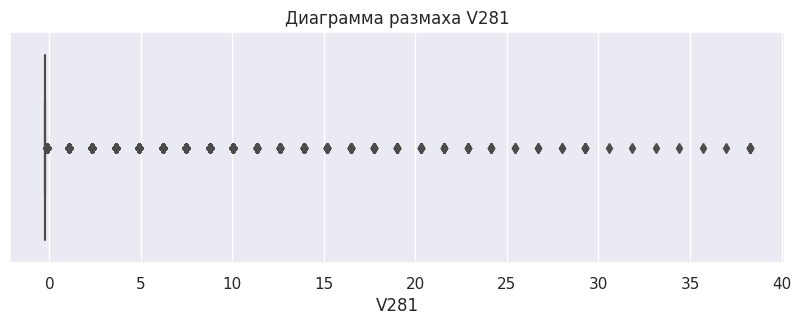

In [191]:
for feat in test_df_sc.columns:
    plt_boxplot(test_df_sc, feat)

Видим, что в признаках ```V1```, ```V55``` и ```V281``` очень много выбросов. Удалим эти признаки из данных

In [192]:
X_train_sc = X_train_sc.drop(columns=['V1', 'V55', 'V281'])
X_valid_sc = X_valid_sc.drop(columns=['V1', 'V55', 'V281'])
test_df_sc = test_df_sc.drop(columns=['V1', 'V55', 'V281'])

In [193]:
X_train_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
476450       1.065571       -0.349117   0.760141  0.729502 -1.503640   
257888      -0.292938       -0.140991   0.760141  0.067405 -1.485378   
292700      -0.063446       -0.539357  -1.551777  1.326093 -0.937517   
440564       0.808042       -0.427997   0.760141  0.068231  1.199139   
63257       -1.343802       -0.444647   0.760141  1.543486 -0.225299   
...               ...             ...        ...       ...       ...   
283162      -0.134408       -0.174083  -0.973798 -0.764557  1.369584   
448422       0.861979        0.034044  -0.973798 -1.432235 -1.308845   
196895      -0.679939       -0.298397  -1.551777  1.104361 -2.185422   
260960      -0.273914        0.034044   0.182162 -0.764557  1.369584   
385880       0.476064        0.708166   0.760141  0.523682 -1.144487   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
476450  0.709928  0.673100  0.714849  0.258862  0.557230      -0.498556   
257888  0.709928  0.673100  0.714849  1.880289  0.557230      -0.498556   
292700  0.709928 -1.197238  0.714849 -1.473712 -1.814915      -0.498556   
440564  0.709928  0.673100  0.714849 -0.218413  0.557230       0.540066   
63257   0.709928  0.673100  0.714849  0.487692  0.557230      -0.498556   
...          ...       ...       ...       ...       ...            ...   
283162  0.709928  0.673100 -1.312902  0.657680  0.557230      -0.498556   
448422  0.709928  0.673100  0.714849  0.258862  0.557230      -1.472263   
196895  0.709928  0.673100 -1.312902 -1.473712 -1.814915      -0.498556   
260960  0.709928  0.673100 -1.312902  0.690371  0.557230       0.540066   
385880  0.709928  0.673100 -1.312902  0.003879  0.557230      -0.498556   

              D3  
476450 -0.545701  
257888  1.213385  
292700 -0.017975  
440564 -0.495442  
63257   0.090643  
...          ...  
283162  0.090643  
448422  0.090643  
196895  0.090643  
260960  0.090643  
385880  0.560010  

[239725 rows x 12 columns]

In [194]:
X_valid_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
249789      -0.346471        0.200337   0.760141  0.865270  0.066894   
296417      -0.042354       -0.224241   0.760141 -0.271290 -0.572277   
589439       1.829722        0.034044  -0.973798 -1.652107  1.369584   
422091       0.702192       -0.186570   0.760141  1.586469 -0.225299   
32528       -1.486884       -0.344747   0.760141  0.741488  0.426047   
...               ...             ...        ...       ...       ...   
559622       1.617825       -0.149108   0.182162  1.251493  0.748676   
85552       -1.262913       -0.382209  -0.973798 -1.218768 -1.503640   
122974      -1.129233       -0.520930  -1.551777  1.274225  1.138265   
414668       0.650096       -0.245054   0.760141  0.411472  0.736501   
440391       0.804852        0.395976   0.760141 -0.645528 -1.406243   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
249789 -1.210328 -1.643569  0.714849  0.657680  0.557230       0.085669   
296417  0.709928  0.673100  0.714849  0.736137  0.557230      -0.498556   
589439  0.709928  0.673100 -1.312902  0.657680  0.557230       0.280410   
422091  0.709928  0.014231 -1.312902  0.487692  0.557230      -1.407349   
32528   0.709928 -0.602131  0.714849  0.258862  0.557230      -1.407349   
...          ...       ...       ...       ...       ...            ...   
559622 -1.210328 -1.962377 -1.312902  0.690371  0.557230       0.540066   
85552  -1.210328  0.524323 -1.312902  0.690371  0.557230      -0.498556   
122974  0.709928 -1.197238  0.714849 -1.473712 -1.814915      -0.303814   
414668  0.709928  0.673100 -1.312902 -0.532238  0.557230      -0.498556   
440391 -1.210328 -1.643569  0.714849  0.657680  0.557230       1.968170   

              D3  
249789  0.092405  
296417  1.816500  
589439  0.092405  
422091  0.233323  
32528   0.092405  
...          ...  
559622 -0.621091  
85552   0.092405  
122974  0.092405  
414668  0.032284  
440391  0.092405  

[177162 rows x 12 columns]

In [195]:
test_df_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0            2.408104       -0.457343   0.760141  0.142624 -1.503640   
1            2.408112       -0.386372   0.760141 -1.125570 -1.503640   
2            2.408123        0.121457   0.760141 -1.083414  1.314798   
3            2.408123        0.595777   0.760141  0.262480  0.012108   
4            2.408124       -0.307492   0.760141  1.715003  0.572143   
...               ...             ...        ...       ...       ...   
506686       5.905919       -0.196232  -1.551777  0.849978  0.103418   
506687       5.905921       -0.539665  -1.551777 -1.356602  0.304300   
506688       5.905929       -0.386372   0.760141  1.434583  0.803462   
506689       5.905932        0.250495   0.760141  1.426317  0.961733   
506690       5.905934       -0.488995  -1.551777 -0.827791 -1.156662   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0       0.709928  0.673100  0.714849 -0.355711  0.557230      -0.498556   
1       0.709928  0.673100  0.714849  0.487692  0.557230      -1.407349   
2       0.709928  0.673100  0.714849  1.618768  0.557230      -0.303814   
3       0.709928 -0.602131  0.714849 -0.126881  0.557230      -0.498556   
4      -1.210328 -1.643569  0.714849  0.258862  0.557230      -0.498556   
...          ...       ...       ...       ...       ...            ...   
506686 -1.210328  0.630592  0.714849  0.389622 -0.170588      -0.498556   
506687 -1.210328  0.630592  0.714849 -1.473712 -1.814915      -0.303814   
506688  0.709928  0.673100  0.714849  0.670757  0.557230      -0.303814   
506689 -1.210328  0.630592  0.714849 -0.309945  0.557230      -0.303814   
506690  0.709928 -1.005954 -1.312902 -1.473712 -1.814915      -0.303814   

              D3  
0       0.057414  
1      -0.445182  
2      -0.369793  
3       0.409231  
4      -0.621091  
...          ...  
506686  0.218112  
506687 -0.219014  
506688  0.218112  
506689  0.218112  
506690  0.218112  

[506691 rows x 12 columns]

Также видим, что данные в тестовом датасете упорядочены по признаку ```TransactionDT```, а этот признак является одним из важных признаков при обучении, как видно в списках важности признаков, поэтому следует также упорядочить наши тренировочный и валидационный датасеты по этому признаку (так данные были изначально упорядочены, но они перемешались после всех обработок)

Временно соединим вместе данные с целевыми метками, чтобы не потерять порядок данных

In [196]:
data_sc = pd.concat([X_train_sc, y_train_balanced], axis=1)
data_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
476450       1.065571       -0.349117   0.760141  0.729502 -1.503640   
257888      -0.292938       -0.140991   0.760141  0.067405 -1.485378   
292700      -0.063446       -0.539357  -1.551777  1.326093 -0.937517   
440564       0.808042       -0.427997   0.760141  0.068231  1.199139   
63257       -1.343802       -0.444647   0.760141  1.543486 -0.225299   
...               ...             ...        ...       ...       ...   
283162      -0.134408       -0.174083  -0.973798 -0.764557  1.369584   
448422       0.861979        0.034044  -0.973798 -1.432235 -1.308845   
196895      -0.679939       -0.298397  -1.551777  1.104361 -2.185422   
260960      -0.273914        0.034044   0.182162 -0.764557  1.369584   
385880       0.476064        0.708166   0.760141  0.523682 -1.144487   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
476450  0.709928  0.673100  0.714849  0.258862  0.557230      -0.498556   
257888  0.709928  0.673100  0.714849  1.880289  0.557230      -0.498556   
292700  0.709928 -1.197238  0.714849 -1.473712 -1.814915      -0.498556   
440564  0.709928  0.673100  0.714849 -0.218413  0.557230       0.540066   
63257   0.709928  0.673100  0.714849  0.487692  0.557230      -0.498556   
...          ...       ...       ...       ...       ...            ...   
283162  0.709928  0.673100 -1.312902  0.657680  0.557230      -0.498556   
448422  0.709928  0.673100  0.714849  0.258862  0.557230      -1.472263   
196895  0.709928  0.673100 -1.312902 -1.473712 -1.814915      -0.498556   
260960  0.709928  0.673100 -1.312902  0.690371  0.557230       0.540066   
385880  0.709928  0.673100 -1.312902  0.003879  0.557230      -0.498556   

              D3  isFraud  
476450 -0.545701        0  
257888  1.213385        0  
292700 -0.017975        0  
440564 -0.495442        0  
63257   0.090643        0  
...          ...      ...  
283162  0.090643        1  
448422  0.090643        1  
196895  0.090643        1  
260960  0.090643        1  
385880  0.560010        1  

[239725 rows x 13 columns]

In [197]:
data_sc = data_sc.sort_values('TransactionDT')
data_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
5           -1.644028       -0.386372   0.760141 -0.781502  1.199139   
8           -1.644022       -0.527898  -0.973798 -1.429135 -1.570601   
10          -1.644019       -0.274454  -1.551777  1.400486 -0.036591   
13          -1.644011       -0.423835   0.760141  0.650357 -0.334871   
15          -1.644004       -0.349117   0.760141 -0.550471  1.199139   
...               ...             ...        ...       ...       ...   
590526       1.834609        0.450297  -0.395818 -1.757497 -1.120138   
590527       1.834611        0.200337   0.760141 -0.674872  1.199139   
590528       1.834616        0.574965   0.760141  1.104981 -1.144487   
590529       1.834617       -0.282983  -1.551777 -0.955293  1.199139   
590532       1.834638        0.262858   0.760141  0.479046  1.442632   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
5       0.709928  0.673100  0.714849  0.311166  0.557230      -0.498556   
8       0.709928  0.673100  0.714849  0.736137  0.557230      -1.472263   
10     -1.210328 -1.282254 -1.312902 -1.473712 -1.814915      -0.498556   
13      0.709928  0.673100  0.714849  0.690371  0.557230      -1.407349   
15      0.709928  0.673100  0.714849  0.592300  0.557230       0.540066   
...          ...       ...       ...       ...       ...            ...   
590526  0.709928  0.673100 -1.312902  0.311166  0.557230      -0.498556   
590527  0.709928  0.673100  0.714849  0.258862  0.557230      -1.407349   
590528 -1.210328 -1.962377 -1.312902  0.487692  0.557230      -0.498556   
590529 -1.210328 -1.218492 -1.312902 -1.473712 -1.814915      -0.498556   
590532 -1.210328  0.630592  0.714849  0.043107  0.557230       0.734807   

              D3  isFraud  
5       0.090643        0  
8       0.090643        0  
10     -0.621091        0  
13     -0.369793        0  
15      0.090643        0  
...          ...      ...  
590526  0.090643        1  
590527 -0.470312        0  
590528  0.090643        0  
590529  0.090643        0  
590532  7.294797        0  

[239725 rows x 13 columns]

Проделаем то же самое для валидационного датасета

In [198]:
valid_data_sc = pd.concat([X_valid_sc, y_valid], axis=1)
valid_data_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
249789      -0.346471        0.200337   0.760141  0.865270  0.066894   
296417      -0.042354       -0.224241   0.760141 -0.271290 -0.572277   
589439       1.829722        0.034044  -0.973798 -1.652107  1.369584   
422091       0.702192       -0.186570   0.760141  1.586469 -0.225299   
32528       -1.486884       -0.344747   0.760141  0.741488  0.426047   
...               ...             ...        ...       ...       ...   
559622       1.617825       -0.149108   0.182162  1.251493  0.748676   
85552       -1.262913       -0.382209  -0.973798 -1.218768 -1.503640   
122974      -1.129233       -0.520930  -1.551777  1.274225  1.138265   
414668       0.650096       -0.245054   0.760141  0.411472  0.736501   
440391       0.804852        0.395976   0.760141 -0.645528 -1.406243   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
249789 -1.210328 -1.643569  0.714849  0.657680  0.557230       0.085669   
296417  0.709928  0.673100  0.714849  0.736137  0.557230      -0.498556   
589439  0.709928  0.673100 -1.312902  0.657680  0.557230       0.280410   
422091  0.709928  0.014231 -1.312902  0.487692  0.557230      -1.407349   
32528   0.709928 -0.602131  0.714849  0.258862  0.557230      -1.407349   
...          ...       ...       ...       ...       ...            ...   
559622 -1.210328 -1.962377 -1.312902  0.690371  0.557230       0.540066   
85552  -1.210328  0.524323 -1.312902  0.690371  0.557230      -0.498556   
122974  0.709928 -1.197238  0.714849 -1.473712 -1.814915      -0.303814   
414668  0.709928  0.673100 -1.312902 -0.532238  0.557230      -0.498556   
440391 -1.210328 -1.643569  0.714849  0.657680  0.557230       1.968170   

              D3  isFraud  
249789  0.092405        0  
296417  1.816500        0  
589439  0.092405        0  
422091  0.233323        0  
32528   0.092405        0  
...          ...      ...  
559622 -0.621091        0  
85552   0.092405        0  
122974  0.092405        0  
414668  0.032284        0  
440391  0.092405        0  

[177162 rows x 13 columns]

In [199]:
valid_data_sc = valid_data_sc.sort_values('TransactionDT')
valid_data_sc

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0           -1.644052       -0.305203   0.760141  0.869403 -2.185422   
1           -1.644052       -0.469623   0.760141 -1.439054  0.279950   
3           -1.644030       -0.382209   0.760141  1.738561  1.272187   
12          -1.644016       -0.382209   0.760141 -1.226001  0.365173   
19          -1.643979        0.183895   0.760141 -0.560803 -1.503640   
...               ...             ...        ...       ...       ...   
590515       1.834546       -0.138701   0.760141 -1.136522 -0.225299   
590520       1.834589       -0.203221   0.760141  1.535633 -0.401832   
590521       1.834593       -0.386884  -1.551777  0.475326 -0.322696   
590522       1.834598       -0.363478   0.760141 -1.354122  1.223488   
590533       1.834643       -0.140991   0.760141  0.692719 -0.225299   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0      -2.170456 -1.112223 -1.312902  0.592300  0.557230       0.540066   
1      -1.210328 -1.962377 -1.312902  0.657680  0.557230      -0.498556   
3      -1.210328 -1.643569  0.714849  1.644920  0.557230       1.968170   
12      0.709928  0.673100  0.714849 -0.133419  0.557230       1.643601   
19      0.709928  0.673100  0.714849  0.258862  0.557230      -0.498556   
...          ...       ...       ...       ...       ...            ...   
590515  0.709928  0.673100  0.714849  1.618768  0.557230       1.968170   
590520  0.709928  0.673100  0.714849 -0.133419  0.557230       1.968170   
590521 -1.210328  0.630592  0.714849 -1.473712 -1.814915       2.227825   
590522  0.709928 -0.602131  0.714849  0.657680  0.557230      -0.498556   
590533  0.709928  0.673100  0.714849  1.703763  0.557230      -0.498556   

              D3  isFraud  
0      -0.294403        0  
1       0.092405        0  
3      -0.621091        0  
12     -0.344663        0  
19     -0.570831        0  
...          ...      ...  
590515 -0.570831        0  
590520 -0.043105        0  
590521 -0.621091        0  
590522  0.183063        0  
590533 -0.470312        0  

[177162 rows x 13 columns]

Напишем функцию для отбора данных от выбросов

In [200]:
def data_without_feat_emsns(df, feature):
    first_qrt = df[feature].describe()['25%']
    third_qrt = df[feature].describe()['75%']
    iqr = third_qrt - first_qrt
    
    condition = (df[feature] > (first_qrt - 3 * iqr)) & \
    (df[feature] < (third_qrt + 3 * iqr))
    
    df = df[condition]
    return df

In [201]:
for feat in X_train_sc.columns:
    train_sc_no_emsms = data_without_feat_emsns(data_sc, feat)

In [202]:
train_sc_no_emsms

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
5           -1.644028       -0.386372   0.760141 -0.781502  1.199139   
8           -1.644022       -0.527898  -0.973798 -1.429135 -1.570601   
10          -1.644019       -0.274454  -1.551777  1.400486 -0.036591   
13          -1.644011       -0.423835   0.760141  0.650357 -0.334871   
15          -1.644004       -0.349117   0.760141 -0.550471  1.199139   
...               ...             ...        ...       ...       ...   
590526       1.834609        0.450297  -0.395818 -1.757497 -1.120138   
590526       1.834609        0.450297  -0.395818 -1.757497 -1.120138   
590527       1.834611        0.200337   0.760141 -0.674872  1.199139   
590528       1.834616        0.574965   0.760141  1.104981 -1.144487   
590529       1.834617       -0.282983  -1.551777 -0.955293  1.199139   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
5       0.709928  0.673100  0.714849  0.311166  0.557230      -0.498556   
8       0.709928  0.673100  0.714849  0.736137  0.557230      -1.472263   
10     -1.210328 -1.282254 -1.312902 -1.473712 -1.814915      -0.498556   
13      0.709928  0.673100  0.714849  0.690371  0.557230      -1.407349   
15      0.709928  0.673100  0.714849  0.592300  0.557230       0.540066   
...          ...       ...       ...       ...       ...            ...   
590526  0.709928  0.673100 -1.312902  0.311166  0.557230      -0.498556   
590526  0.709928  0.673100 -1.312902  0.311166  0.557230      -0.498556   
590527  0.709928  0.673100  0.714849  0.258862  0.557230      -1.407349   
590528 -1.210328 -1.962377 -1.312902  0.487692  0.557230      -0.498556   
590529 -1.210328 -1.218492 -1.312902 -1.473712 -1.814915      -0.498556   

              D3  isFraud  
5       0.090643        0  
8       0.090643        0  
10     -0.621091        0  
13     -0.369793        0  
15      0.090643        0  
...          ...      ...  
590526  0.090643        1  
590526  0.090643        1  
590527 -0.470312        0  
590528  0.090643        0  
590529  0.090643        0  

[233789 rows x 13 columns]

In [203]:
for feat in X_train_sc.columns:
    valid_sc_no_emsms = data_without_feat_emsns(valid_data_sc, feat)

In [204]:
valid_sc_no_emsms

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0           -1.644052       -0.305203   0.760141  0.869403 -2.185422   
1           -1.644052       -0.469623   0.760141 -1.439054  0.279950   
3           -1.644030       -0.382209   0.760141  1.738561  1.272187   
12          -1.644016       -0.382209   0.760141 -1.226001  0.365173   
19          -1.643979        0.183895   0.760141 -0.560803 -1.503640   
...               ...             ...        ...       ...       ...   
590515       1.834546       -0.138701   0.760141 -1.136522 -0.225299   
590520       1.834589       -0.203221   0.760141  1.535633 -0.401832   
590521       1.834593       -0.386884  -1.551777  0.475326 -0.322696   
590522       1.834598       -0.363478   0.760141 -1.354122  1.223488   
590533       1.834643       -0.140991   0.760141  0.692719 -0.225299   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0      -2.170456 -1.112223 -1.312902  0.592300  0.557230       0.540066   
1      -1.210328 -1.962377 -1.312902  0.657680  0.557230      -0.498556   
3      -1.210328 -1.643569  0.714849  1.644920  0.557230       1.968170   
12      0.709928  0.673100  0.714849 -0.133419  0.557230       1.643601   
19      0.709928  0.673100  0.714849  0.258862  0.557230      -0.498556   
...          ...       ...       ...       ...       ...            ...   
590515  0.709928  0.673100  0.714849  1.618768  0.557230       1.968170   
590520  0.709928  0.673100  0.714849 -0.133419  0.557230       1.968170   
590521 -1.210328  0.630592  0.714849 -1.473712 -1.814915       2.227825   
590522  0.709928 -0.602131  0.714849  0.657680  0.557230      -0.498556   
590533  0.709928  0.673100  0.714849  1.703763  0.557230      -0.498556   

              D3  isFraud  
0      -0.294403        0  
1       0.092405        0  
3      -0.621091        0  
12     -0.344663        0  
19     -0.570831        0  
...          ...      ...  
590515 -0.570831        0  
590520 -0.043105        0  
590521 -0.621091        0  
590522  0.183063        0  
590533 -0.470312        0  

[170208 rows x 13 columns]

Снова выполним упорядочивание данных по признаку ```TransactionDT```

In [205]:
train_sc_no_emsms = train_sc_no_emsms.sort_values('TransactionDT')
train_sc_no_emsms

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
5           -1.644028       -0.386372   0.760141 -0.781502  1.199139   
8           -1.644022       -0.527898  -0.973798 -1.429135 -1.570601   
10          -1.644019       -0.274454  -1.551777  1.400486 -0.036591   
13          -1.644011       -0.423835   0.760141  0.650357 -0.334871   
15          -1.644004       -0.349117   0.760141 -0.550471  1.199139   
...               ...             ...        ...       ...       ...   
590526       1.834609        0.450297  -0.395818 -1.757497 -1.120138   
590526       1.834609        0.450297  -0.395818 -1.757497 -1.120138   
590527       1.834611        0.200337   0.760141 -0.674872  1.199139   
590528       1.834616        0.574965   0.760141  1.104981 -1.144487   
590529       1.834617       -0.282983  -1.551777 -0.955293  1.199139   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
5       0.709928  0.673100  0.714849  0.311166  0.557230      -0.498556   
8       0.709928  0.673100  0.714849  0.736137  0.557230      -1.472263   
10     -1.210328 -1.282254 -1.312902 -1.473712 -1.814915      -0.498556   
13      0.709928  0.673100  0.714849  0.690371  0.557230      -1.407349   
15      0.709928  0.673100  0.714849  0.592300  0.557230       0.540066   
...          ...       ...       ...       ...       ...            ...   
590526  0.709928  0.673100 -1.312902  0.311166  0.557230      -0.498556   
590526  0.709928  0.673100 -1.312902  0.311166  0.557230      -0.498556   
590527  0.709928  0.673100  0.714849  0.258862  0.557230      -1.407349   
590528 -1.210328 -1.962377 -1.312902  0.487692  0.557230      -0.498556   
590529 -1.210328 -1.218492 -1.312902 -1.473712 -1.814915      -0.498556   

              D3  isFraud  
5       0.090643        0  
8       0.090643        0  
10     -0.621091        0  
13     -0.369793        0  
15      0.090643        0  
...          ...      ...  
590526  0.090643        1  
590526  0.090643        1  
590527 -0.470312        0  
590528  0.090643        0  
590529  0.090643        0  

[233789 rows x 13 columns]

In [206]:
valid_sc_no_emsms = valid_sc_no_emsms.sort_values('TransactionDT')
valid_sc_no_emsms

TransactionDT  TransactionAmt  ProductCD     card1     card2  \
0           -1.644052       -0.305203   0.760141  0.869403 -2.185422   
1           -1.644052       -0.469623   0.760141 -1.439054  0.279950   
3           -1.644030       -0.382209   0.760141  1.738561  1.272187   
12          -1.644016       -0.382209   0.760141 -1.226001  0.365173   
19          -1.643979        0.183895   0.760141 -0.560803 -1.503640   
...               ...             ...        ...       ...       ...   
590515       1.834546       -0.138701   0.760141 -1.136522 -0.225299   
590520       1.834589       -0.203221   0.760141  1.535633 -0.401832   
590521       1.834593       -0.386884  -1.551777  0.475326 -0.322696   
590522       1.834598       -0.363478   0.760141 -1.354122  1.223488   
590533       1.834643       -0.140991   0.760141  0.692719 -0.225299   

           card4     card5     card6     addr1     addr2  P_emaildomain  \
0      -2.170456 -1.112223 -1.312902  0.592300  0.557230       0.540066   
1      -1.210328 -1.962377 -1.312902  0.657680  0.557230      -0.498556   
3      -1.210328 -1.643569  0.714849  1.644920  0.557230       1.968170   
12      0.709928  0.673100  0.714849 -0.133419  0.557230       1.643601   
19      0.709928  0.673100  0.714849  0.258862  0.557230      -0.498556   
...          ...       ...       ...       ...       ...            ...   
590515  0.709928  0.673100  0.714849  1.618768  0.557230       1.968170   
590520  0.709928  0.673100  0.714849 -0.133419  0.557230       1.968170   
590521 -1.210328  0.630592  0.714849 -1.473712 -1.814915       2.227825   
590522  0.709928 -0.602131  0.714849  0.657680  0.557230      -0.498556   
590533  0.709928  0.673100  0.714849  1.703763  0.557230      -0.498556   

              D3  isFraud  
0      -0.294403        0  
1       0.092405        0  
3      -0.621091        0  
12     -0.344663        0  
19     -0.570831        0  
...          ...      ...  
590515 -0.570831        0  
590520 -0.043105        0  
590521 -0.621091        0  
590522  0.183063        0  
590533 -0.470312        0  

[170208 rows x 13 columns]

Теперь можно снова отделить данные от целевых меток

In [207]:
y_train_no_ems = train_sc_no_emsms['isFraud']
X_train_no_ems = train_sc_no_emsms.drop(columns=['isFraud'])

In [208]:
print(y_train_no_ems.shape)
print(X_train_no_ems.shape)

(233789,)
(233789, 12)


In [209]:
y_valid_no_ems = valid_sc_no_emsms['isFraud']
X_valid_no_ems = valid_sc_no_emsms.drop(columns=['isFraud'])
print(y_valid_no_ems.shape)
print(X_valid_no_ems.shape)

(170208,)
(170208, 12)


Посмотрим на распределения данных и boxplotы после очистки данных от выбросов

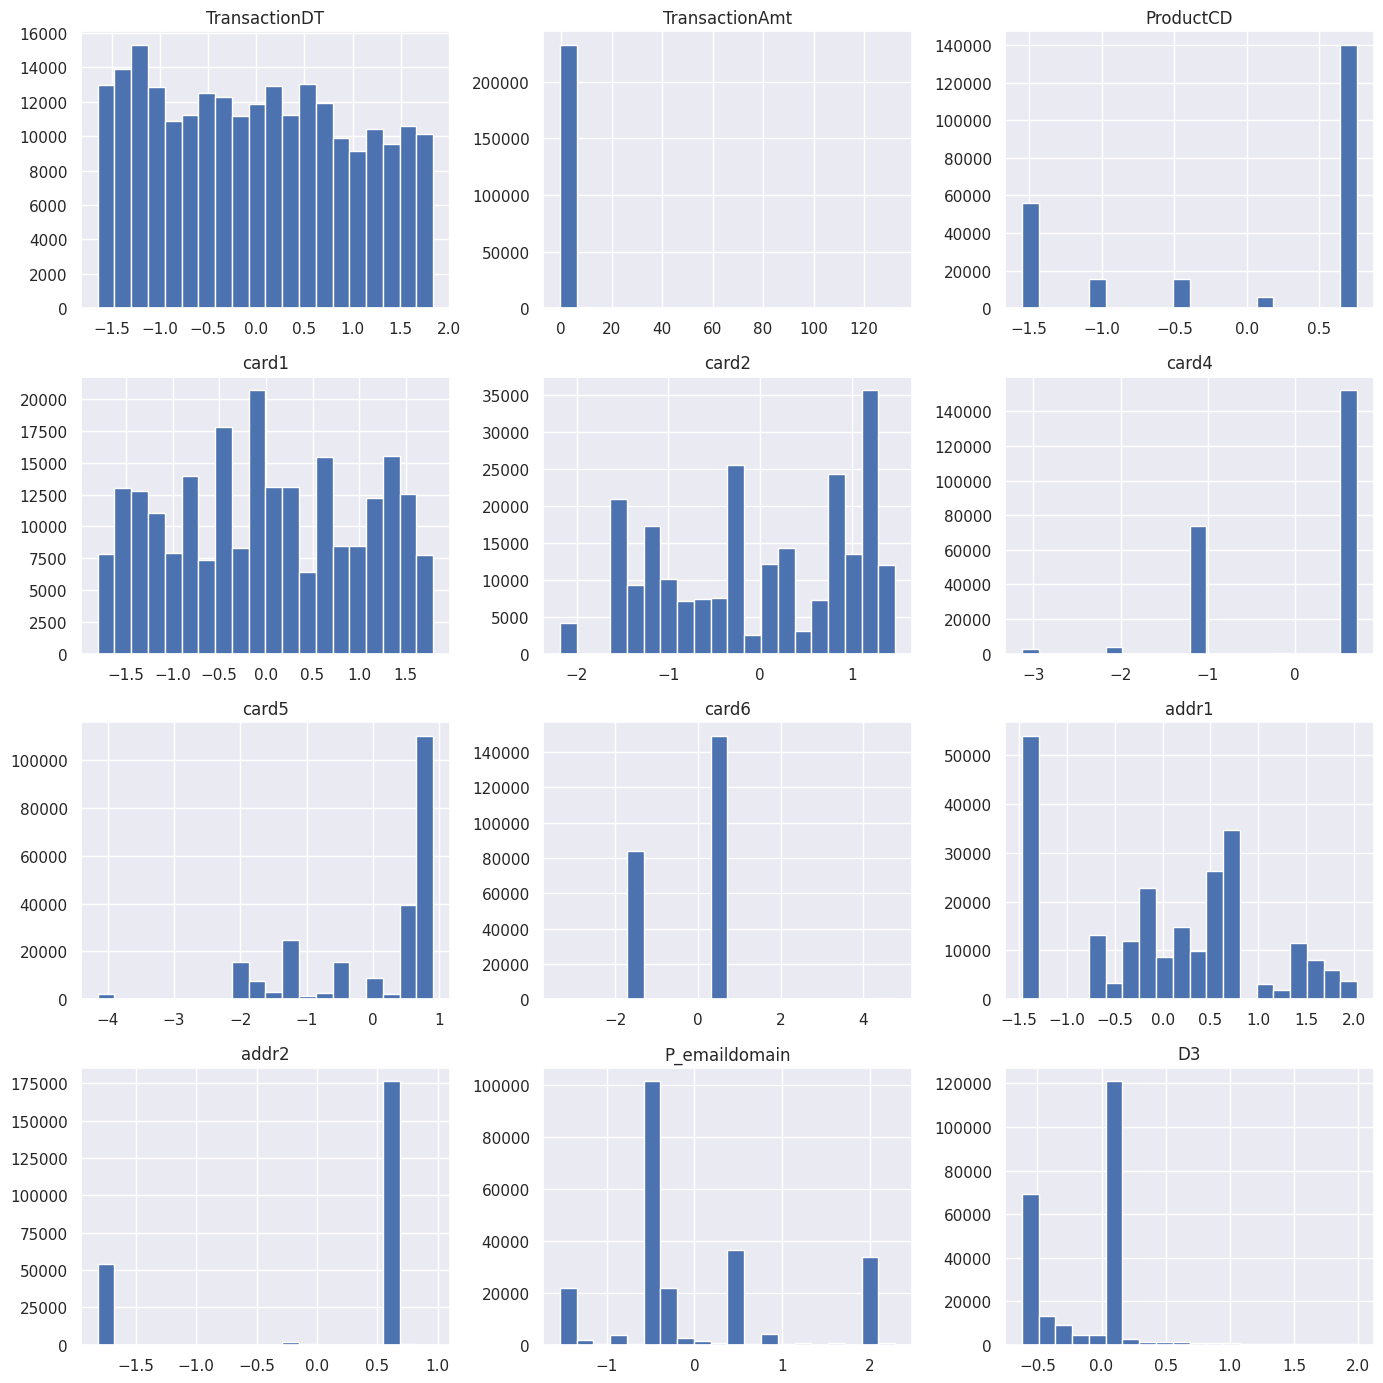

In [210]:
X_train_no_ems.hist(bins=20, figsize=(14,14))
plt.tight_layout()

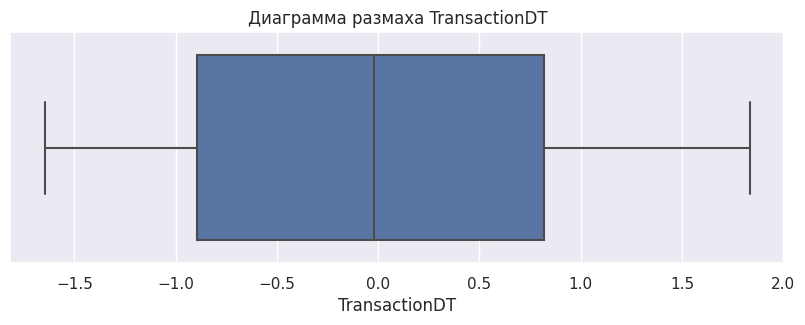

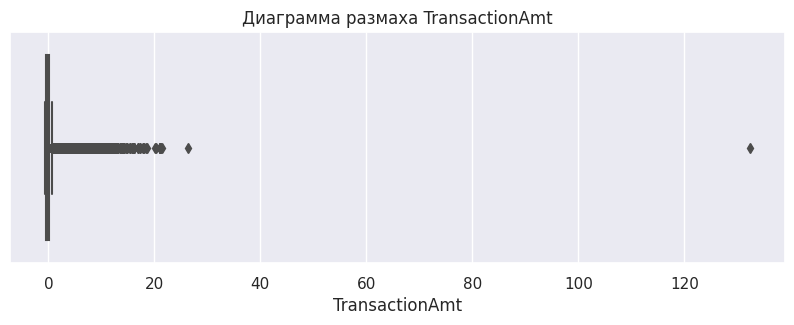

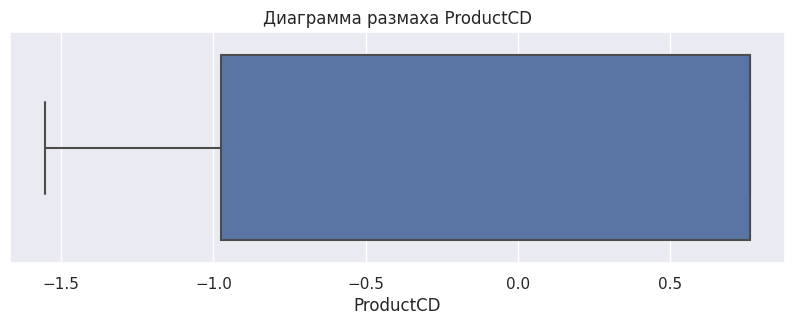

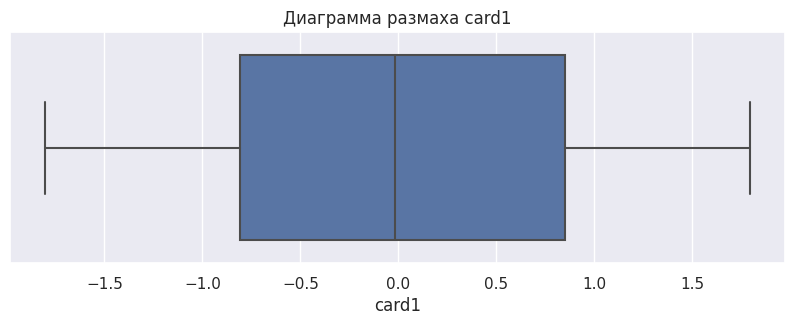

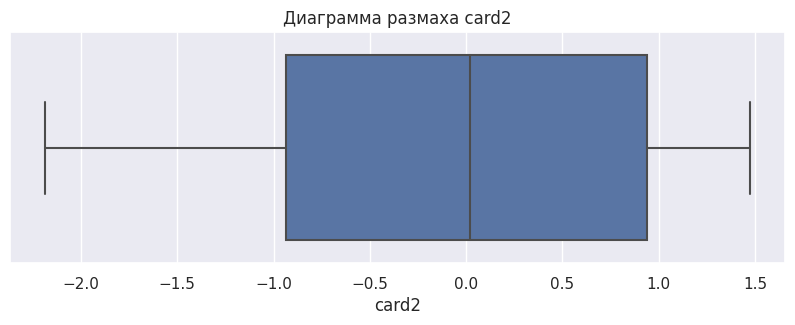

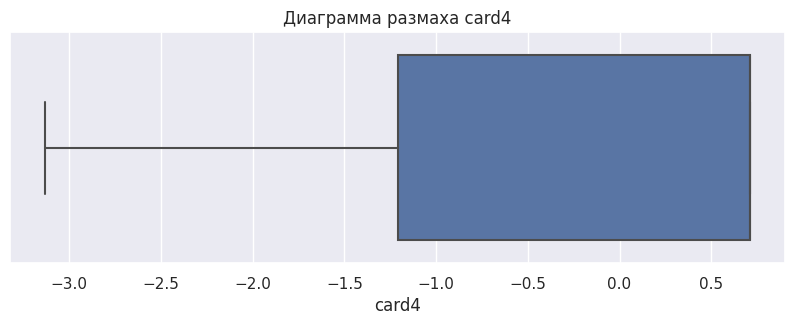

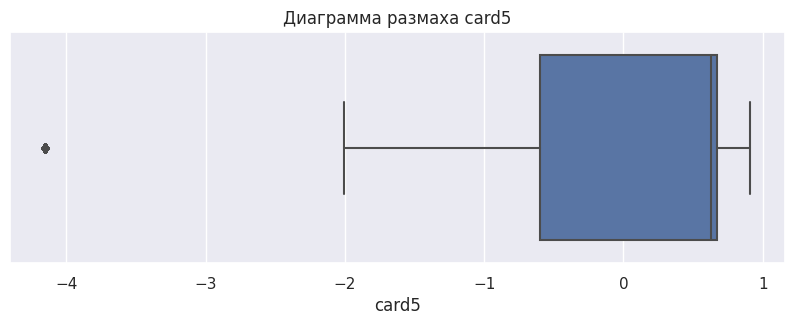

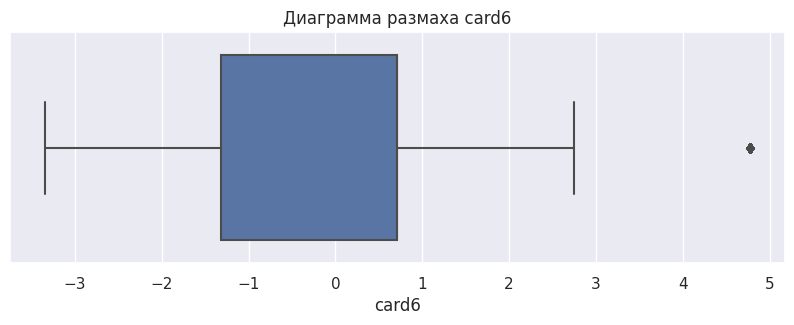

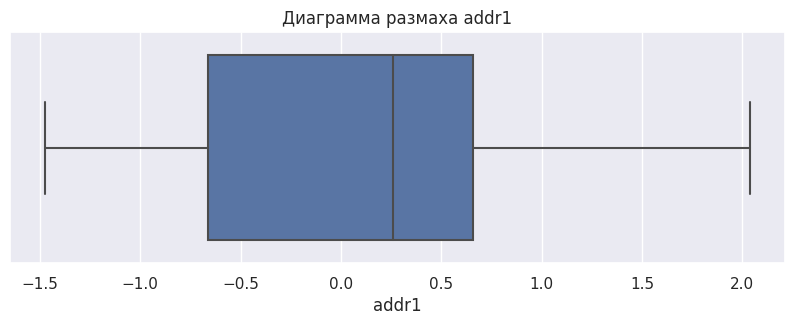

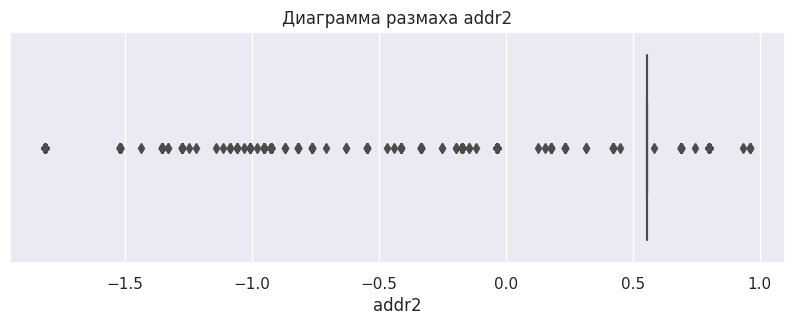

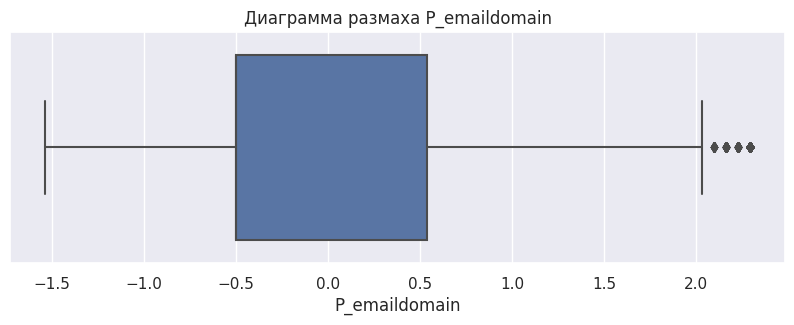

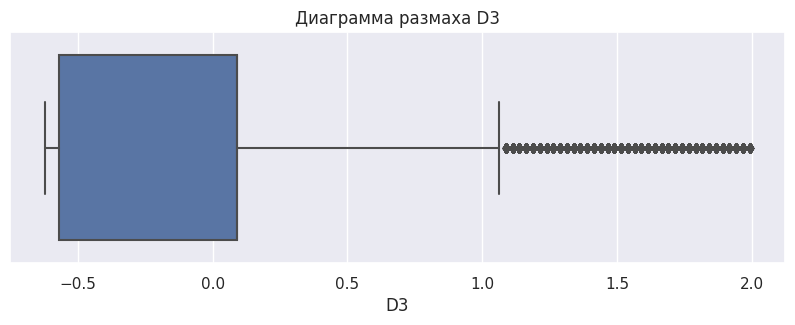

In [211]:
for feat in X_train_no_ems.columns:
    plt_boxplot(X_train_no_ems, feat)

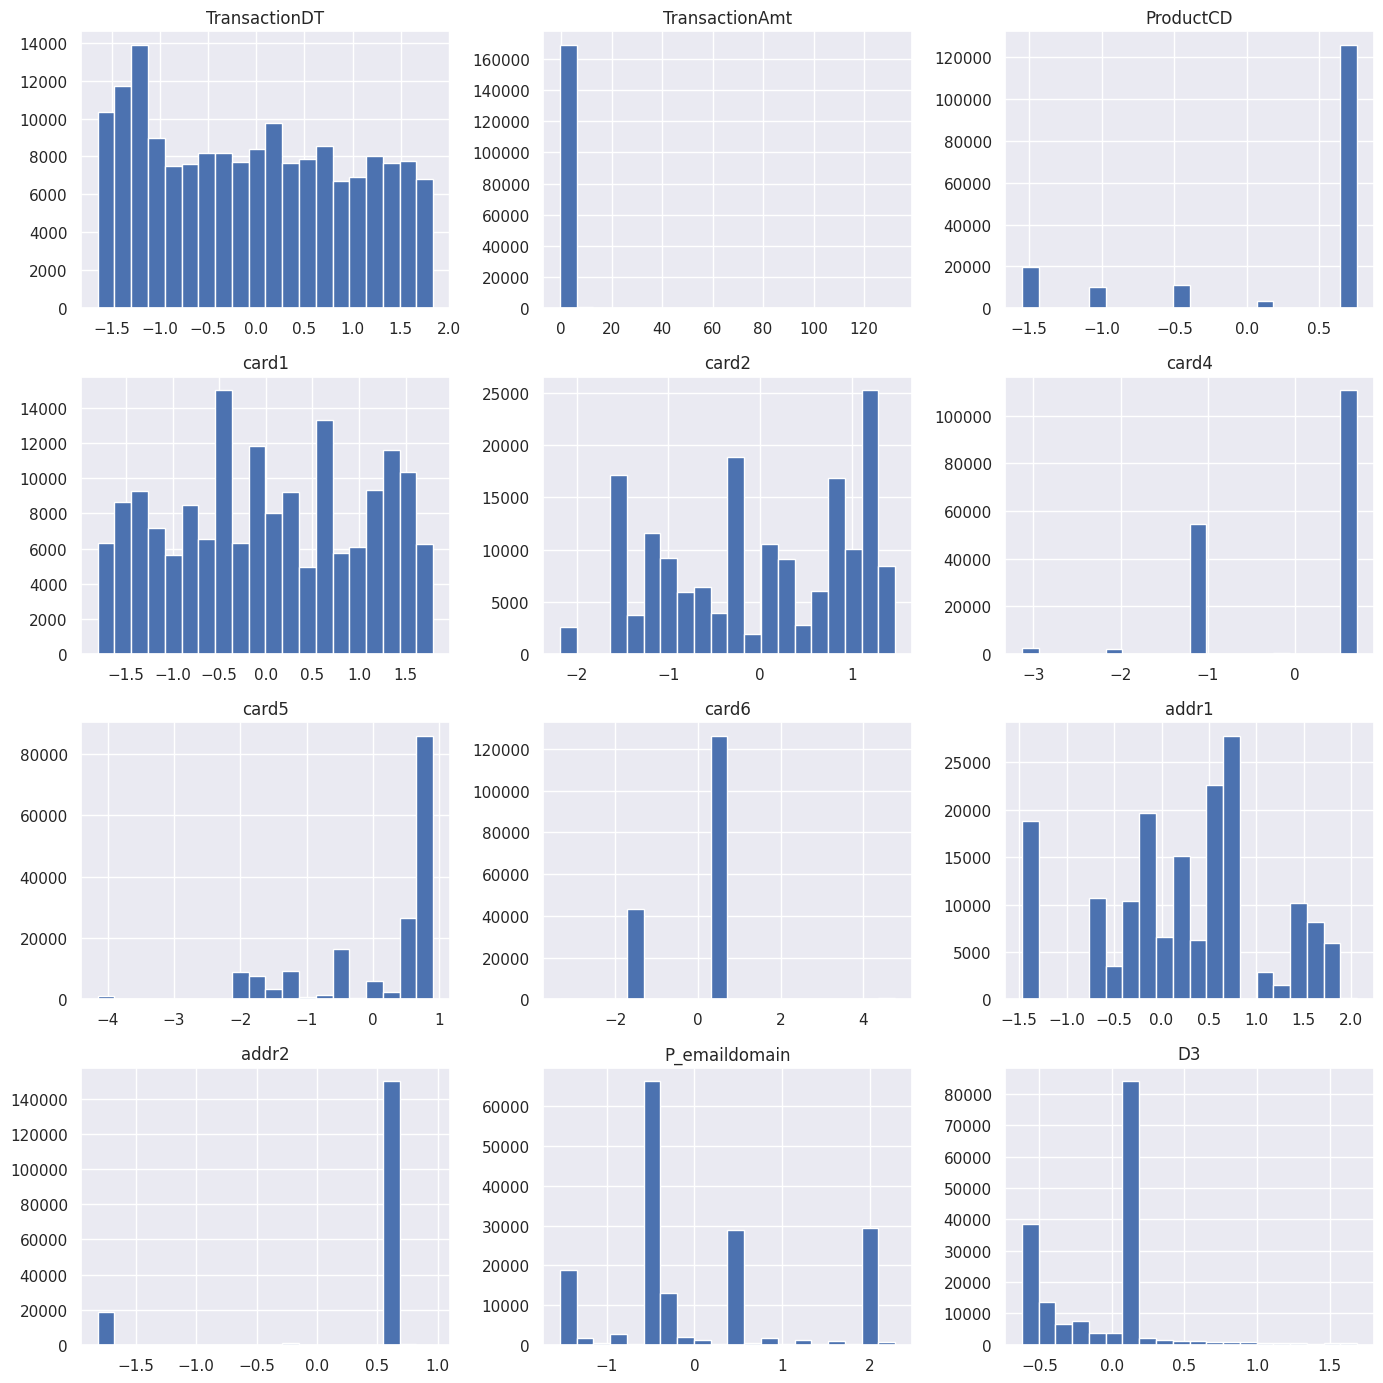

In [212]:
X_valid_no_ems.hist(bins=20, figsize=(14,14))
plt.tight_layout()

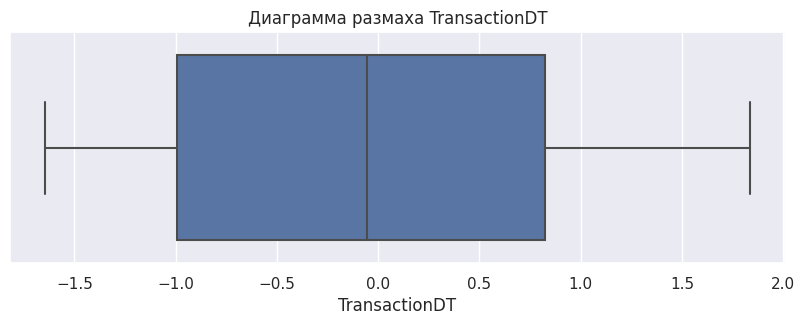

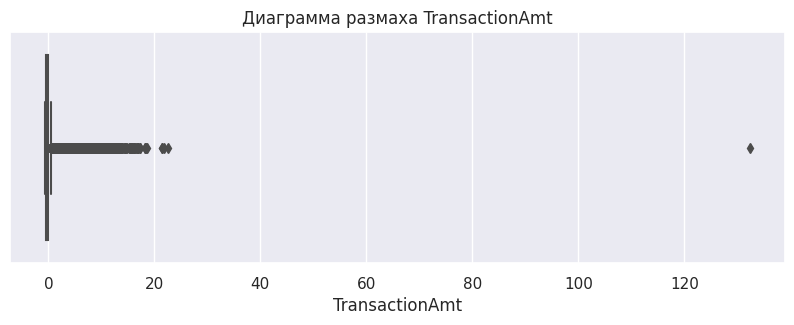

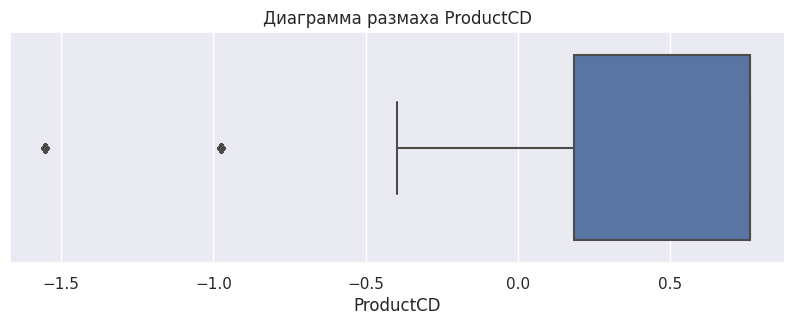

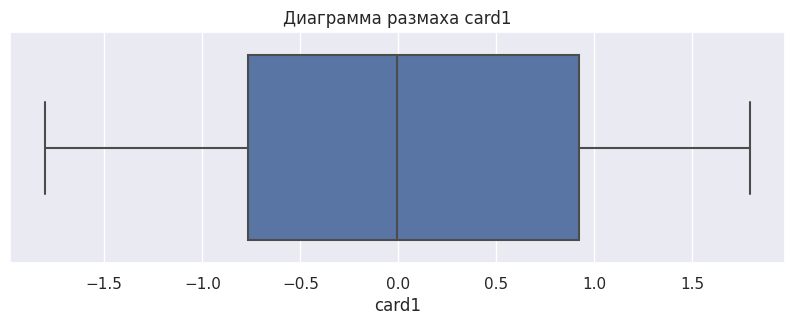

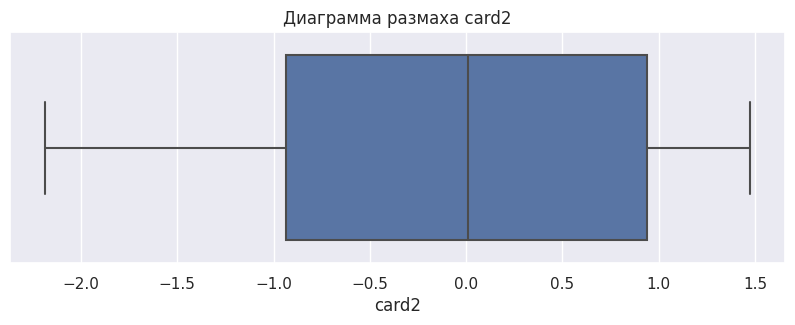

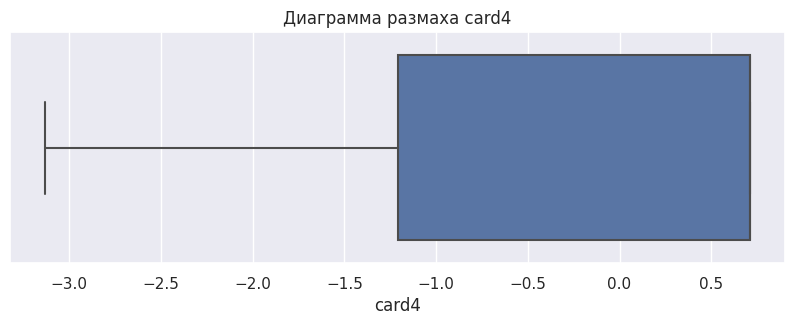

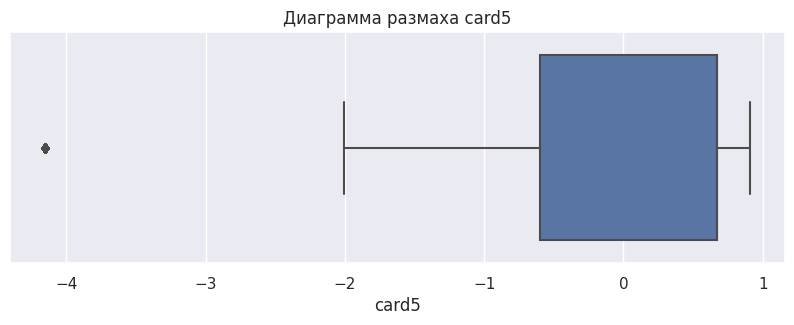

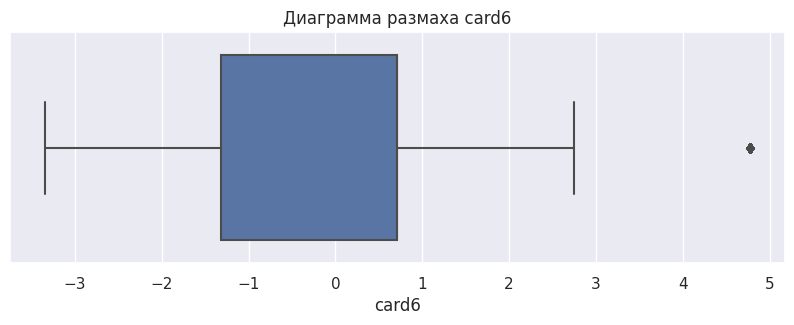

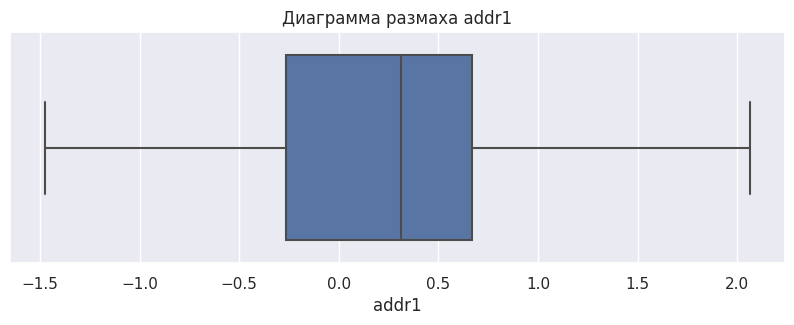

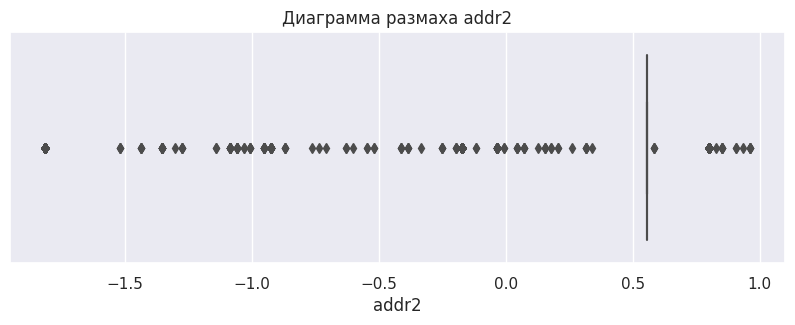

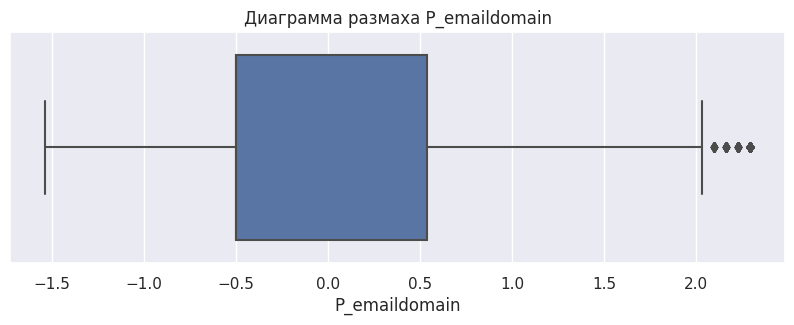

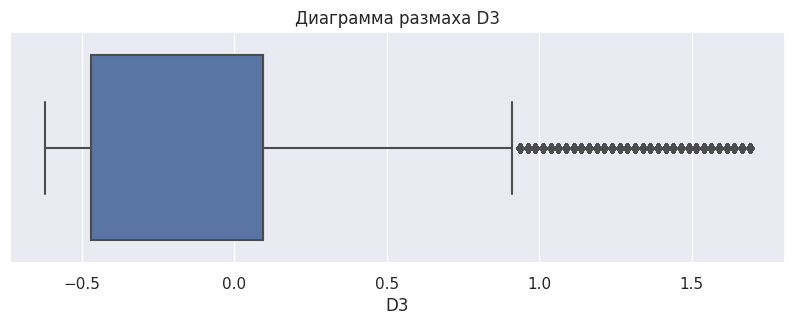

In [213]:
for feat in X_valid_no_ems.columns:
    plt_boxplot(X_valid_no_ems, feat)

Видим, что данные стали намного "чище" после очистки их от выбросов

#### Снова приступим к обучению моделей

------------------------------
DecisionTree
Доля верно угаданных объектов 0.9293746474901298


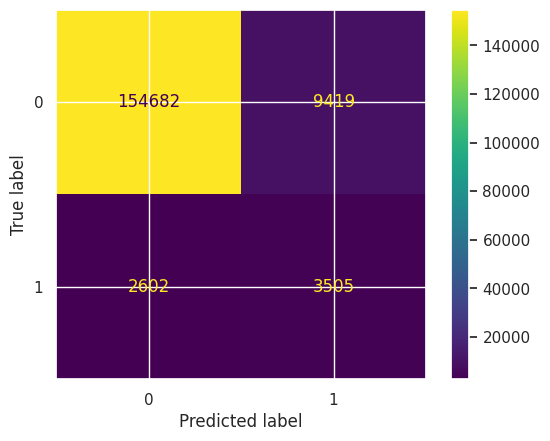

              precision    recall  f1-score   support

           0       0.98      0.94      0.96    164101
           1       0.27      0.57      0.37      6107

    accuracy                           0.93    170208
   macro avg       0.63      0.76      0.67    170208
weighted avg       0.96      0.93      0.94    170208

roc auc score:  0.758266987816905


In [214]:
DT_no_ems, DT_no_ems_roc_auc = fit_pred_score(DecisionTreeClassifier(), 'DecisionTree', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

------------------------------
RF
Доля верно угаданных объектов 0.9644023782665915


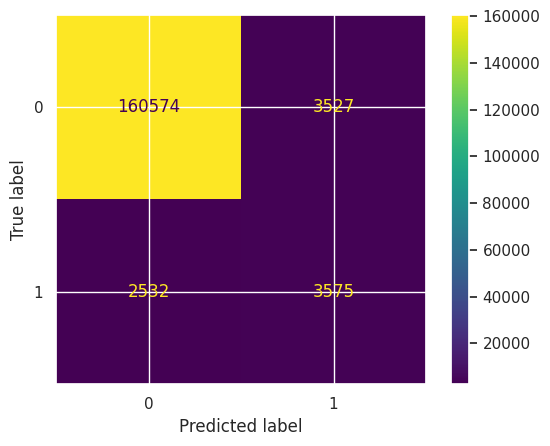

              precision    recall  f1-score   support

           0       0.98      0.98      0.98    164101
           1       0.50      0.59      0.54      6107

    accuracy                           0.96    170208
   macro avg       0.74      0.78      0.76    170208
weighted avg       0.97      0.96      0.97    170208

roc auc score:  0.9135602428912672


In [215]:
RF_no_ems, RF_no_ems_roc_auc = fit_pred_score(RandomForestClassifier(), 'RF', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

------------------------------
AdaBoost
Доля верно угаданных объектов 0.751715548035345


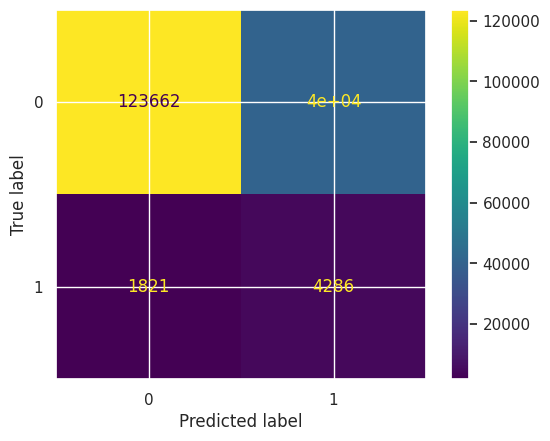

              precision    recall  f1-score   support

           0       0.99      0.75      0.85    164101
           1       0.10      0.70      0.17      6107

    accuracy                           0.75    170208
   macro avg       0.54      0.73      0.51    170208
weighted avg       0.95      0.75      0.83    170208

roc auc score:  0.7978993099884418


In [216]:
AdaBoost_no_ems, AdaBoost_no_ems_roc_auc = fit_pred_score(AdaBoostClassifier(), 'AdaBoost', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

------------------------------
GradBoost
Доля верно угаданных объектов 0.755622532430908


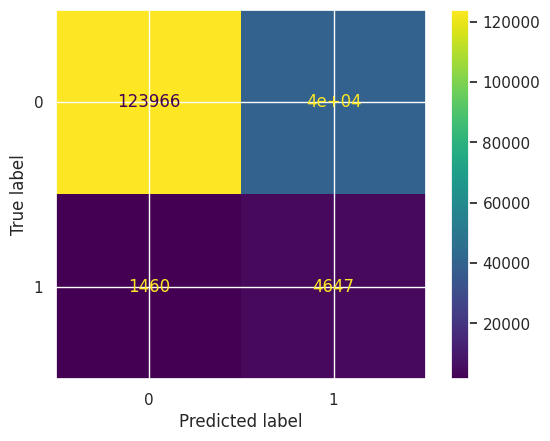

              precision    recall  f1-score   support

           0       0.99      0.76      0.86    164101
           1       0.10      0.76      0.18      6107

    accuracy                           0.76    170208
   macro avg       0.55      0.76      0.52    170208
weighted avg       0.96      0.76      0.83    170208

roc auc score:  0.8316253645893594


In [217]:
GradBoost_no_ems, GradBoost_no_ems_roc_auc = fit_pred_score(GradientBoostingClassifier(), 'GradBoost', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

------------------------------
XGB
Доля верно угаданных объектов 0.8462175690919346


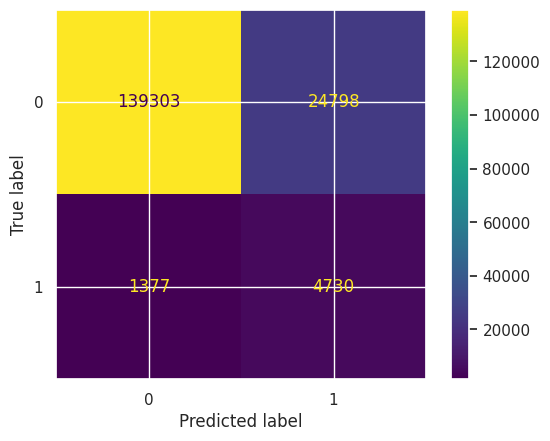

              precision    recall  f1-score   support

           0       0.99      0.85      0.91    164101
           1       0.16      0.77      0.27      6107

    accuracy                           0.85    170208
   macro avg       0.58      0.81      0.59    170208
weighted avg       0.96      0.85      0.89    170208

roc auc score:  0.8885607674307406


In [218]:
XGB_no_ems, XGB_no_ems_roc_auc = fit_pred_score(XGBClassifier(), 'XGB', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

------------------------------
LGBM
Доля верно угаданных объектов 0.8107492009776274


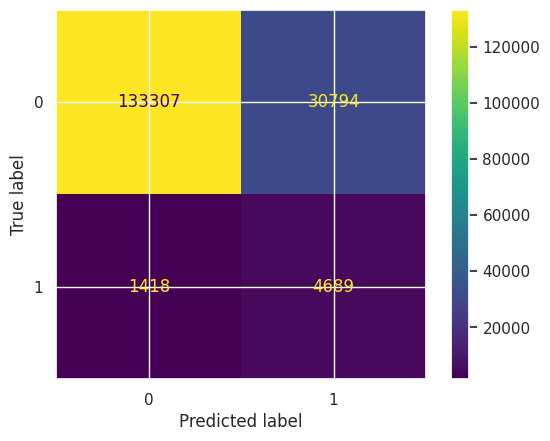

              precision    recall  f1-score   support

           0       0.99      0.81      0.89    164101
           1       0.13      0.77      0.23      6107

    accuracy                           0.81    170208
   macro avg       0.56      0.79      0.56    170208
weighted avg       0.96      0.81      0.87    170208

roc auc score:  0.868996276777059


In [219]:
LGBM_no_ems, LGBM_no_ems_roc_auc = fit_pred_score(LGBMClassifier(), 'LGBM', X_train_no_ems, y_train_no_ems, X_valid_no_ems, y_valid_no_ems)

Посмотрим на сравнение результатов ```roc auc score``` до очистки от выбросов и после

In [220]:
roc_auc_df3 = pd.DataFrame(data=[DT_no_ems_roc_auc, 
                                 RF_no_ems_roc_auc, 
                                 AdaBoost_no_ems_roc_auc,
                                 GradBoost_no_ems_roc_auc,
                                 XGB_no_ems_roc_auc,
                                 LGBM_no_ems_roc_auc],
                           index=['DT', 'RF', 'AdaBoost', 'GBM', 'XGB', 'LGBM'],
                          columns=['roc auc score (no emmisions)'])
roc_auc_general = pd.concat([roc_auc_df, roc_auc_df3], axis=1)
roc_auc_general

roc auc score  roc auc score (no emmisions)
DT             0.757155                      0.758267
RF             0.914119                      0.913560
AdaBoost       0.811919                      0.797899
GBM            0.839201                      0.831625
XGB            0.895739                      0.888561
LGBM           0.874873                      0.868996

Прогнозы в целом не улучшились, а значит следует поискать другие способы улучшения наших прогнозов

Напомню, что это прогнозы на валидационном датасете с дисбалансом классов, а значит это довольно хороший результат прогнозов

(array([119605.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0., 114184.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

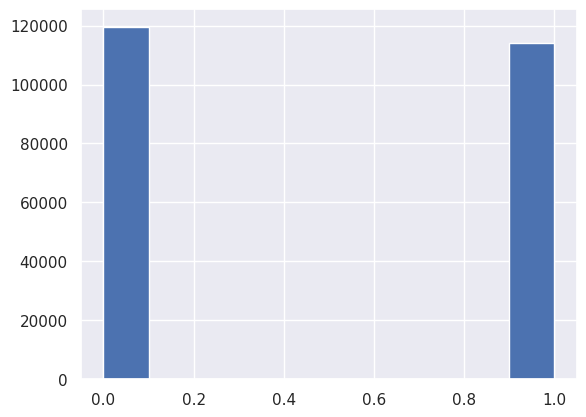

In [221]:
plt.hist(y_train_no_ems, label='train')

(array([164101.,      0.,      0.,      0.,      0.,      0.,      0.,
             0.,      0.,   6107.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

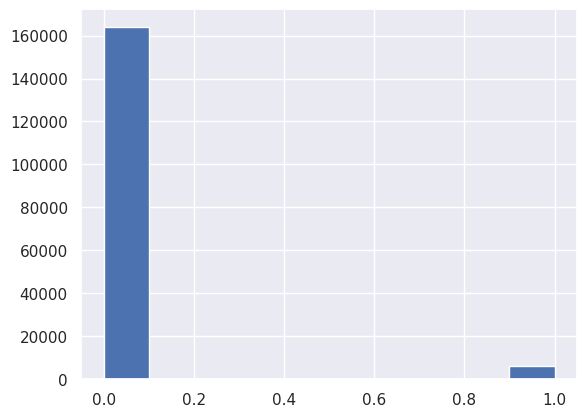

In [222]:
plt.hist(y_valid_no_ems, label='valid')

Но сперва попробуем сделать прогноз на тестовых данных и отправить submit на проверку на Kaggle

Напишем функцию для обучения модели и формирования отчета нужной формы для отправки

Посмотрим на образец формы для отправки

In [223]:
sample_submission.head(10)

TransactionID  isFraud
0        3663549      0.5
1        3663550      0.5
2        3663551      0.5
3        3663552      0.5
4        3663553      0.5
5        3663554      0.5
6        3663555      0.5
7        3663556      0.5
8        3663557      0.5
9        3663558      0.5

In [224]:
RF_no_ems.predict(test_df_sc)
y_pred_proba = RF_no_ems.predict_proba(test_df_sc)[:,1]
y_pred_proba

array([0.1 , 0.11, 0.14, ..., 0.03, 0.03, 0.23])

In [225]:
transactionIDs_test

0         3663549
1         3663550
2         3663551
3         3663552
4         3663553
           ...   
506686    4170235
506687    4170236
506688    4170237
506689    4170238
506690    4170239
Name: TransactionID, Length: 506691, dtype: uint32

In [226]:
isFraud_df = pd.DataFrame(data=y_pred_proba,
                        index=transactionIDs_test.index,
                        columns=['isFraud'])
submit_df = pd.concat([transactionIDs_test, isFraud_df], axis=1)
submit_df

TransactionID  isFraud
0             3663549     0.10
1             3663550     0.11
2             3663551     0.14
3             3663552     0.08
4             3663553     0.01
...               ...      ...
506686        4170235     0.34
506687        4170236     0.09
506688        4170237     0.03
506689        4170238     0.03
506690        4170239     0.23

[506691 rows x 2 columns]

In [227]:
submit_df.to_csv('RandomForest.csv', index=False)

In [228]:
def fit_pred_final(model, model_name, test_data):
    model.predict(test_data)
    y_pred_proba = model.predict_proba(test_data)[:,1]
    submit_df = pd.DataFrame(data=[transactionIDs_test, y_pred_proba],
                             index=list(test_data.index),
                            columns=['TransactionID', 'isFraud'])
#     submit_df.to_csv('{}.csv'.format(model_name))
    return submit_df